In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as ep

ep.update_plot_defaults()

In [67]:
%matplotlib notebook

In [68]:
tensor_normalize = transforms.Compose([transforms.ToTensor()])
#                                       transforms.Normalize(mean=[0.1307],std=[0.3081])])

MNIST_train = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',train=True,transform=tensor_normalize,download=True)
MNIST_train_sub = torch.utils.data.Subset(MNIST_train, range(2000))
MNIST_test = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',train=False,transform=tensor_normalize,download=True)

In [69]:
flat_MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train):
    data = data.flatten()
    target = torch.eye(len(MNIST_train.classes))[target]
    flat_MNIST_train.append((idx, data, target))

flat_MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test):
    data = data.flatten()
    target = torch.eye(len(MNIST_test.classes))[target]
    flat_MNIST_test.append((idx, data, target))

data_generator = torch.Generator()

In [70]:
train_samples = 10000

train_dataloader = torch.utils.data.DataLoader(flat_MNIST_train, shuffle=True, generator=data_generator)

train_sub_dataloader = torch.utils.data.DataLoader(flat_MNIST_train[:train_samples], shuffle=True, generator=data_generator)

test_dataloader = torch.utils.data.DataLoader(flat_MNIST_test, batch_size=10000, shuffle=False)

In [71]:
data_seed = 0
seed = 42

### Backprop (no weight contraints)

In [73]:
network_config = ut.read_from_yaml('../config/MNIST/EIANN_2_hidden_mnist_backprop_relu_SGD_config.yaml')
pprint(network_config, sort_dicts=False)

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

{'layer_config': {'Input': {'E': {'size': 784}},
                  'H1': {'E': {'size': 500, 'activation': 'relu'}},
                  'H2': {'E': {'size': 500, 'activation': 'relu'}},
                  'Output': {'E': {'size': 10, 'activation': 'relu'}}},
 'projection_config': {'H1': {'E': {'Input': {'E': {'direction': 'F',
                                                    'learning_rule': 'Backprop'}}}},
                       'H2': {'E': {'H1': {'E': {'direction': 'F',
                                                 'learning_rule': 'Backprop'}}}},
                       'Output': {'E': {'H2': {'E': {'direction': 'F',
                                                     'learning_rule': 'Backprop'}}}}},
 'training_kwargs': {'tau': 1,
                     'forward_steps': 1,
                     'backward_steps': 1,
                     'learning_rate': 0.01,
                     'verbose': False,
                     'optimizer': 'SGD'}}


In [74]:
initial_weights = {}
for layer in network:
    for population in layer:
        for projection in population:
            initial_weights[projection.name] = projection.weight.data.detach().clone()

In [75]:
data_generator.manual_seed(data_seed)
network.train(train_sub_dataloader,
              epochs=1, 
              store_history=False, 
              status_bar=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0543)

Batch accuracy = 59.41999816894531%


<IPython.core.display.Javascript object>


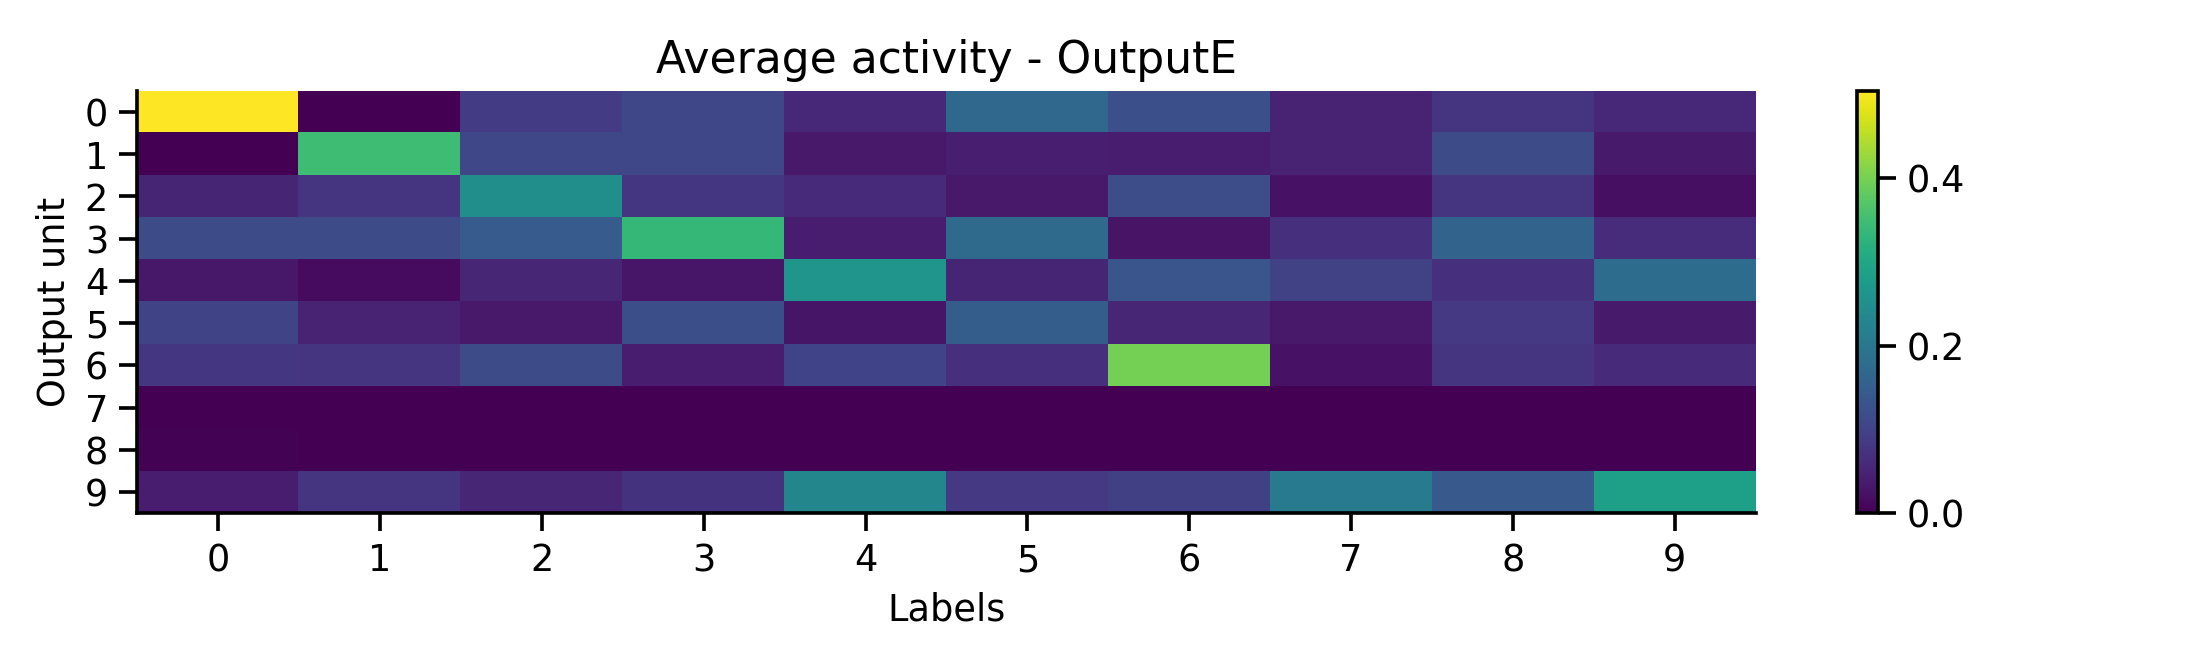

<IPython.core.display.Javascript object>


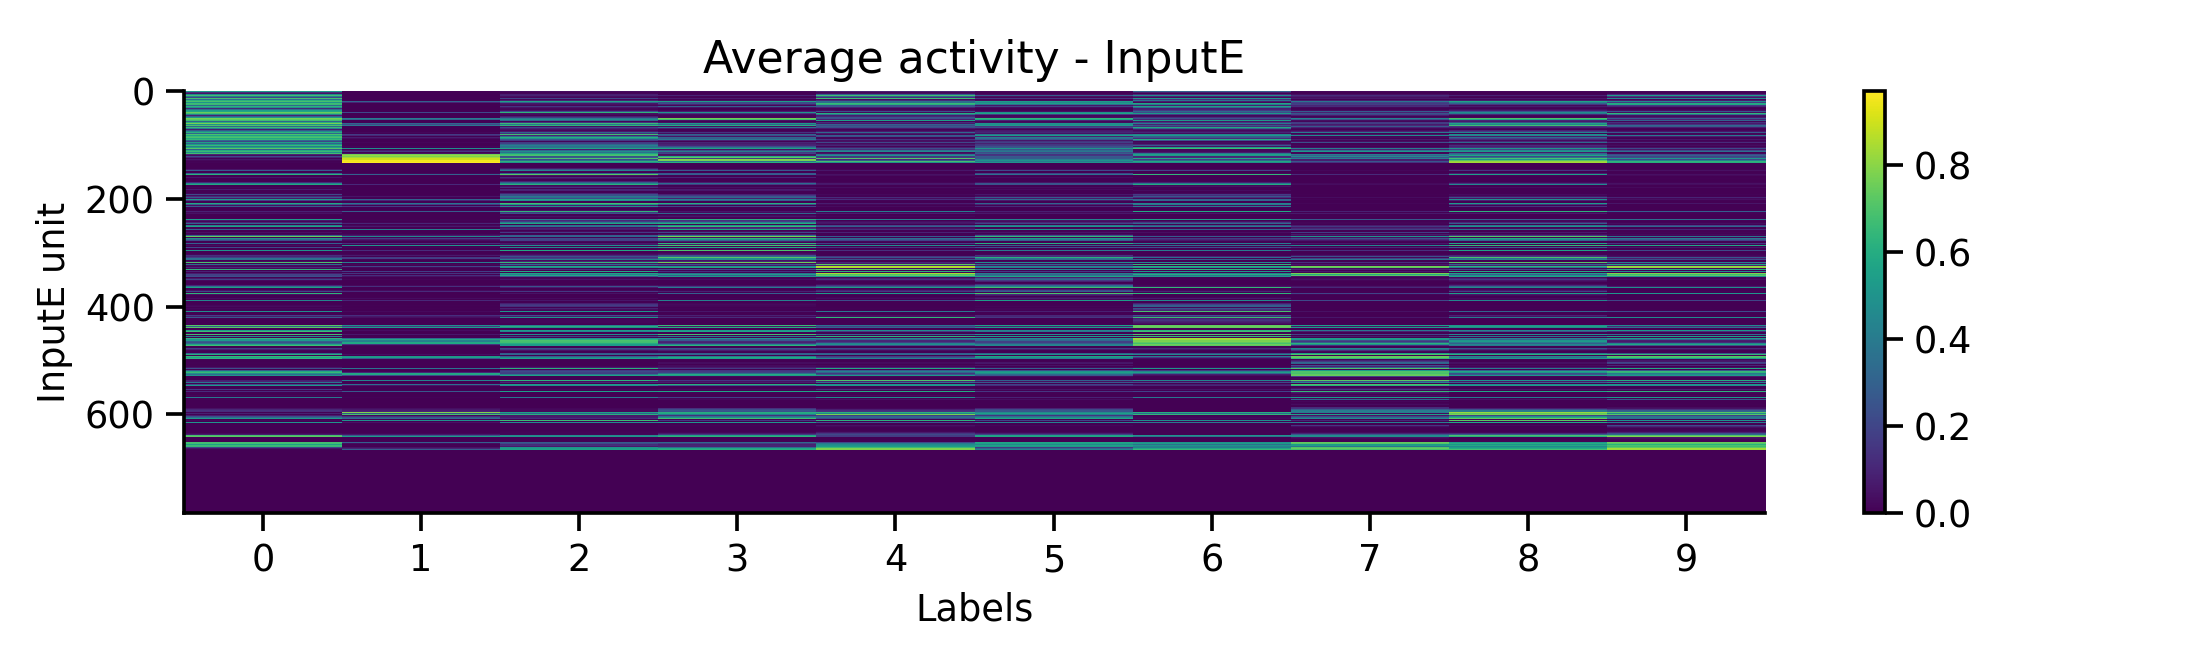

<IPython.core.display.Javascript object>


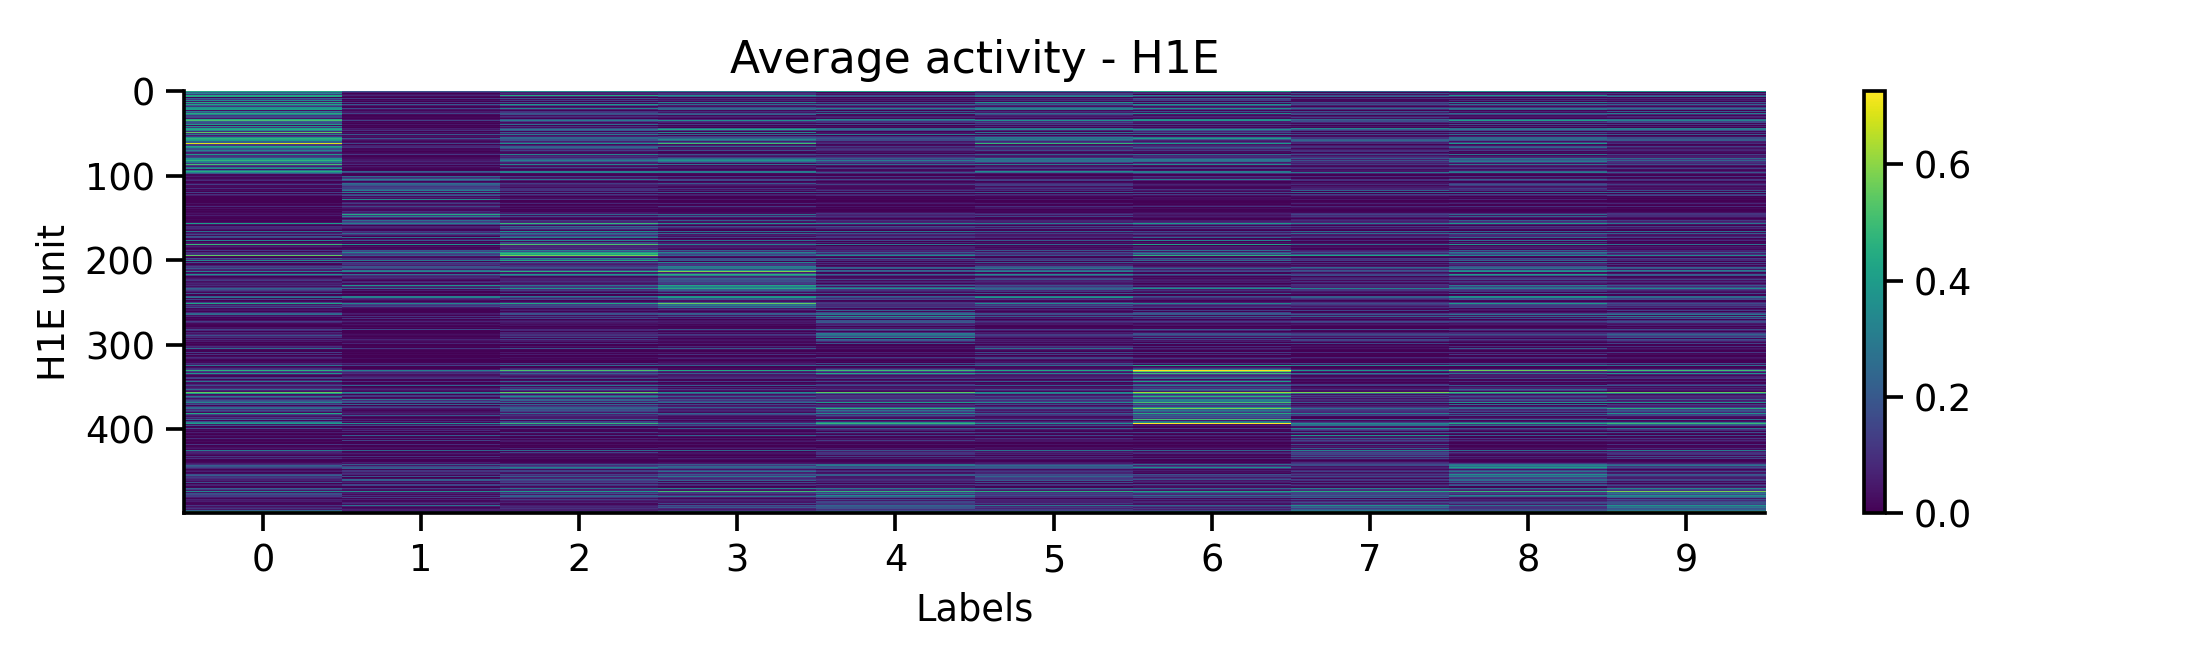

<IPython.core.display.Javascript object>


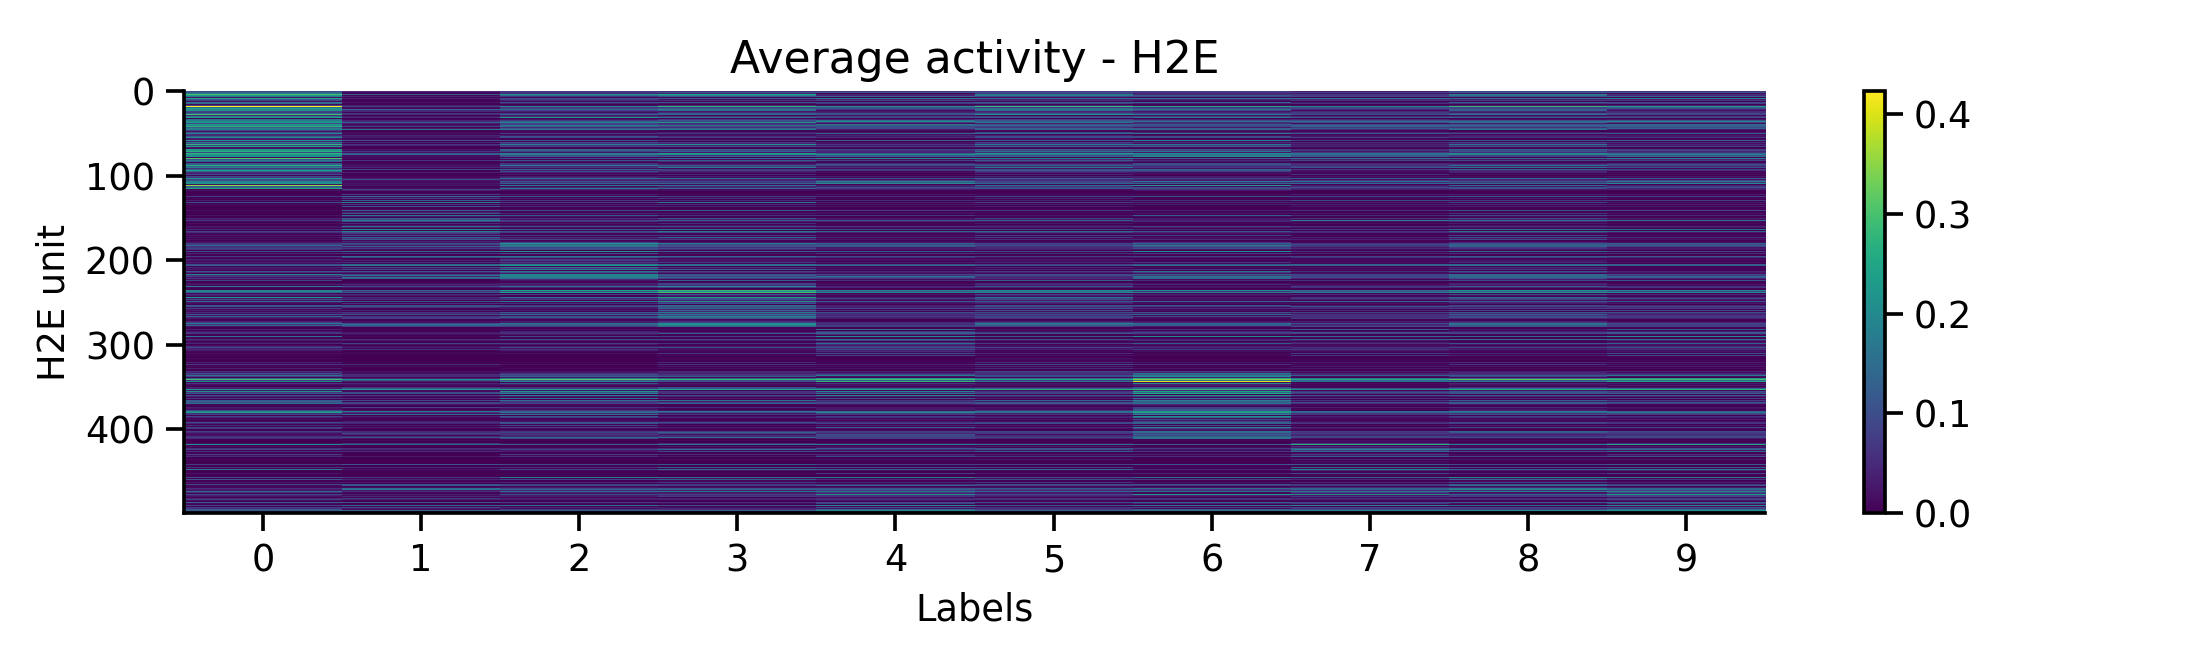

In [76]:
# ep.plot_MNIST_examples(network, test_dataloader)
ep.plot_batch_accuracy(network, test_dataloader, population='all')

<IPython.core.display.Javascript object>


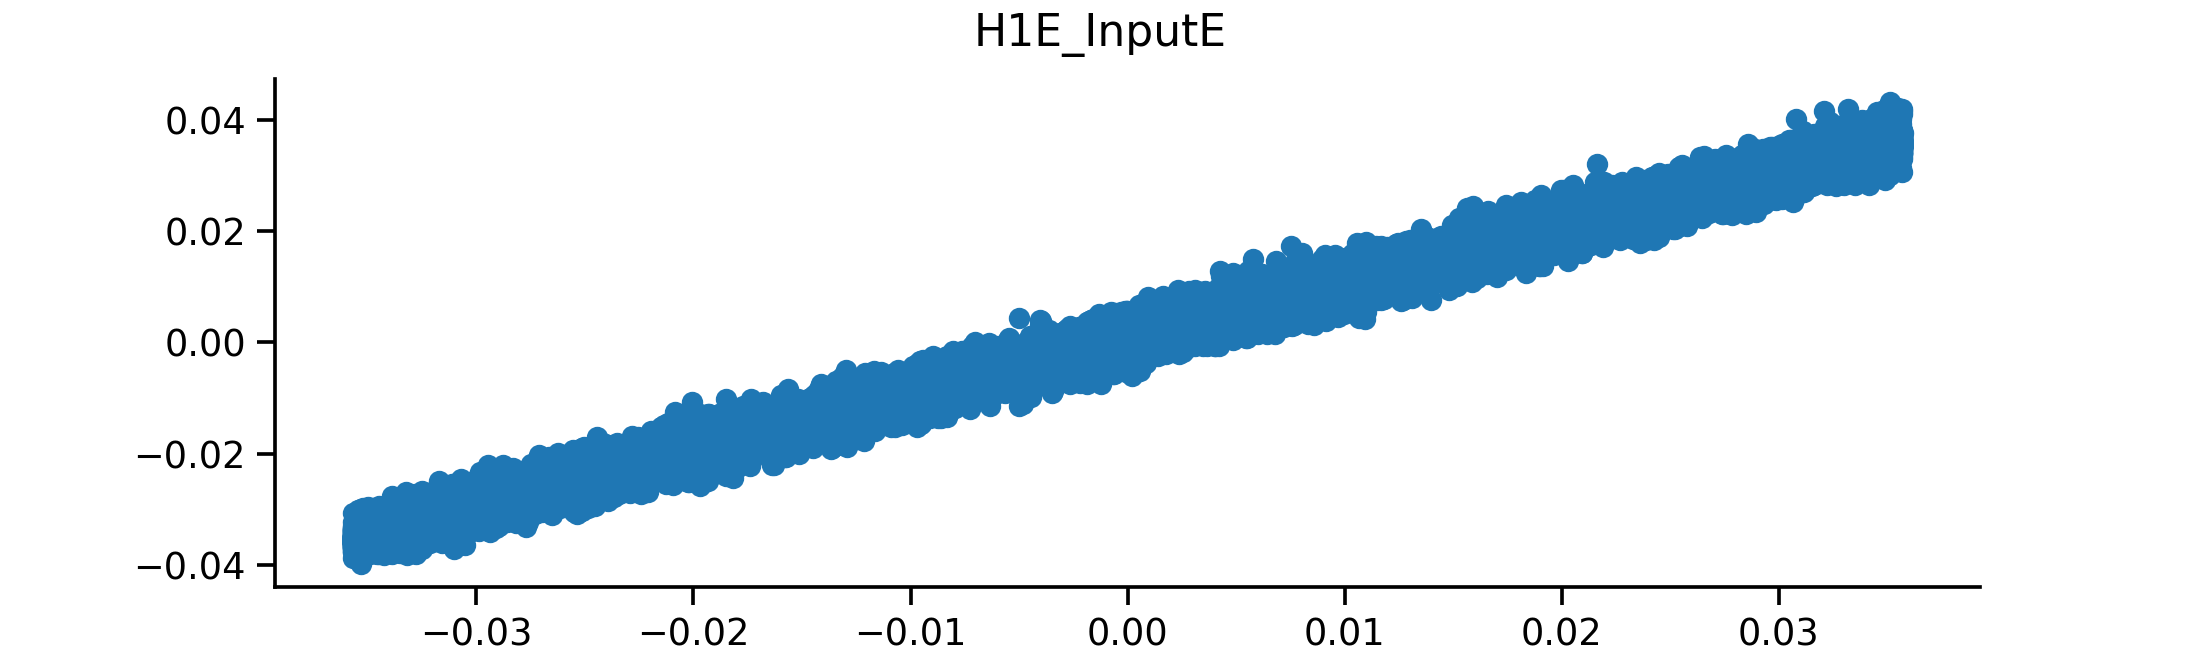

<IPython.core.display.Javascript object>


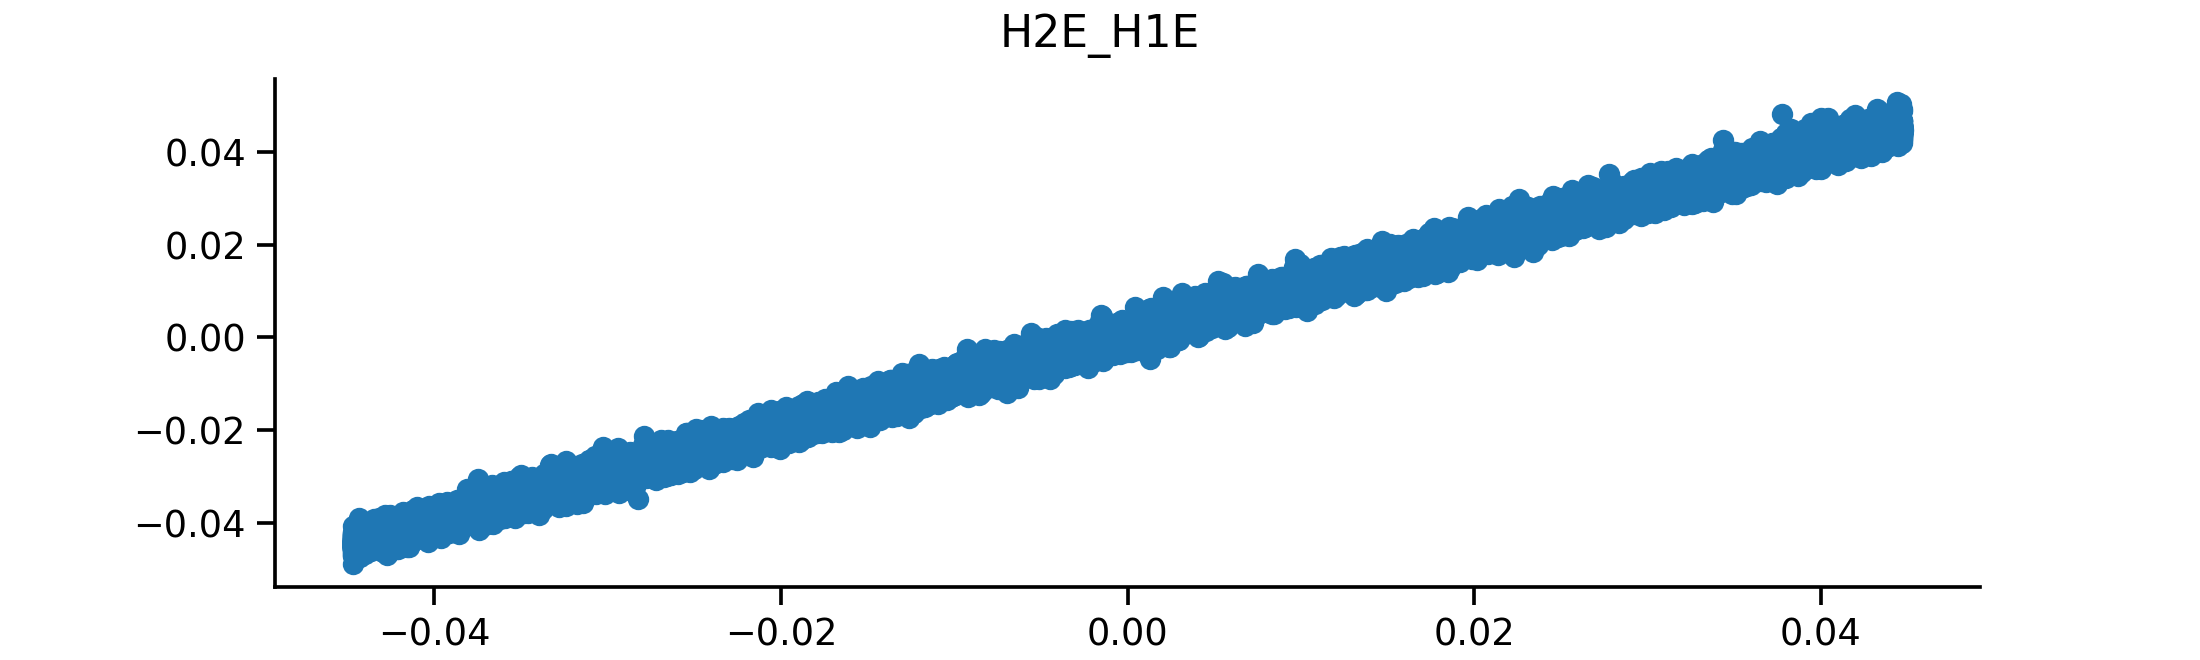

<IPython.core.display.Javascript object>


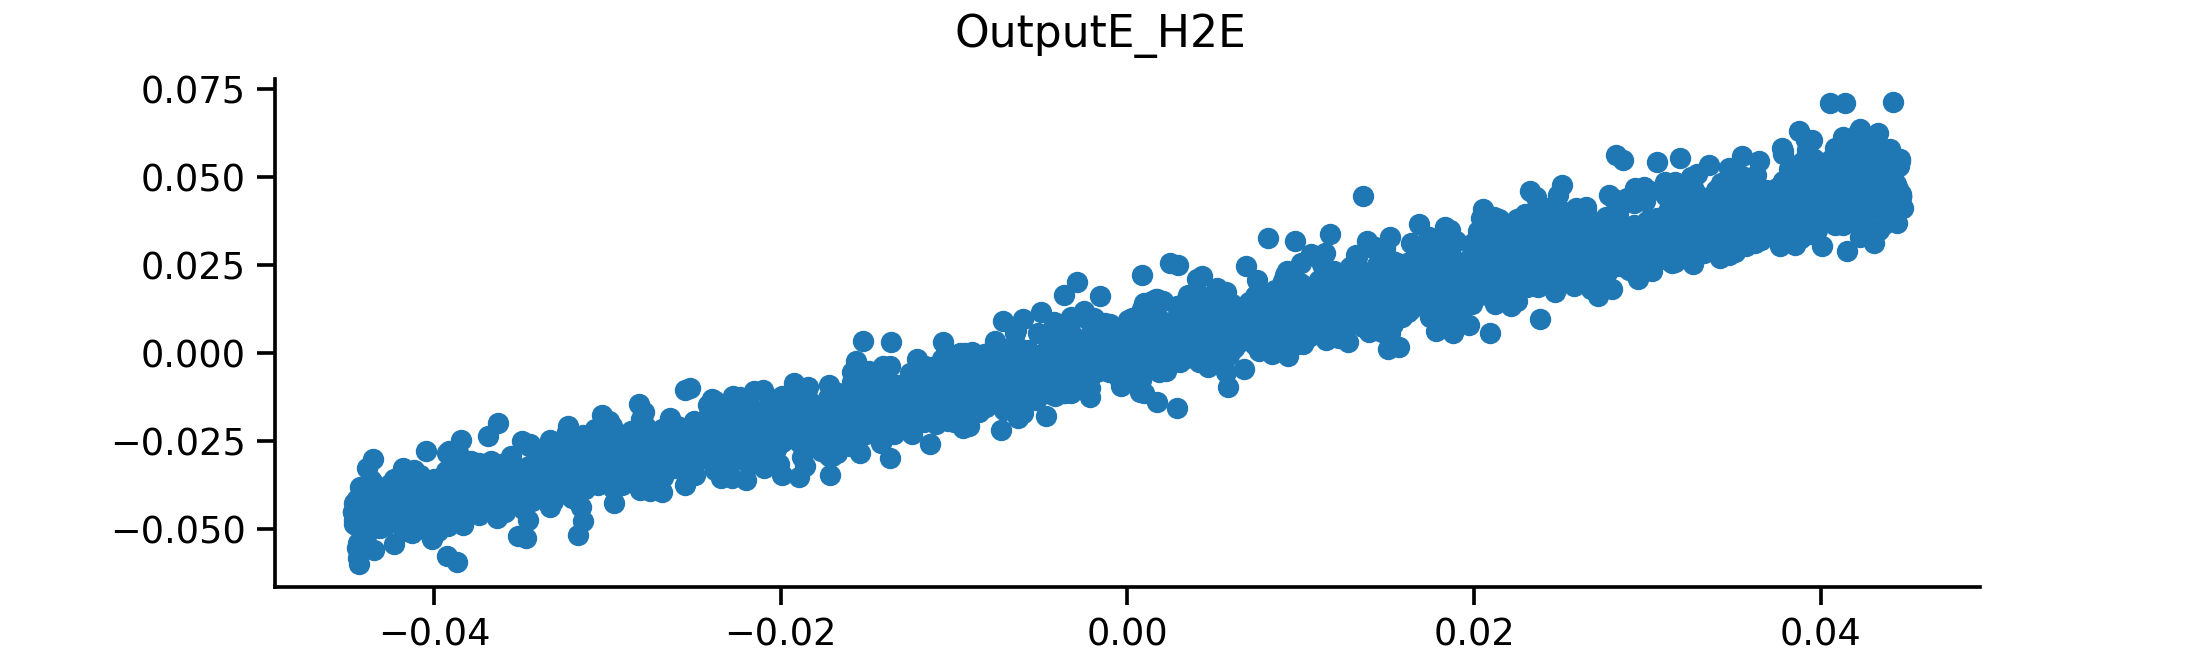

In [77]:
for layer in network:
    for population in layer:
        for projection in population:
            plt.figure()
            plt.scatter(initial_weights[projection.name].flatten(), projection.weight.data.detach().flatten())
            plt.suptitle(projection.name)

<IPython.core.display.Javascript object>


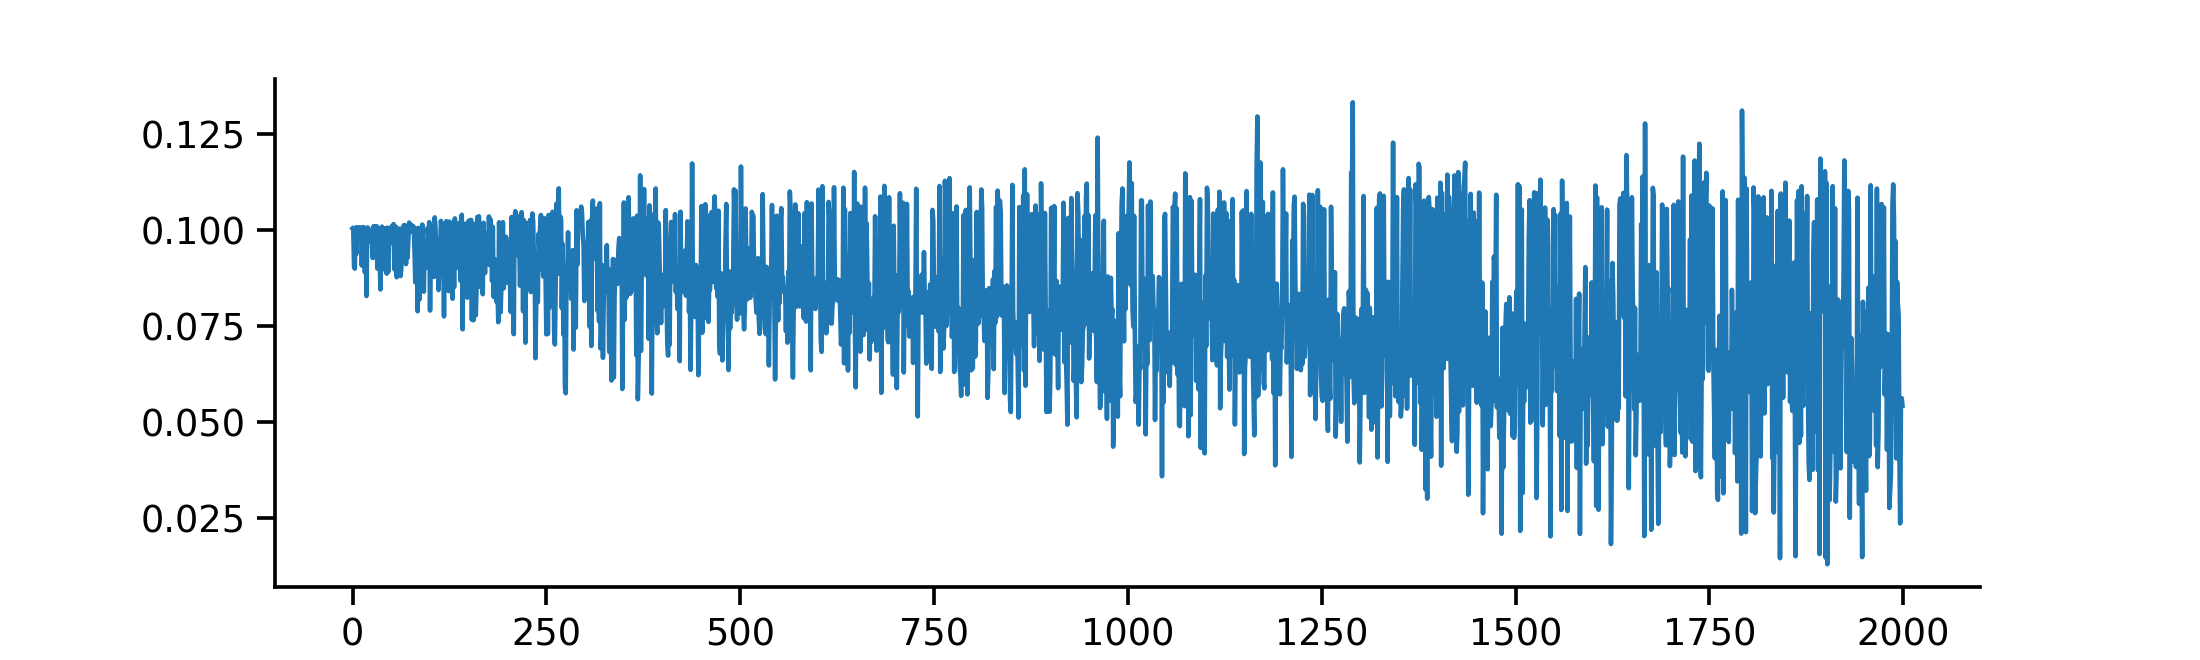

In [78]:
plt.figure()
plt.plot(network.loss_history)

## Backprop (Dale) - 1 hidden

In [11]:
network_config = ut.read_from_yaml('../optimize/data/mnist/20230102_EIANN_1_hidden_mnist_bpDale_softplus_config.yaml')

pprint(network_config, sort_dicts=False)

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

{'layer_config': {'Input': {'E': {'size': 784}},
                  'H1': {'E': {'size': 500,
                               'activation': 'softplus',
                               'activation_kwargs': {'beta': 39.767014540829535}},
                         'FBI': {'size': 94,
                                 'activation': 'softplus',
                                 'activation_kwargs': {'beta': 39.767014540829535},
                                 'tau': 2}},
                  'Output': {'E': {'size': 10,
                                   'activation': 'softplus',
                                   'activation_kwargs': {'beta': 39.767014540829535}},
                             'FBI': {'size': 4,
                                     'activation': 'softplus',
                                     'activation_kwargs': {'beta': 39.767014540829535},
                                     'tau': 2}}},
 'projection_config': {'H1': {'E': {'Input': {'E': {'weight_init': 'half_kaining',
       

In [13]:
initial_weights_1_hidden = {}
for layer in network:
    for population in layer:
        for projection in population:
            initial_weights_1_hidden[projection.name] = projection.weight.data.detach().clone()

Batch accuracy = 8.9399995803833%


<IPython.core.display.Javascript object>


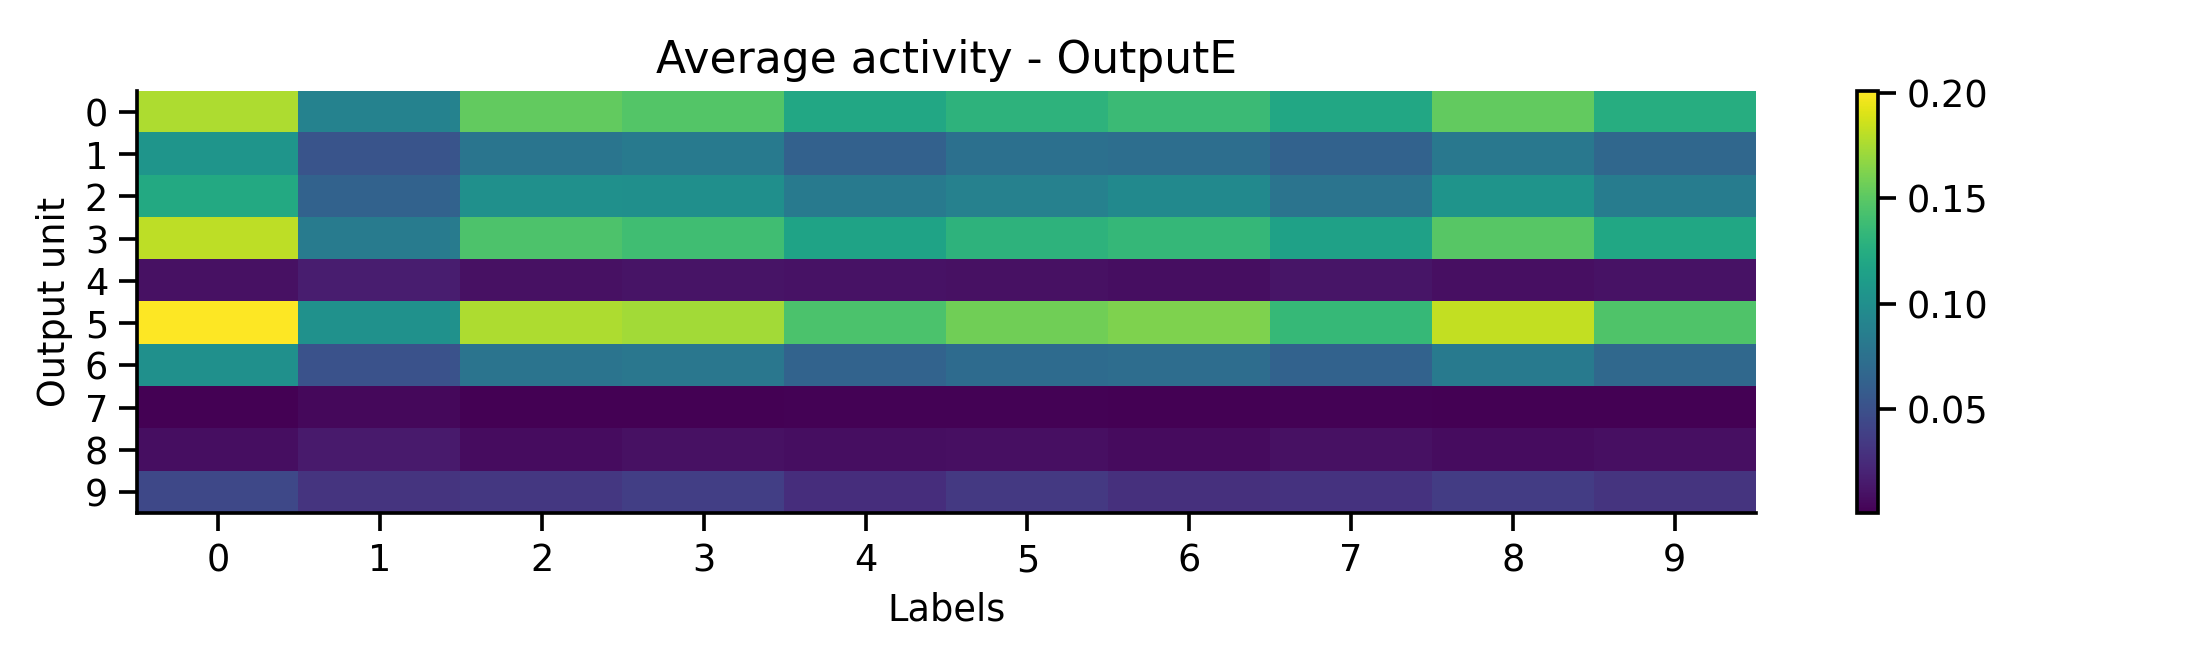

<IPython.core.display.Javascript object>


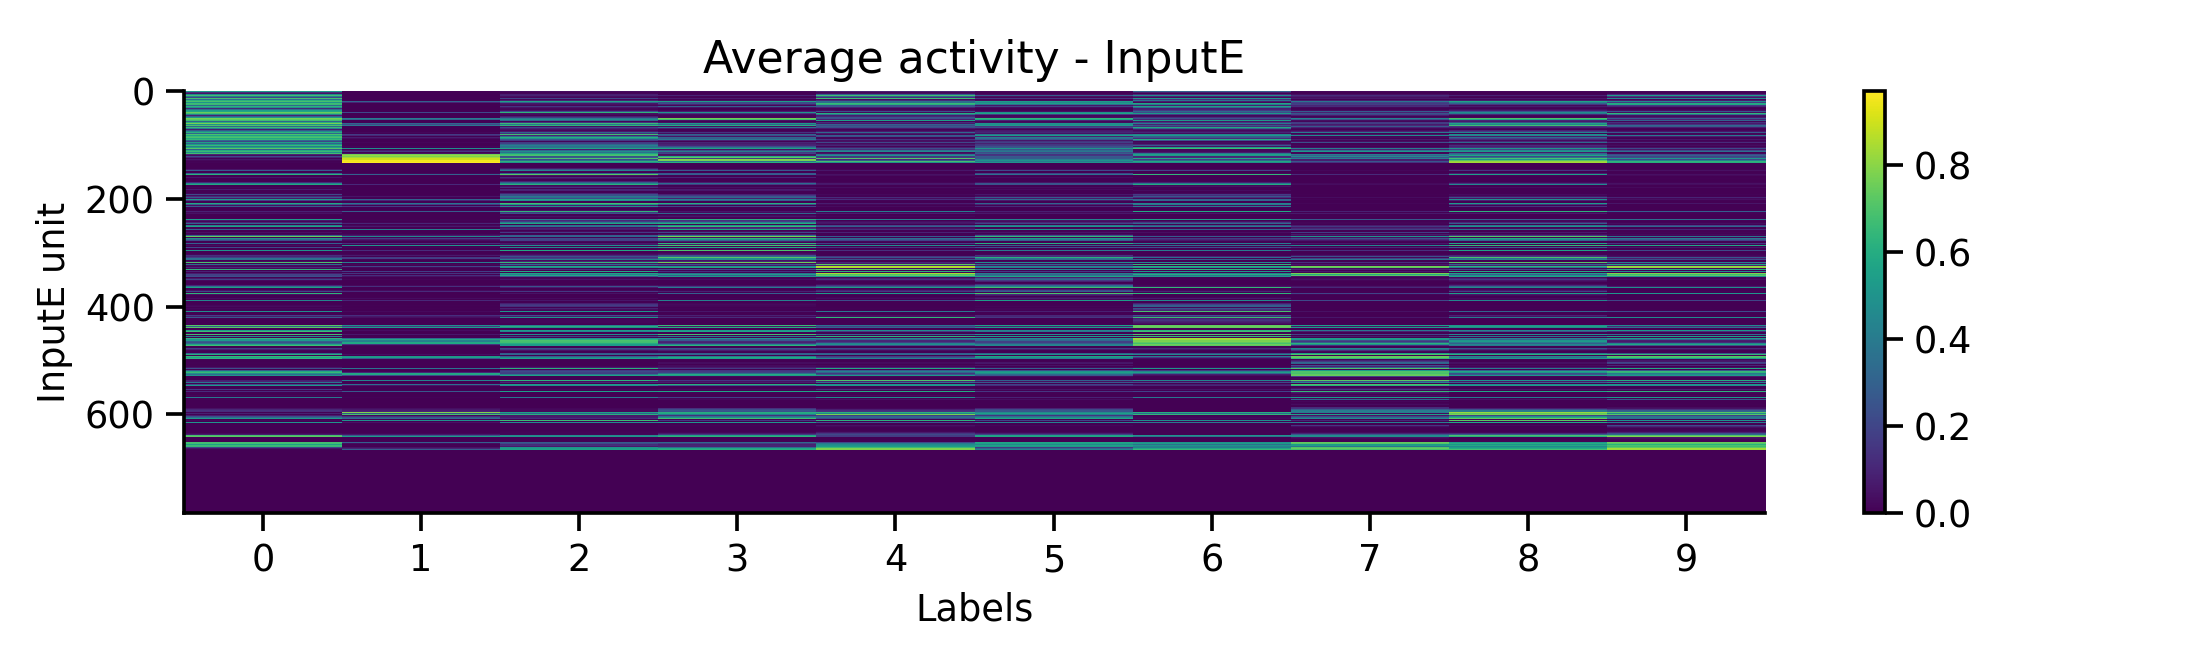

<IPython.core.display.Javascript object>


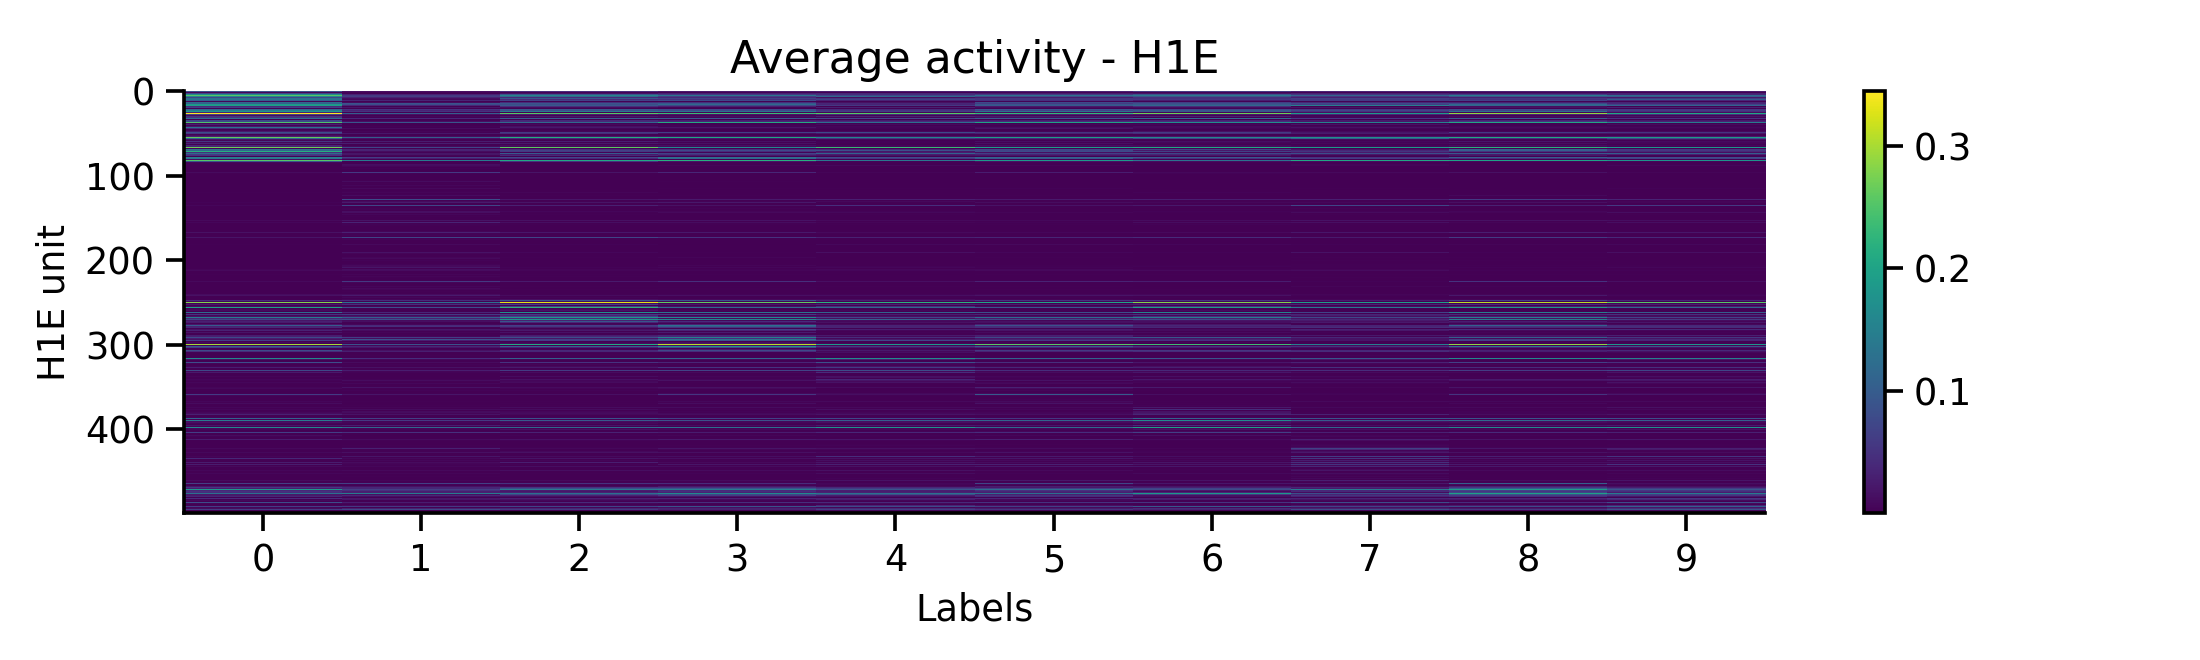

<IPython.core.display.Javascript object>


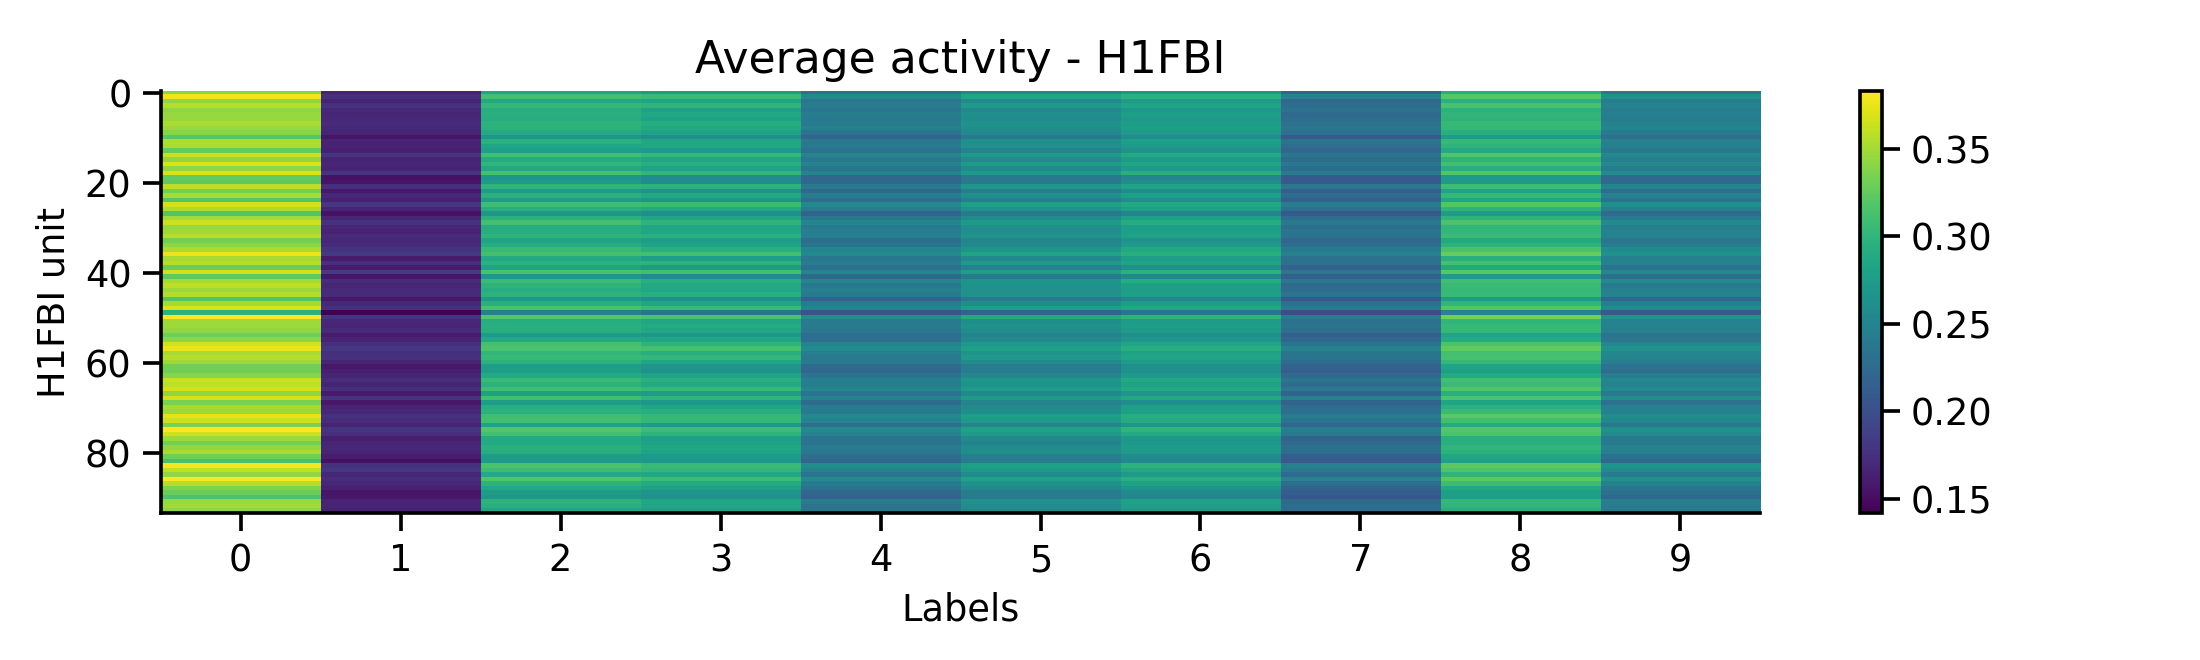

<IPython.core.display.Javascript object>


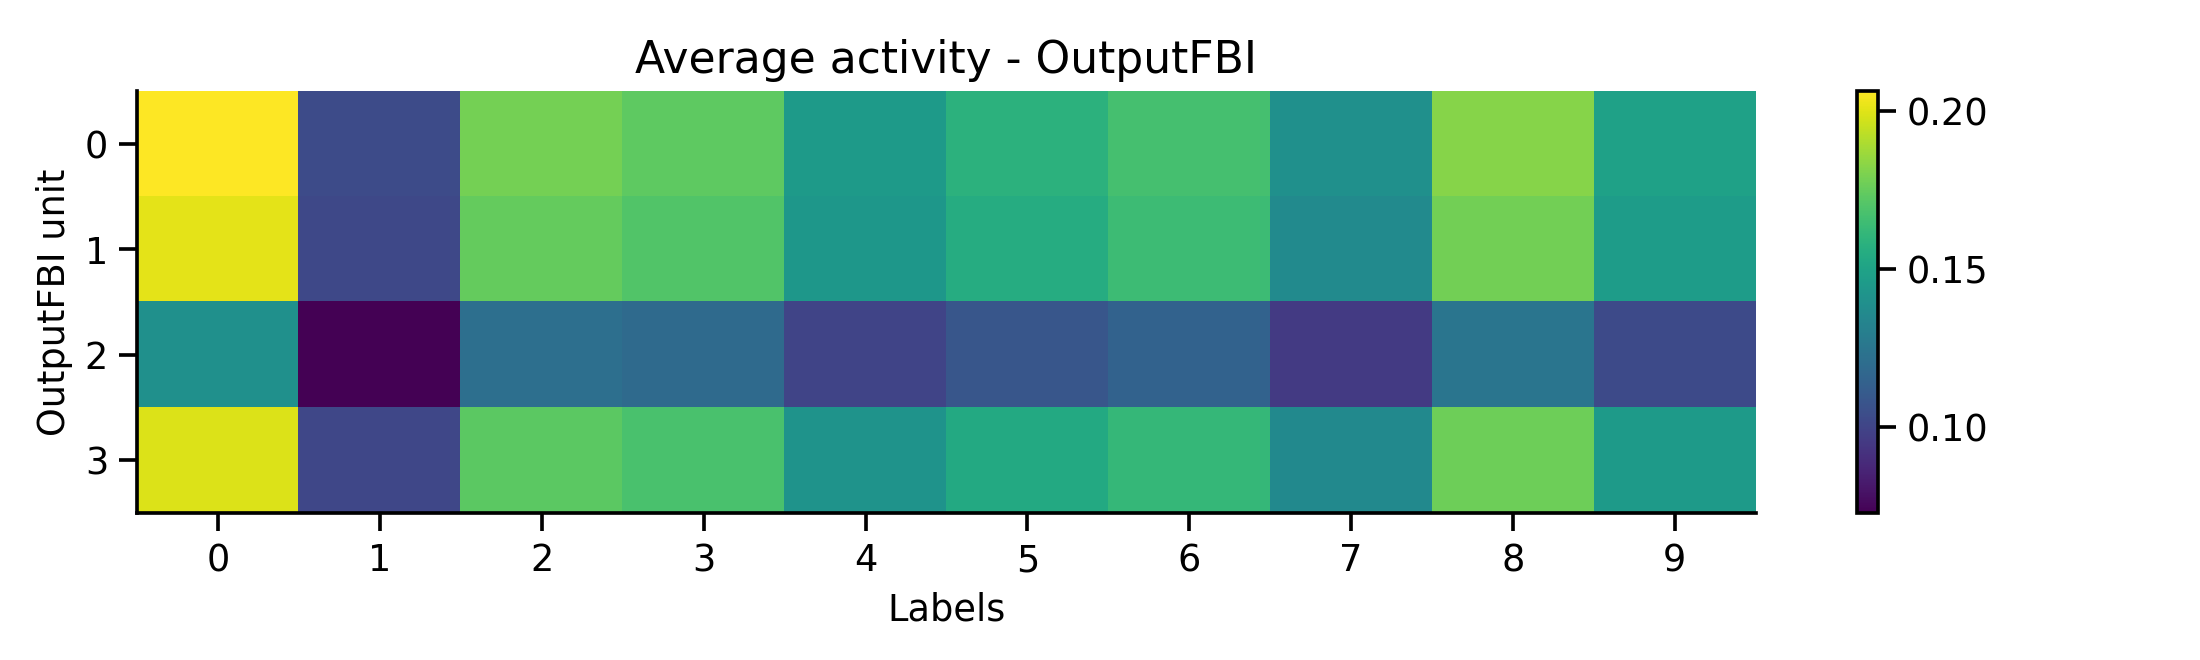

In [12]:
ep.plot_batch_accuracy(network, test_dataloader, population='all')

In [81]:
data_generator.manual_seed(data_seed)
network.train(train_sub_dataloader, 
              epochs=1, 
              store_history=True, 
              status_bar=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0039)

Batch accuracy = 83.30999755859375%


<IPython.core.display.Javascript object>


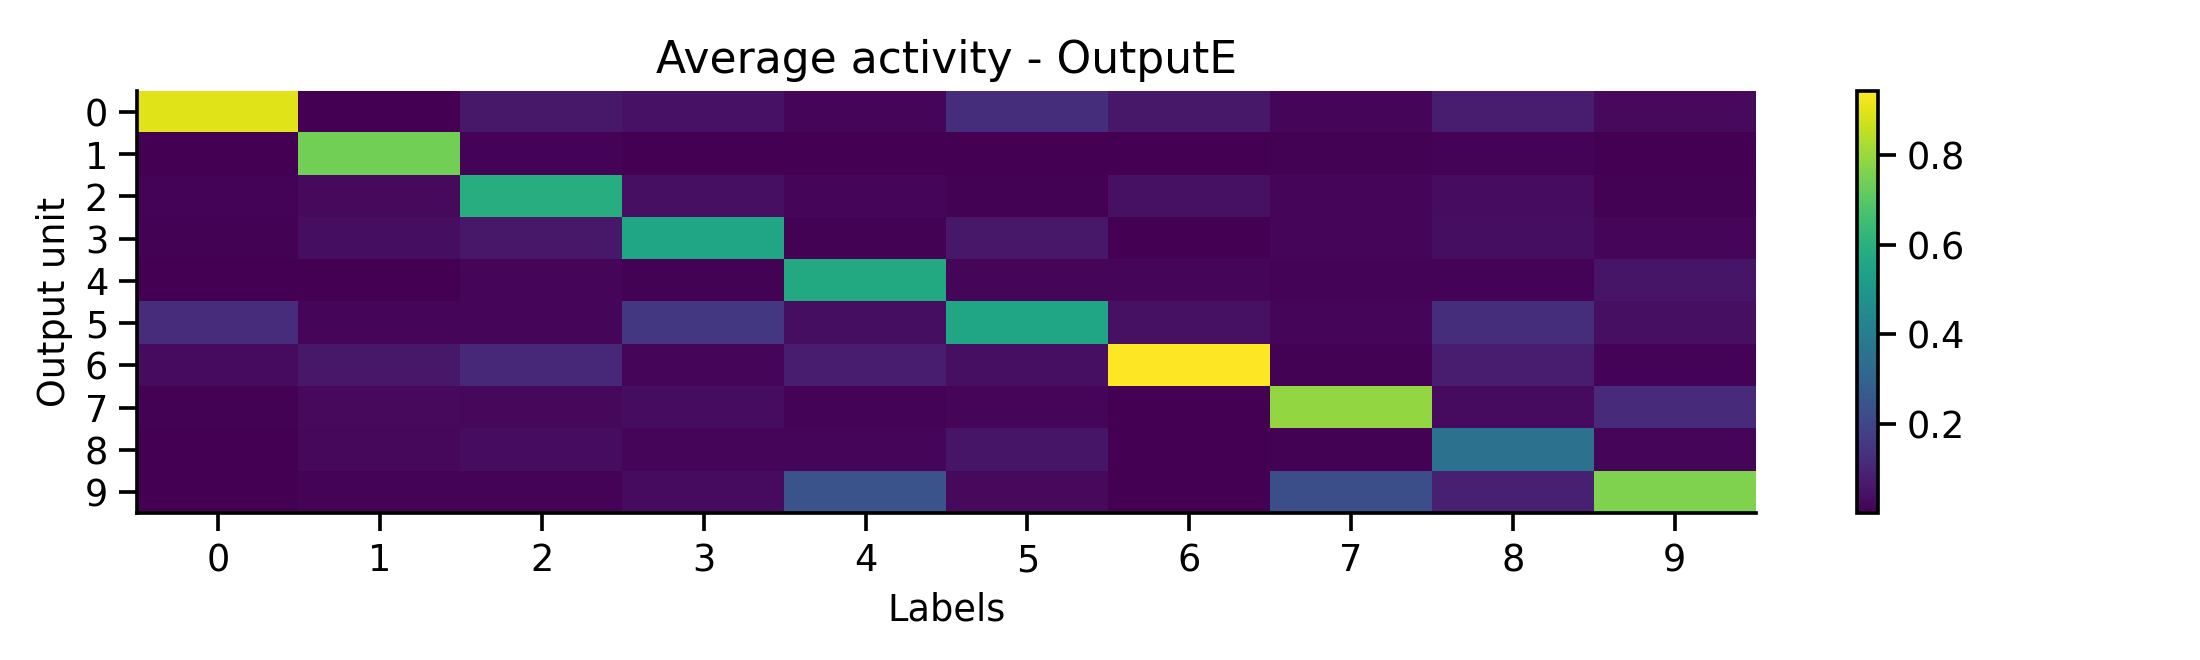

<IPython.core.display.Javascript object>


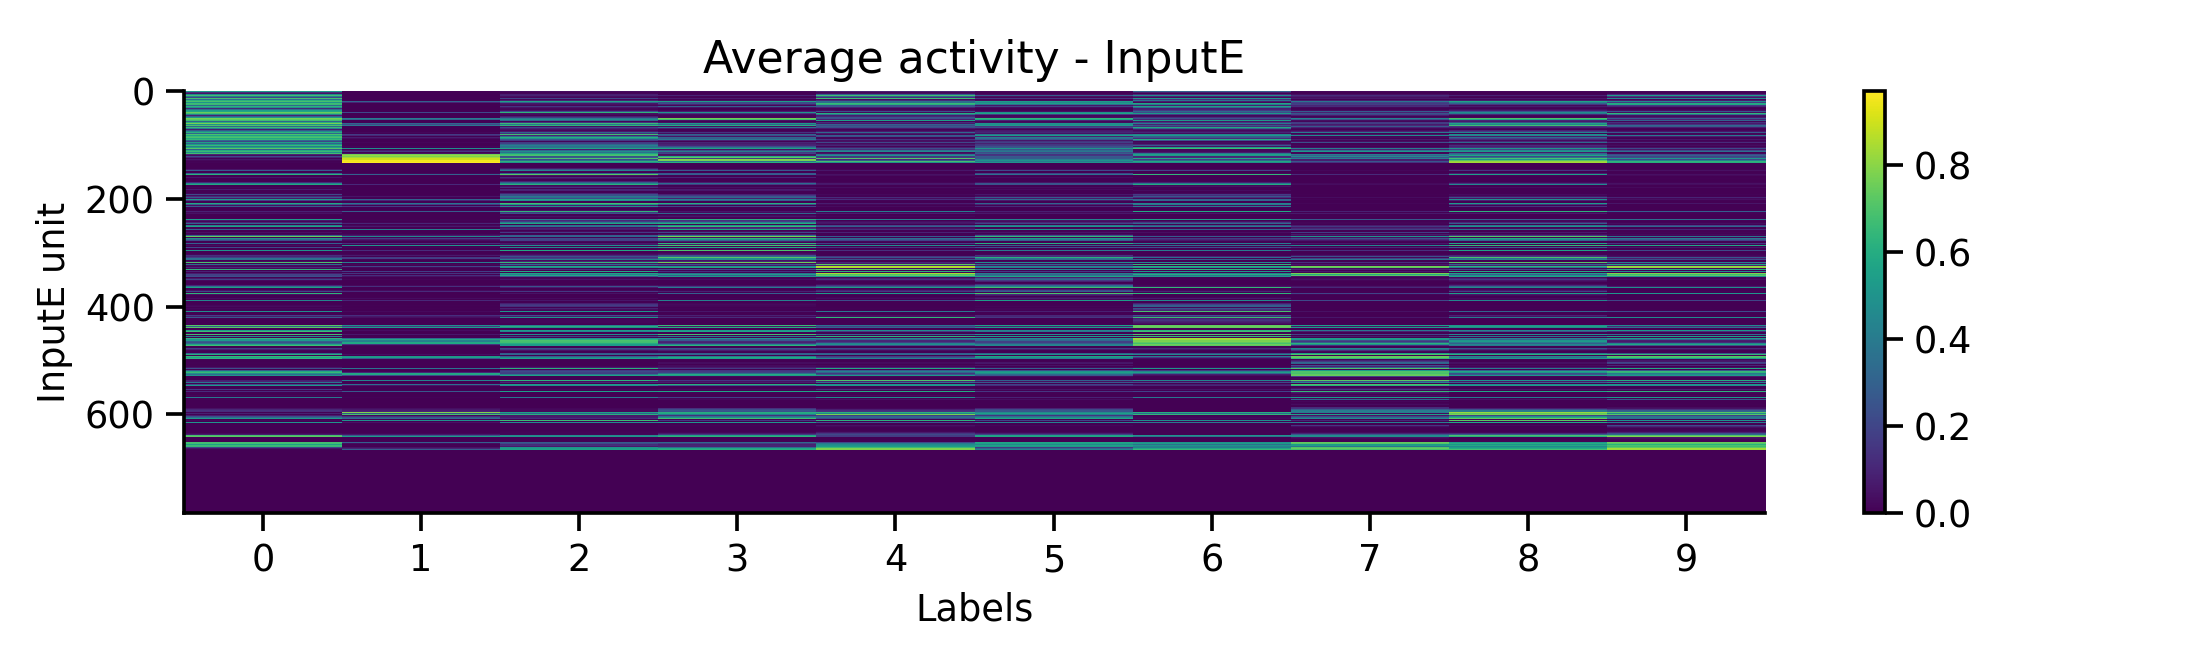

<IPython.core.display.Javascript object>


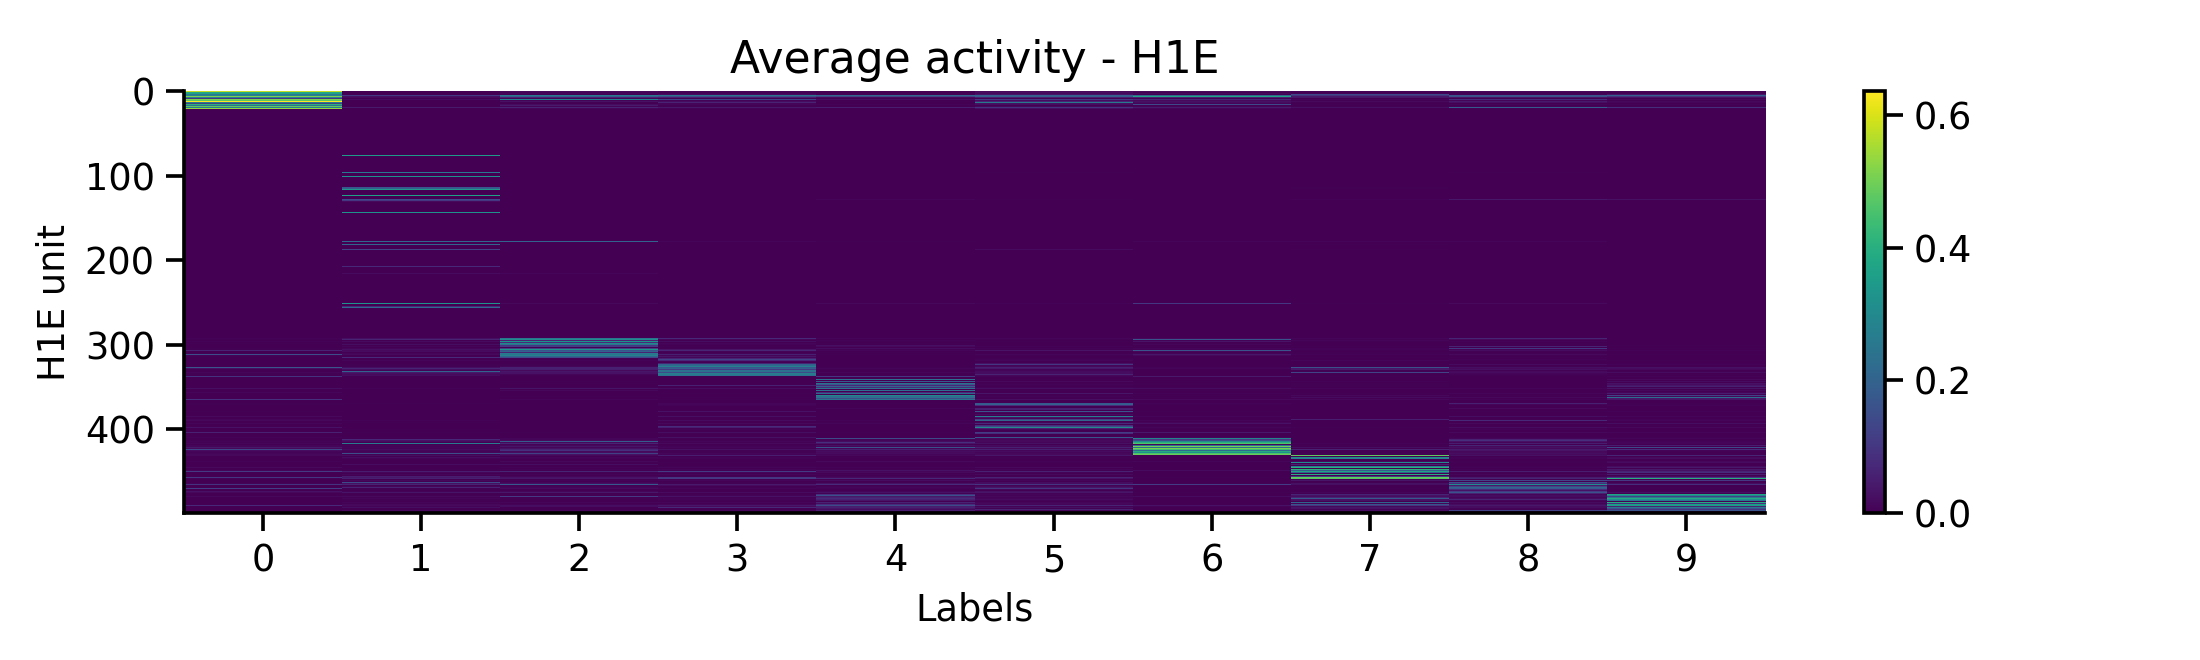

<IPython.core.display.Javascript object>


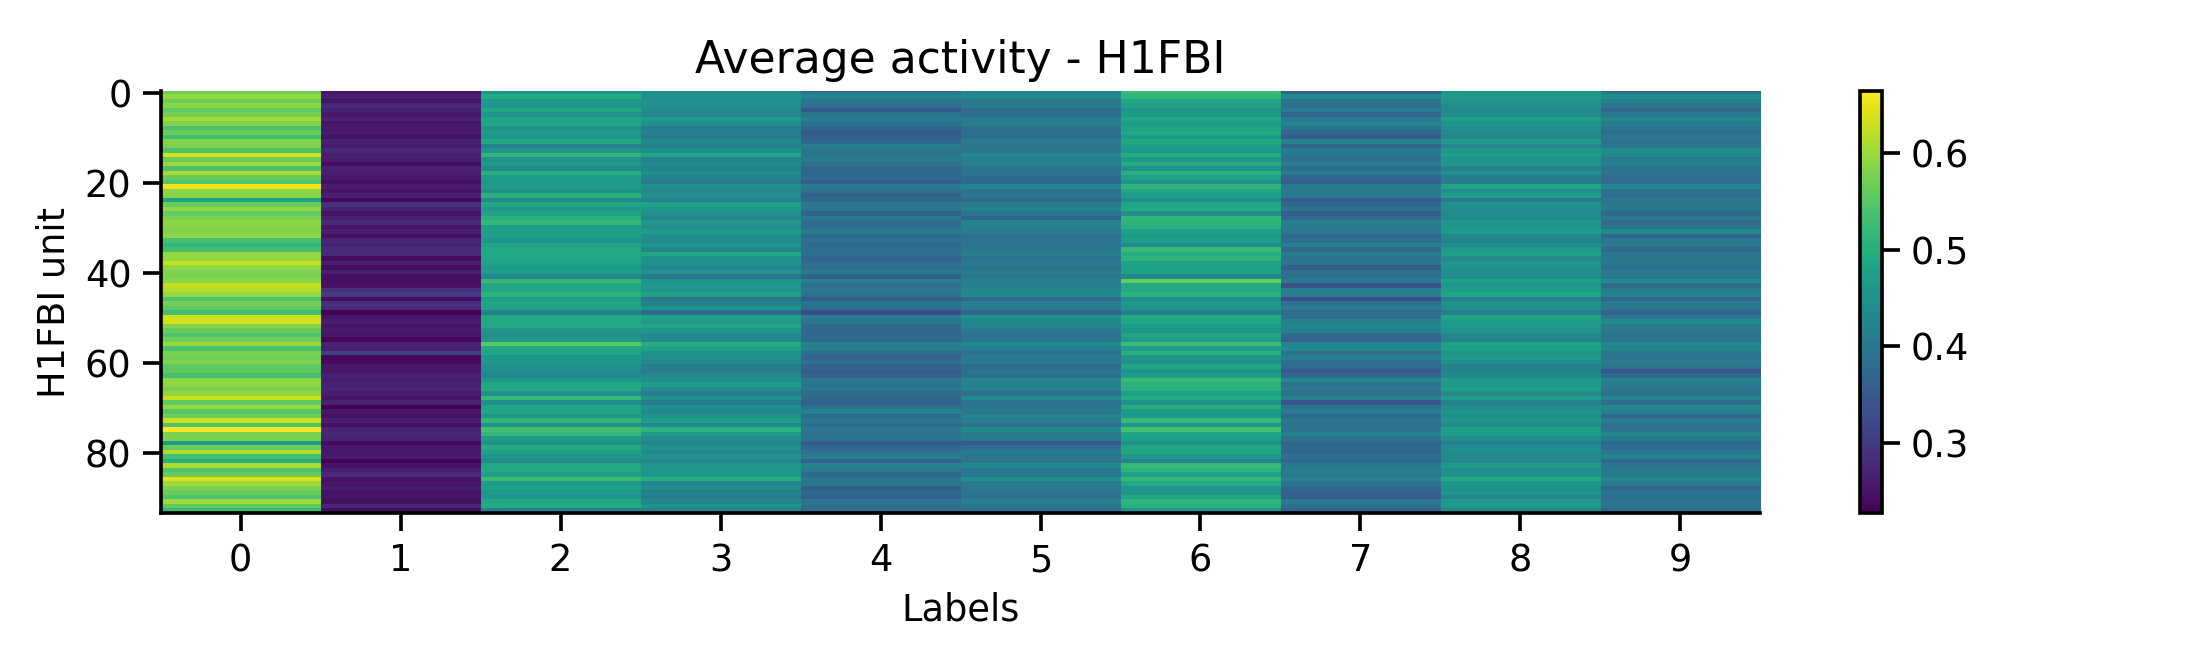

<IPython.core.display.Javascript object>


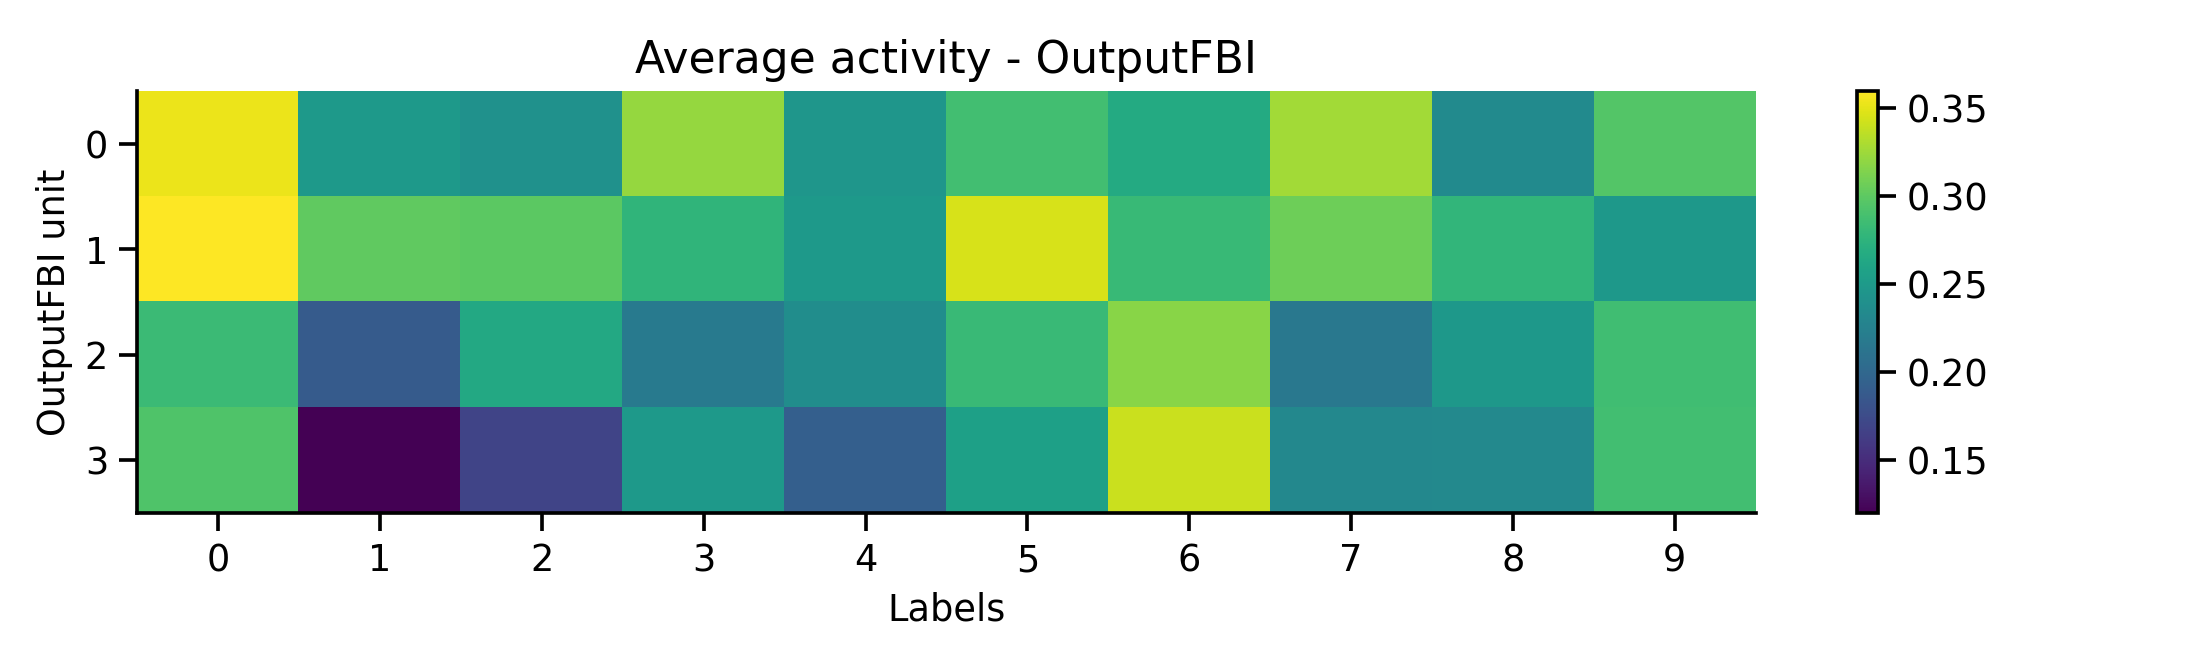

In [82]:
ep.plot_batch_accuracy(network, test_dataloader, population='all')

<IPython.core.display.Javascript object>


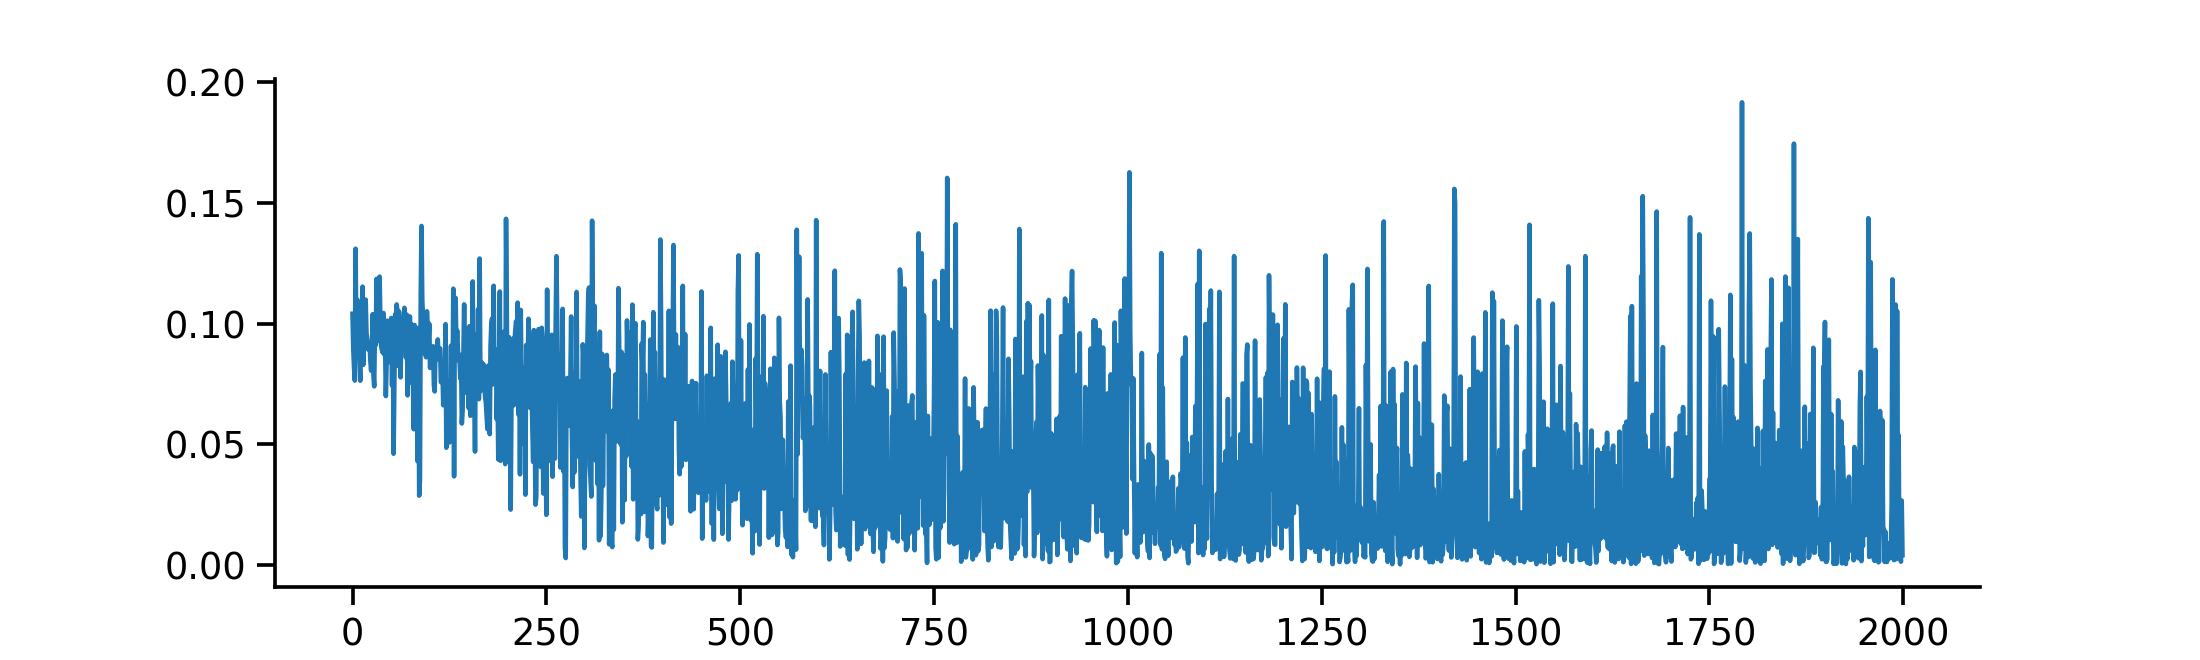

In [83]:
plt.figure()
plt.plot(network.loss_history)

<IPython.core.display.Javascript object>


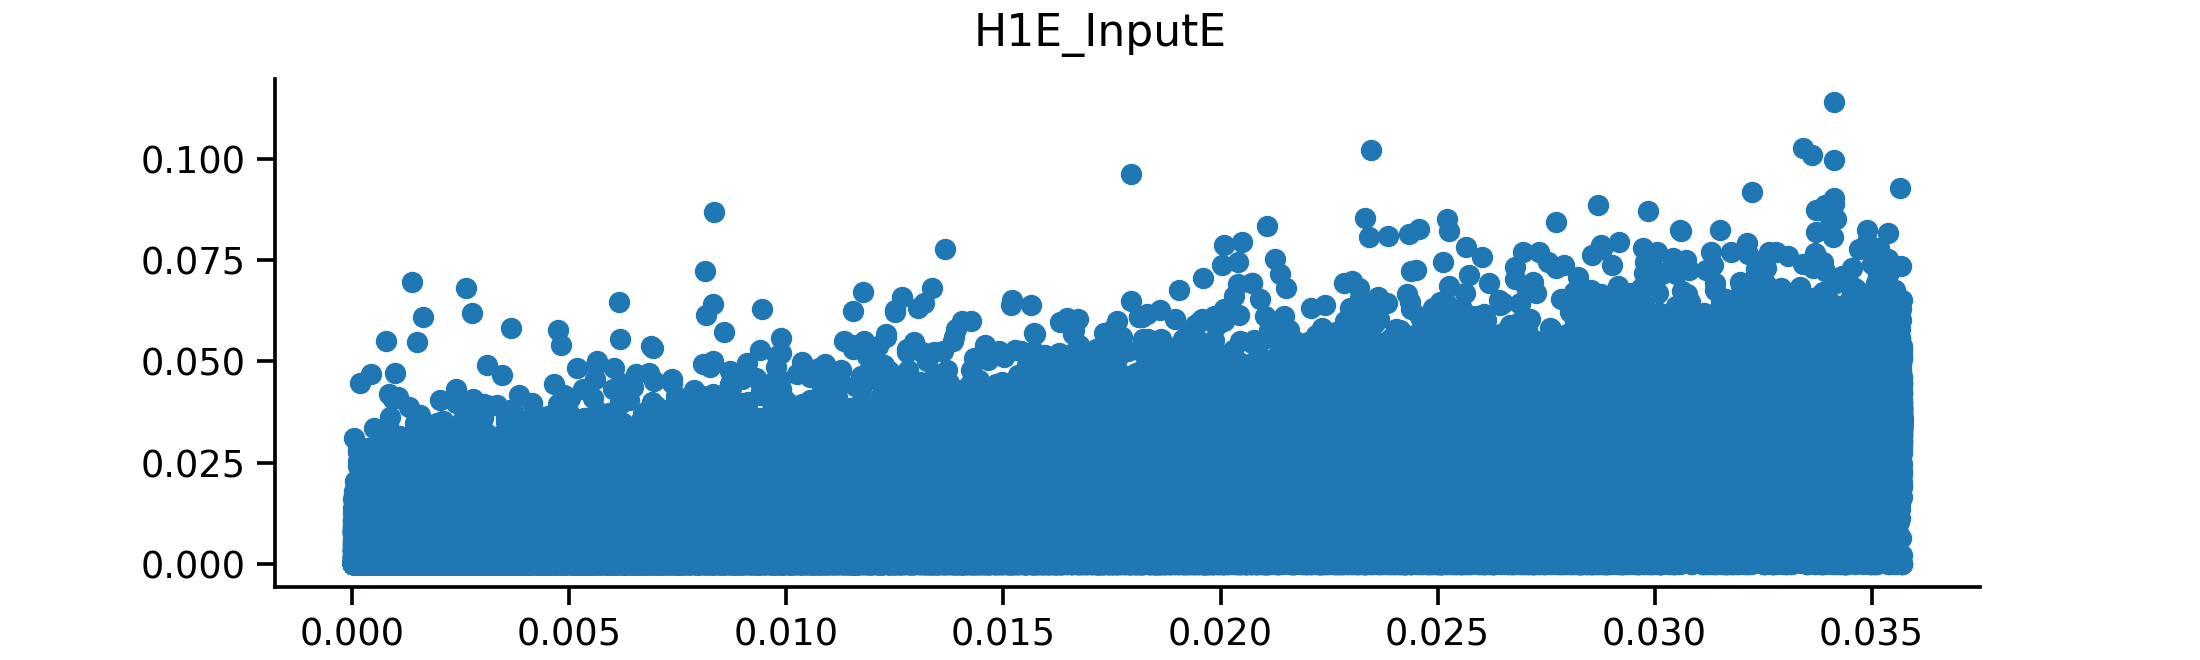

<IPython.core.display.Javascript object>


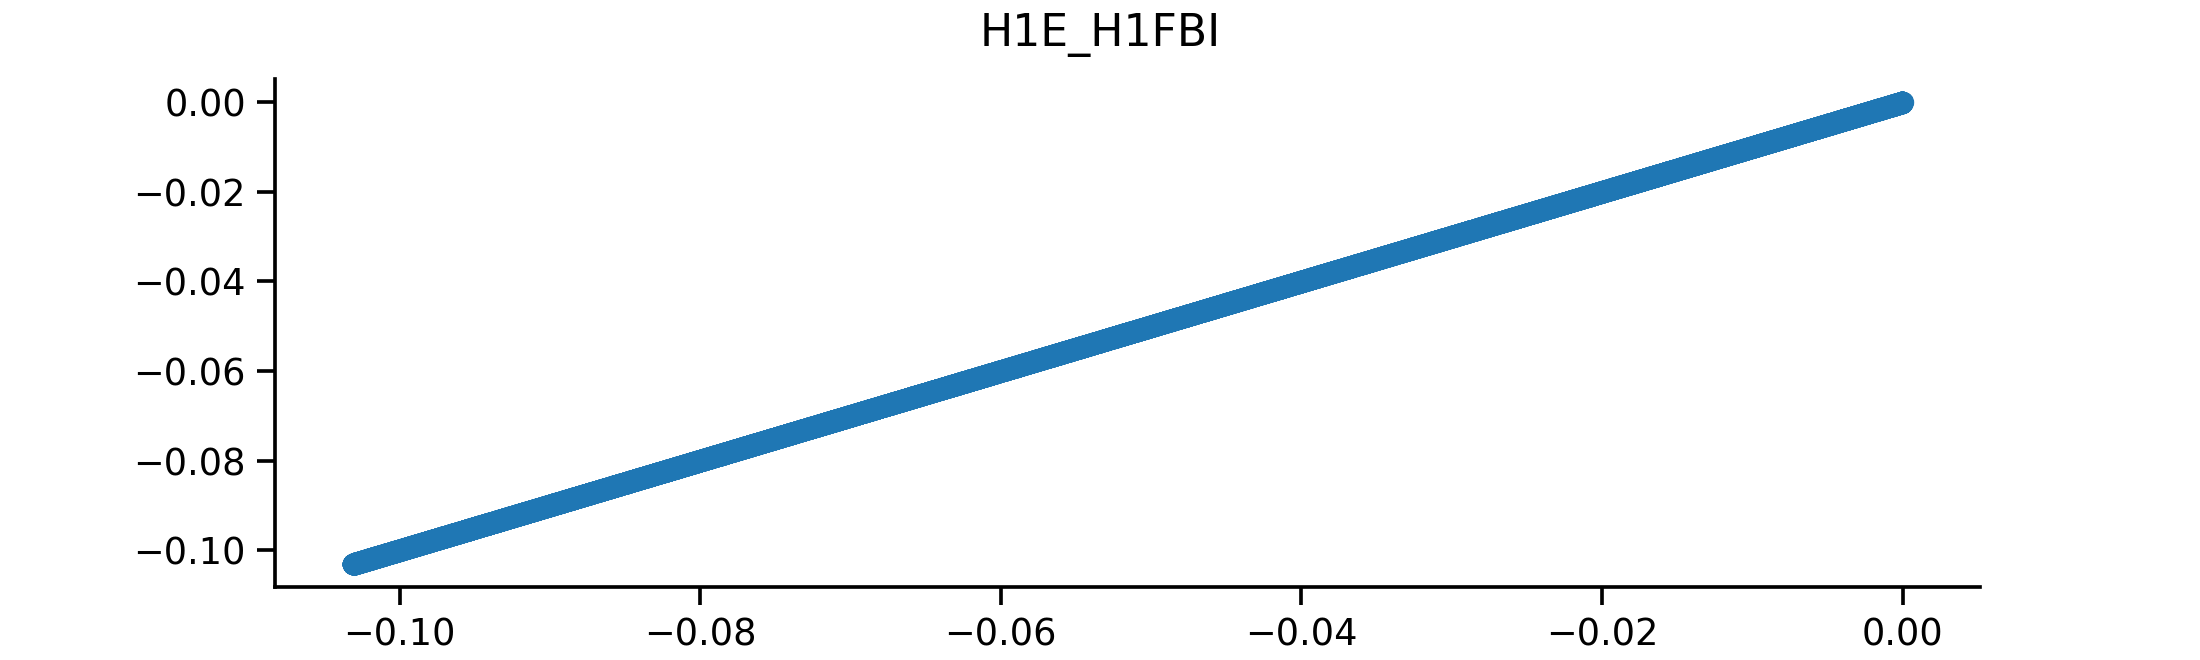

<IPython.core.display.Javascript object>


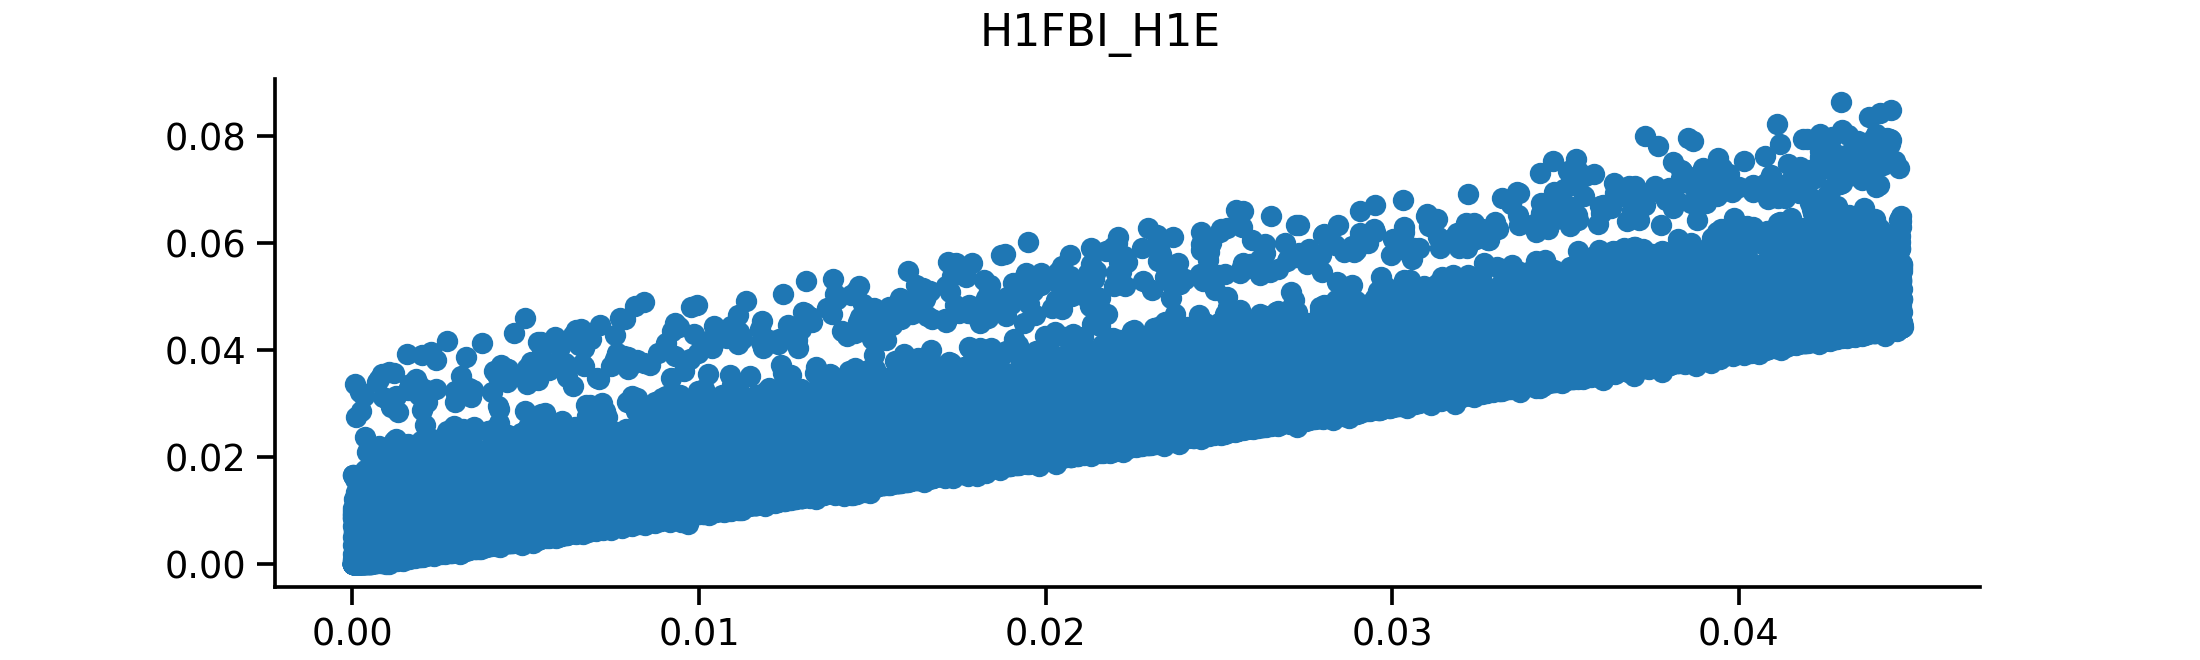

<IPython.core.display.Javascript object>


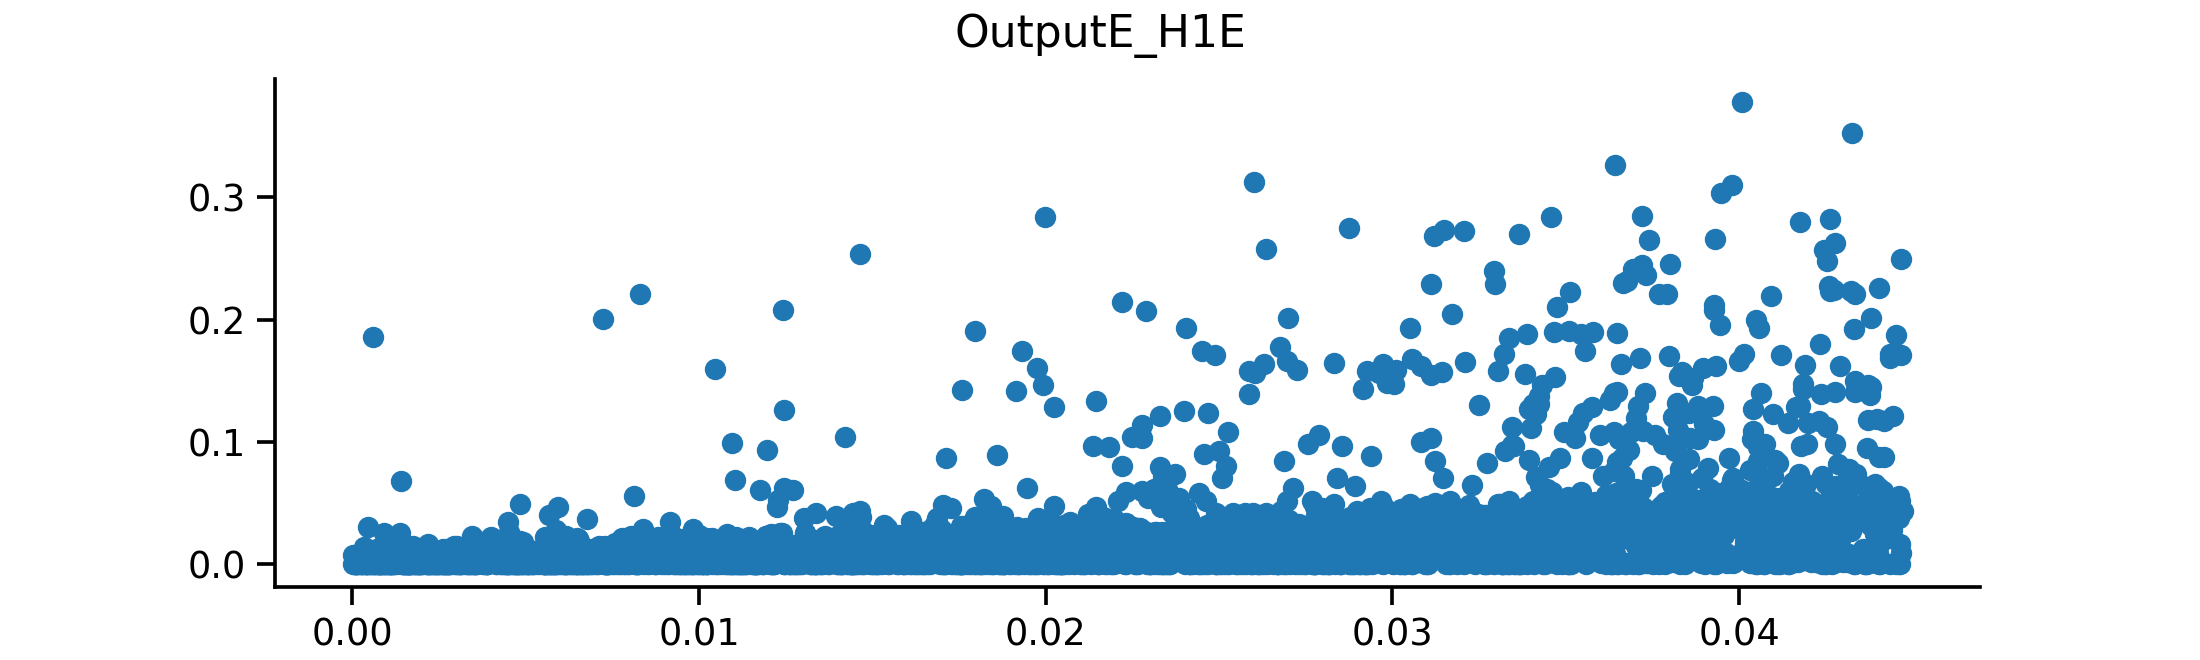

<IPython.core.display.Javascript object>


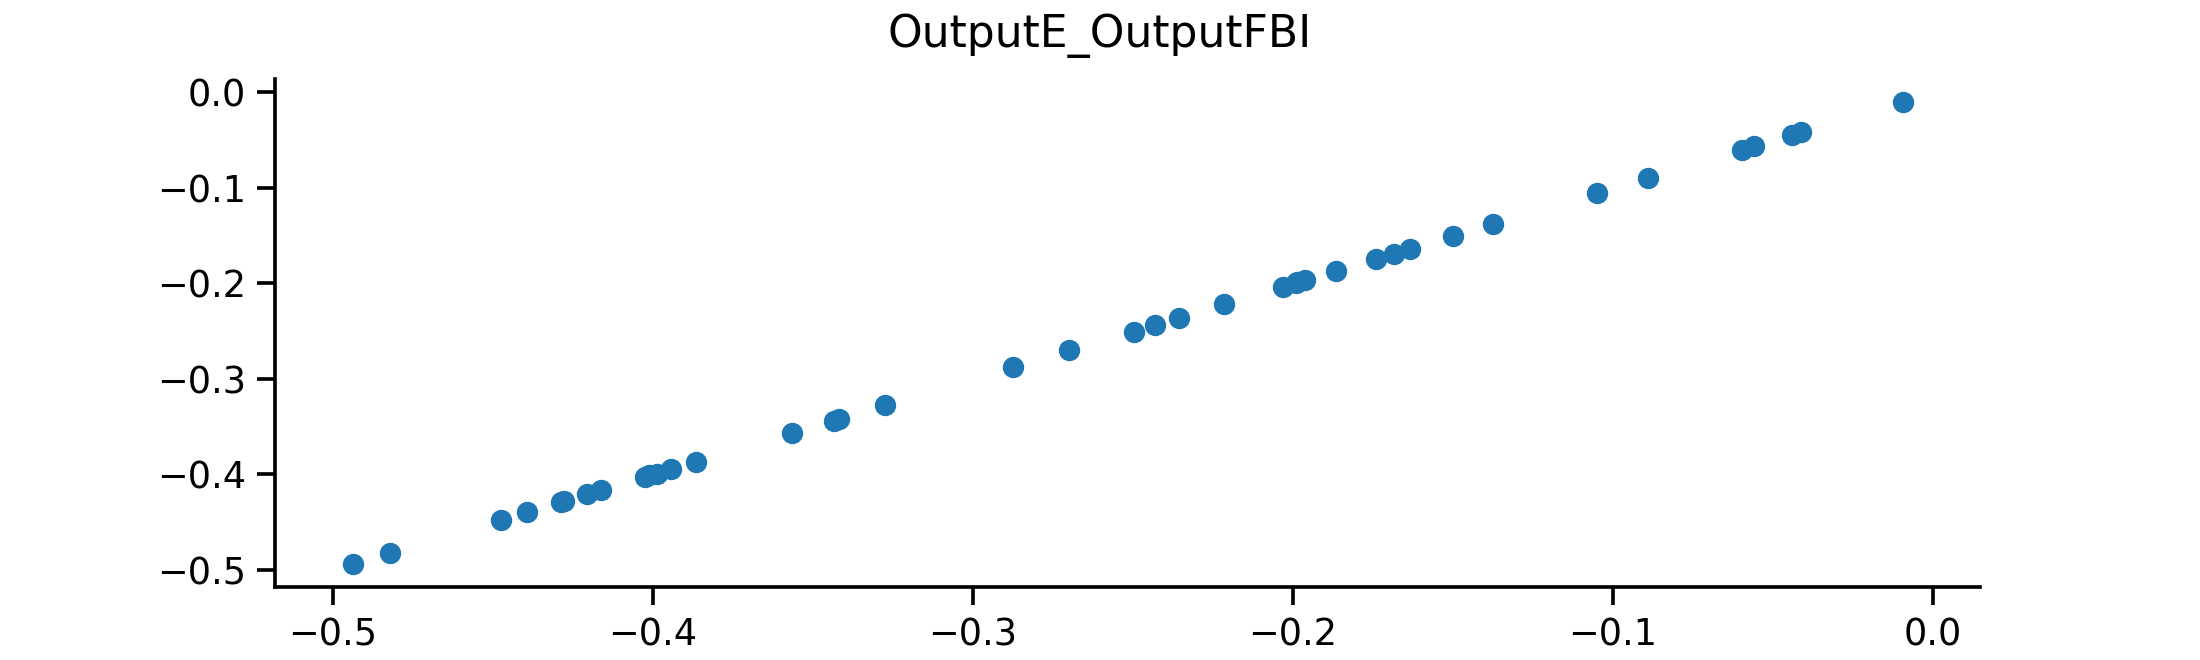

<IPython.core.display.Javascript object>


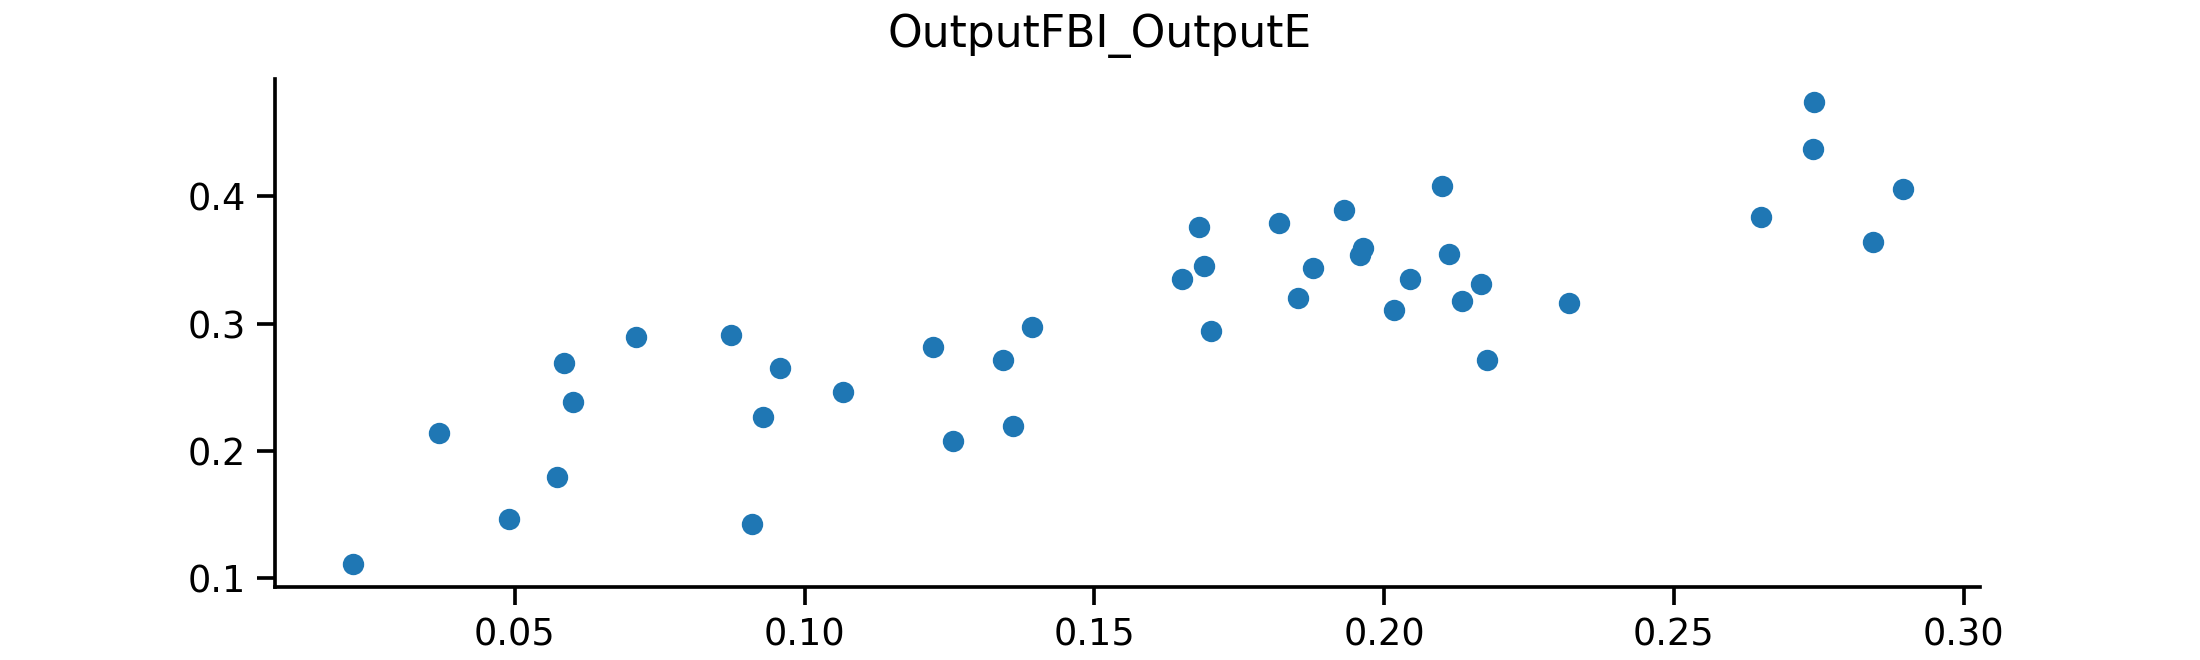

In [84]:
for layer in network:
    for population in layer:
        for projection in population:
            plt.figure()
            plt.scatter(initial_weights[projection.name].flatten(), projection.weight.data.detach().flatten())
            plt.suptitle(projection.name)

## Backprop (Dale) - 2 hidden

In [82]:
# network_config = ut.read_from_yaml('../config/MNIST/20230316_EIANN_2_hidden_mnist_bpDale_softplus_SGD_config_B.yaml')
# pprint(network_config, sort_dicts=False)

E_E_learning_rate = 0.5
I_E_learning_rate = 0.01
E_I_learning_rate = 0.01

network_config = {'layer_config': {'Input': {'E': {'size': 784}},
                  'H1': {'E': {'size': 500,
                               'activation': 'softplus',
                               'activation_kwargs': {'beta': 100.0}
                              },
                         'FBI': {'size': 50,
                                 'activation': 'softplus',
                                 'activation_kwargs': {'beta': 100.0}
                              },
                        },
                  'H2': {'E': {'size': 500,
                               'activation': 'softplus',
                               'activation_kwargs': {'beta': 100.0}
                              },
                         'FBI': {'size': 50,
                                 'activation': 'softplus',
                                 'activation_kwargs': {'beta': 100.0}
                              },
                        },
                  'Output': {'E': {'size': 10,
                                   'activation': 'softplus',
                                   'activation_kwargs': {'beta': 100.0}
                              },
                             'FBI': {'size': 10,
                                     'activation': 'softplus',
                                     'activation_kwargs': {'beta': 100.0}
                              },
                            }},
 'projection_config': {'H1': {'E': {'Input': {'E': {'weight_init': 'half_kaining',
                                                    'weight_init_args': (1.0,),
                                                    'weight_bounds': [0, None],
                                                    'direction': 'F',
                                                    'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_E_learning_rate}
                                                   }},
                                    'H1': {'FBI': {'weight_init': 'half_kaining',
                                                   'weight_init_args': (1,),
                                                   'weight_bounds': [None, 0],
                                                   'direction': 'R',
                                                   'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_I_learning_rate}
                                                  }}},
                              'FBI': {'H1': {'E': {'weight_init': 'half_kaining',
                                                   'weight_init_args': (1,),
                                                   'weight_bounds': [0, None],
                                                   'direction': 'F',
                                                   'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': I_E_learning_rate}
                                                  }}}},
                       'H2': {'E': {'H1': {'E': {'weight_init': 'half_kaining',
                                                 'weight_init_args': (1.5,),
                                                 'weight_bounds': [0, None],
                                                 'direction': 'F',
                                                 'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_E_learning_rate}
                                                }},
                                    'H2': {'FBI': {'weight_init': 'half_kaining',
                                                   'weight_init_args': (0.1,),
                                                   'weight_bounds': [None, 0],
                                                   'direction': 'R',
                                                   'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_I_learning_rate}
                                                  }}},
                              'FBI': {'H2': {'E': {'weight_init': 'half_kaining',
                                                   'weight_init_args': (0.1,),
                                                   'weight_bounds': [0, None],
                                                   'direction': 'F',
                                                   'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': I_E_learning_rate}
                                                  }}}},
                       'Output': {'E': {'H2': {'E': {'weight_init': 'half_kaining',
                                                     'weight_init_args': (1.5,),
                                                     'weight_bounds': [0, None],
                                                     'direction': 'F',
                                                     'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_E_learning_rate}
                                                    }},
                                        'Output': {'FBI': {'weight_init': 'half_kaining',
                                                           'weight_init_args': (0.1,),
                                                           'weight_bounds': [None,
                                                                             0],
                                                           'direction': 'R',
                                                           'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': E_I_learning_rate}
                                                          }}},
                                  'FBI': {'Output': {'E': {'weight_init': 'half_kaining',
                                                           'weight_init_args': (0.1,),
                                                           'weight_bounds': [0,
                                                                             None],
                                                           'direction': 'F',
                                                           'learning_rule': 'Backprop',
                                                    'learning_rule_kwargs':
                                                        {'learning_rate': I_E_learning_rate}
                                                          }}}}},
 'training_kwargs': {'tau': 3,
                     'forward_steps': 10,
                     'backward_steps': 3,
                     'learning_rate': .5,
                     'verbose': False,
                     'optimizer': 'SGD'}}
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

Batch accuracy = 9.739999771118164%


<IPython.core.display.Javascript object>


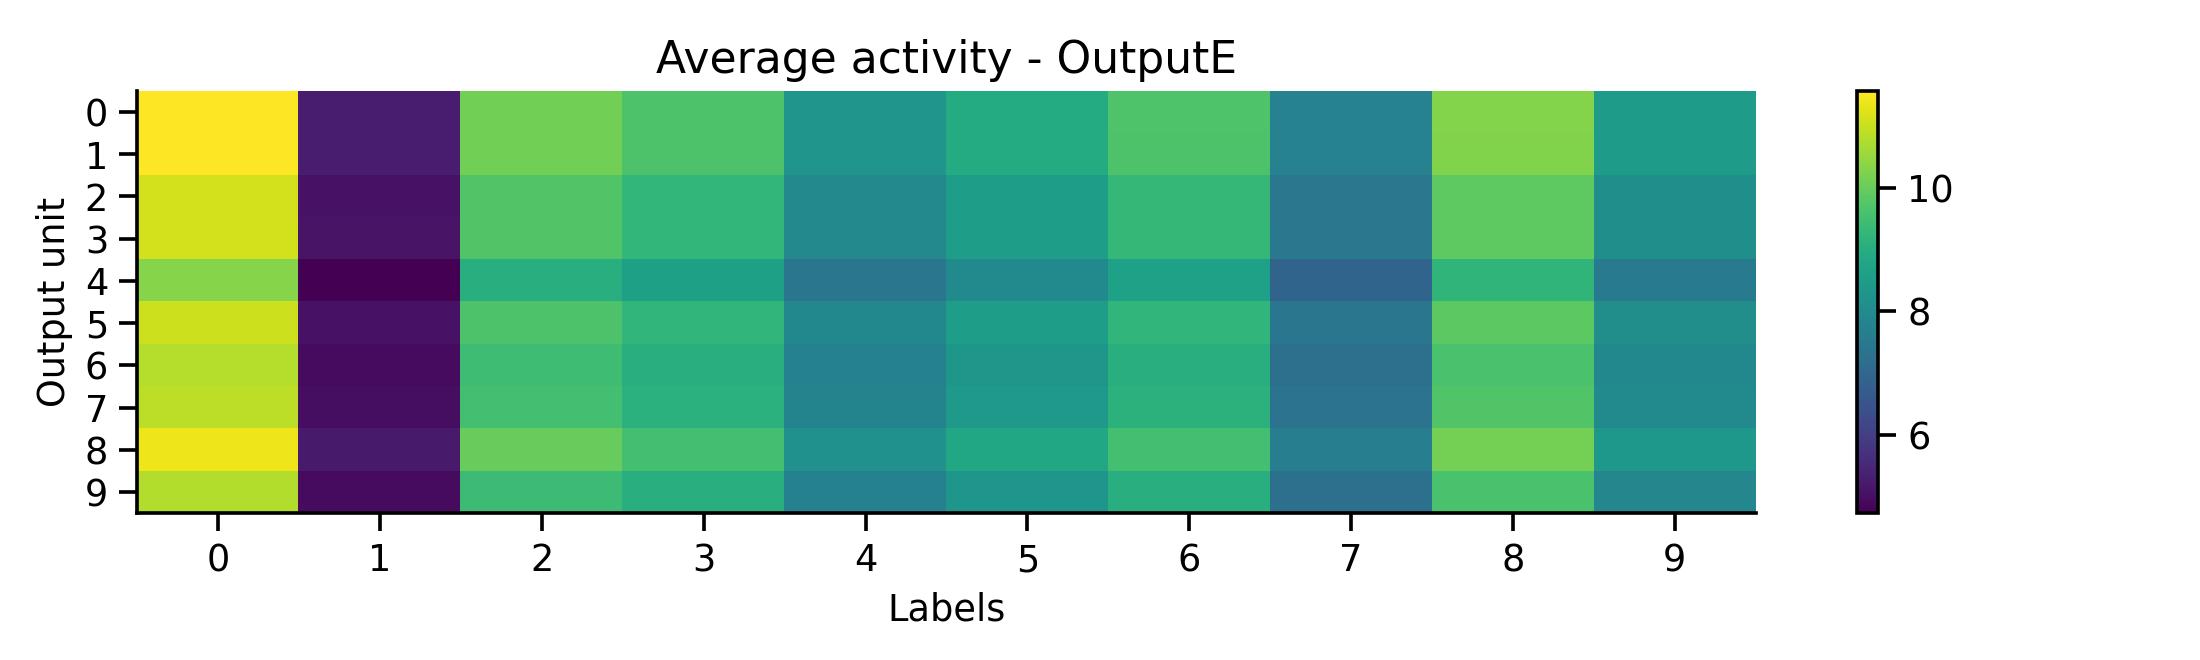

<IPython.core.display.Javascript object>


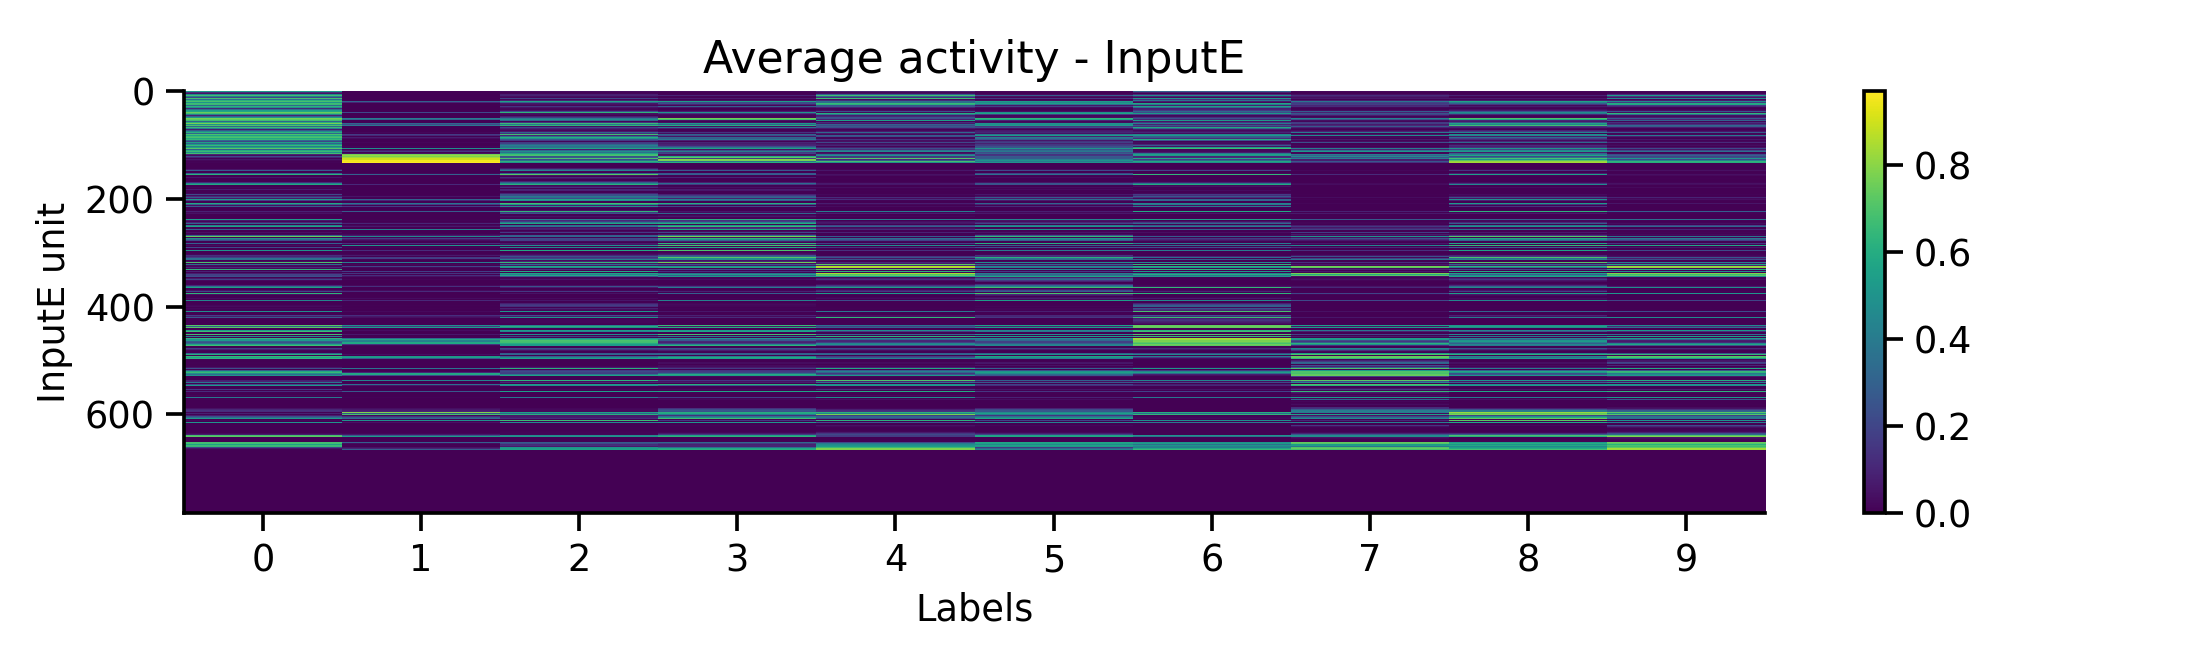

<IPython.core.display.Javascript object>


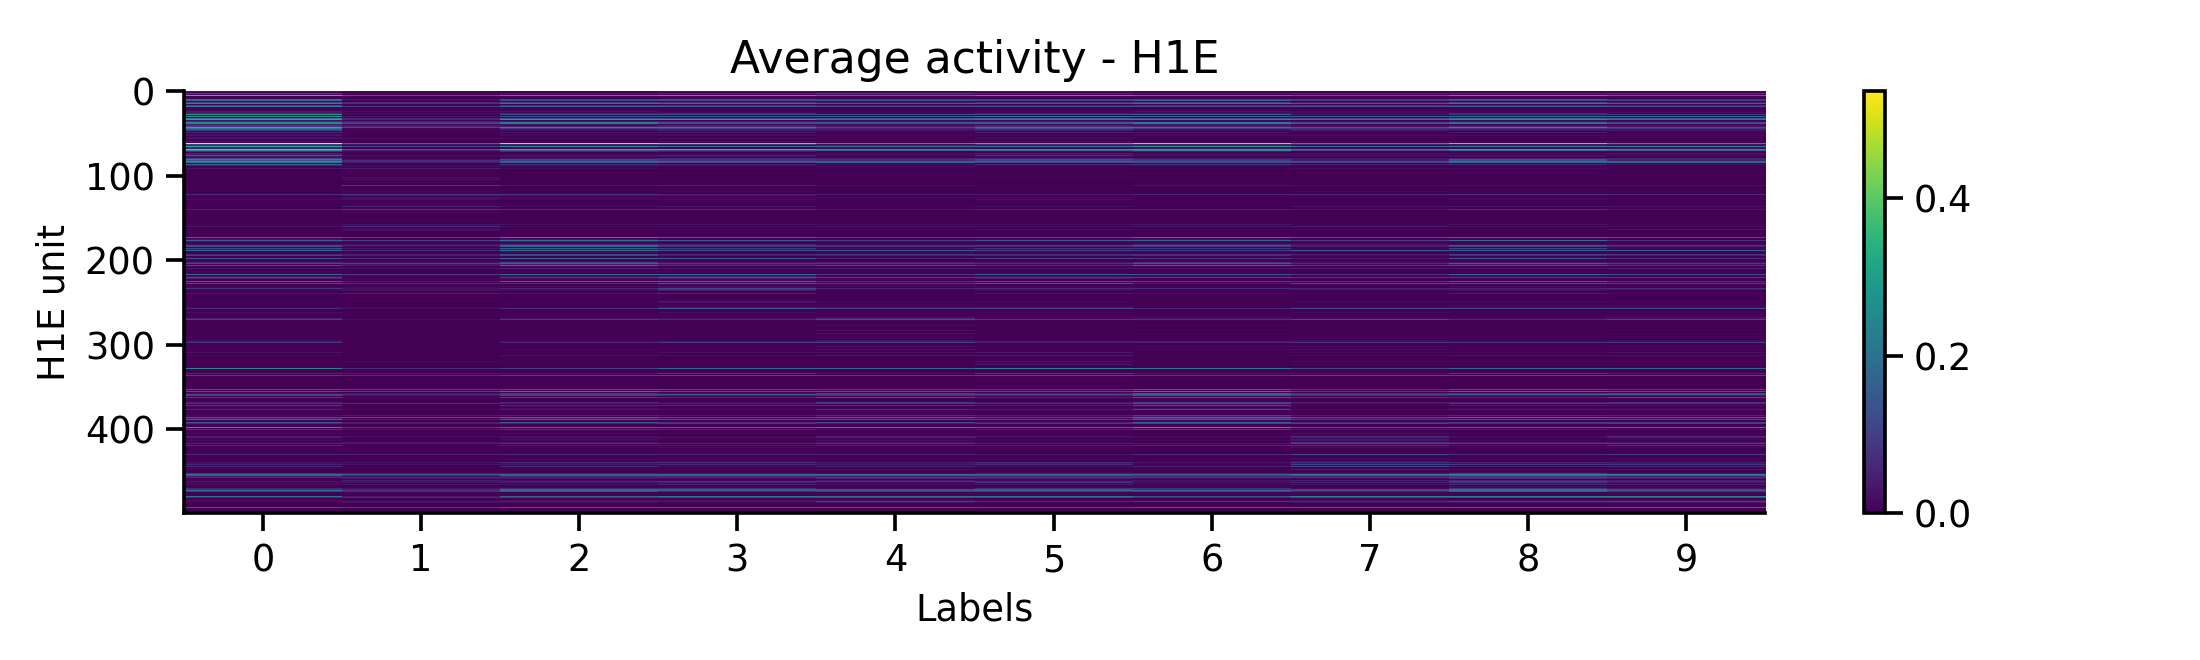

<IPython.core.display.Javascript object>


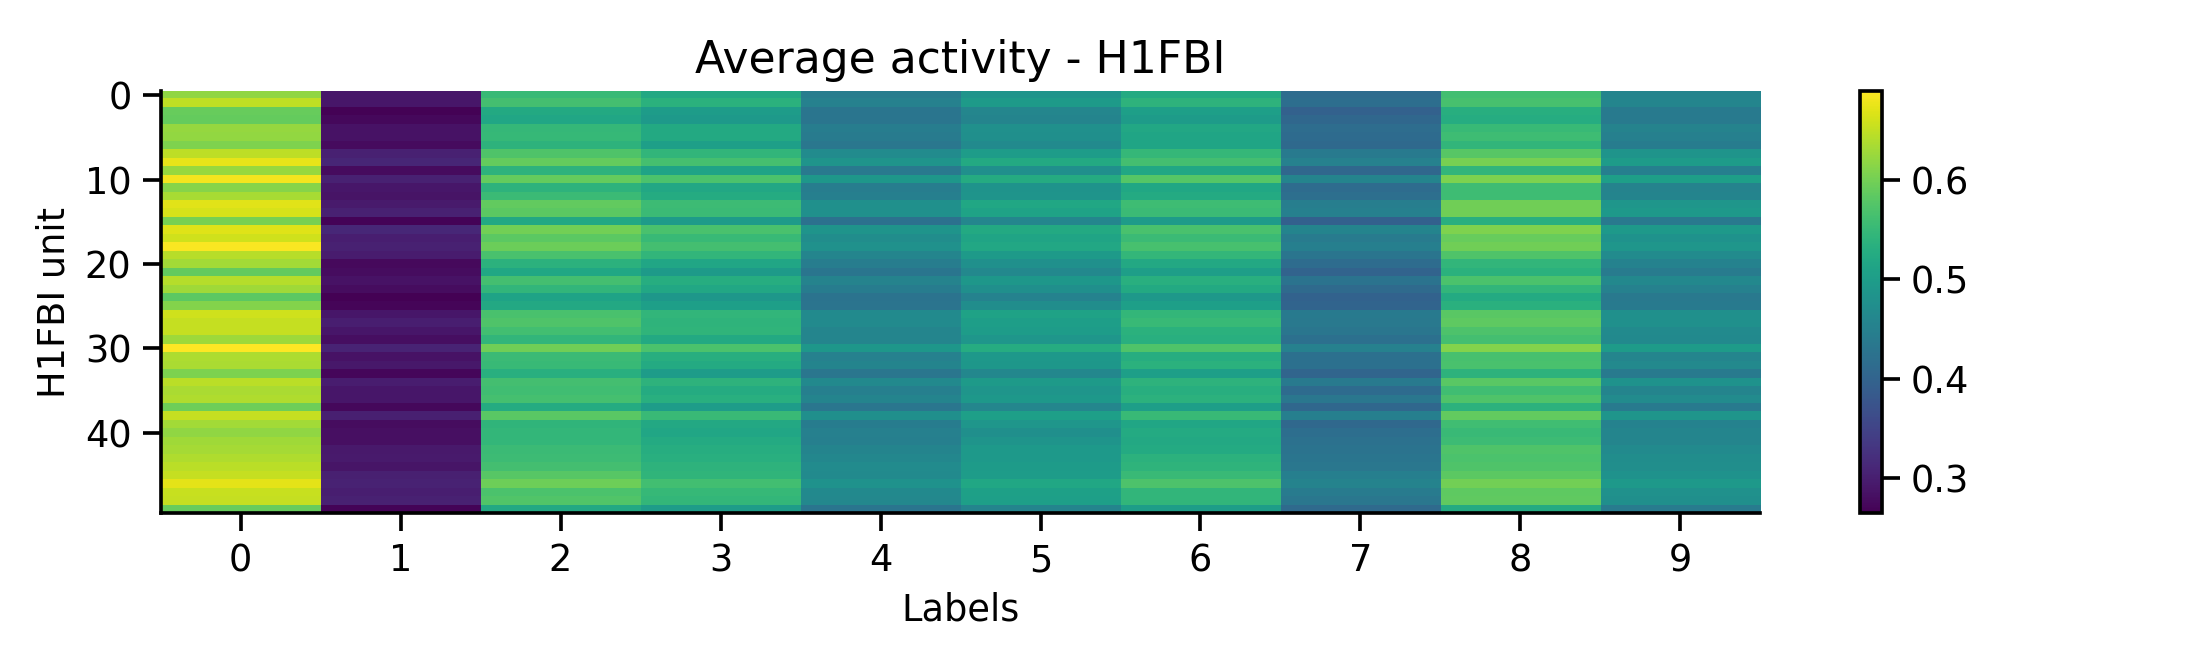

<IPython.core.display.Javascript object>


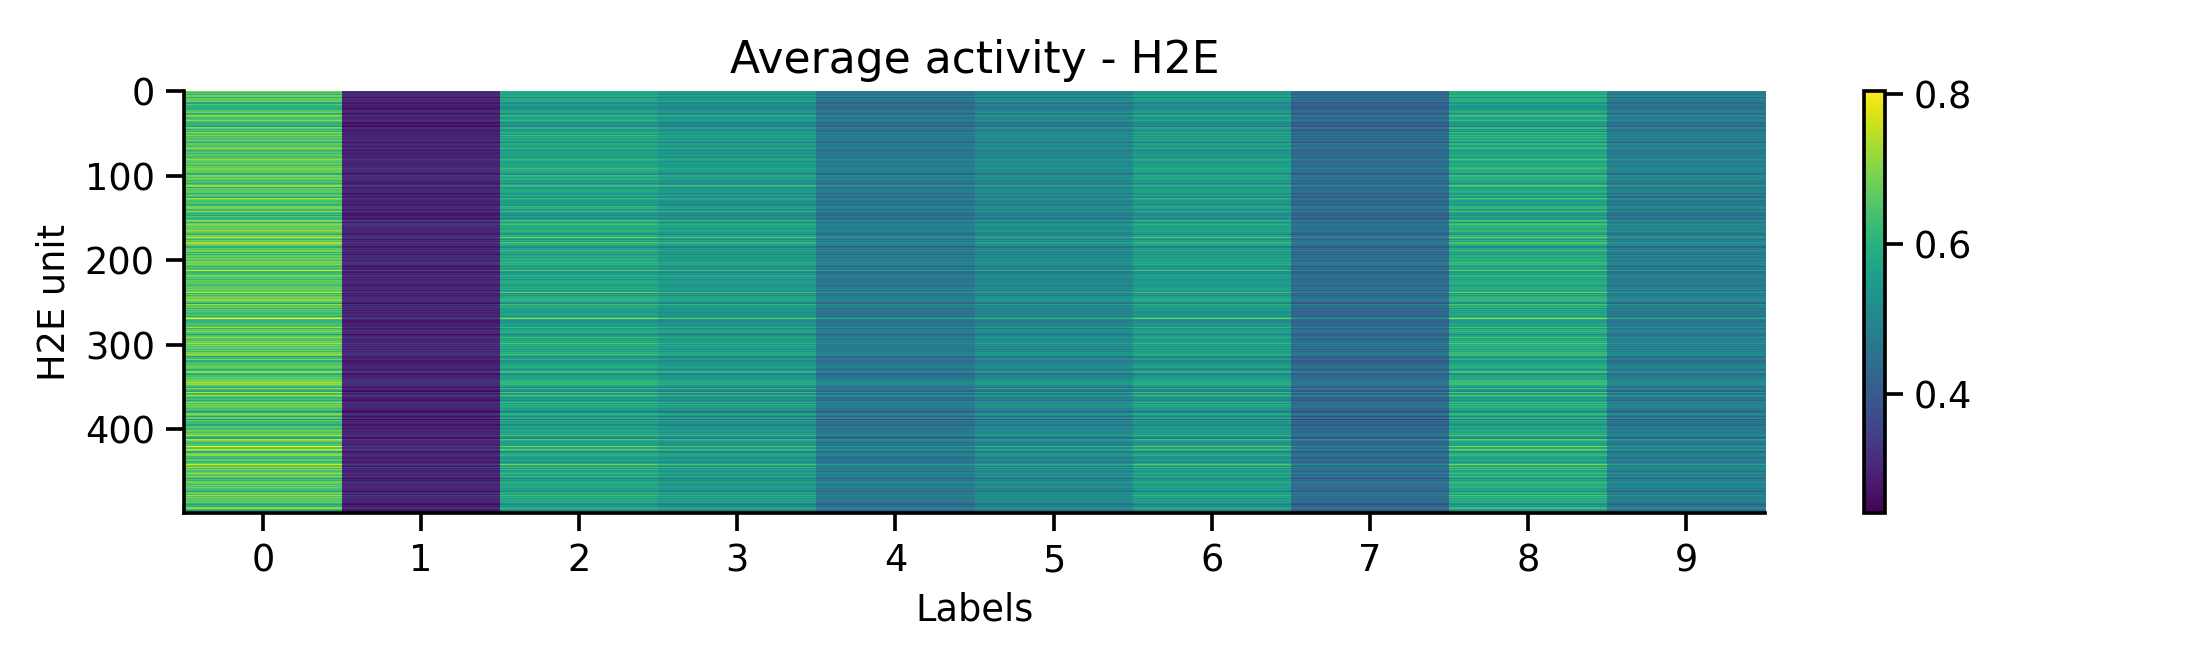

<IPython.core.display.Javascript object>


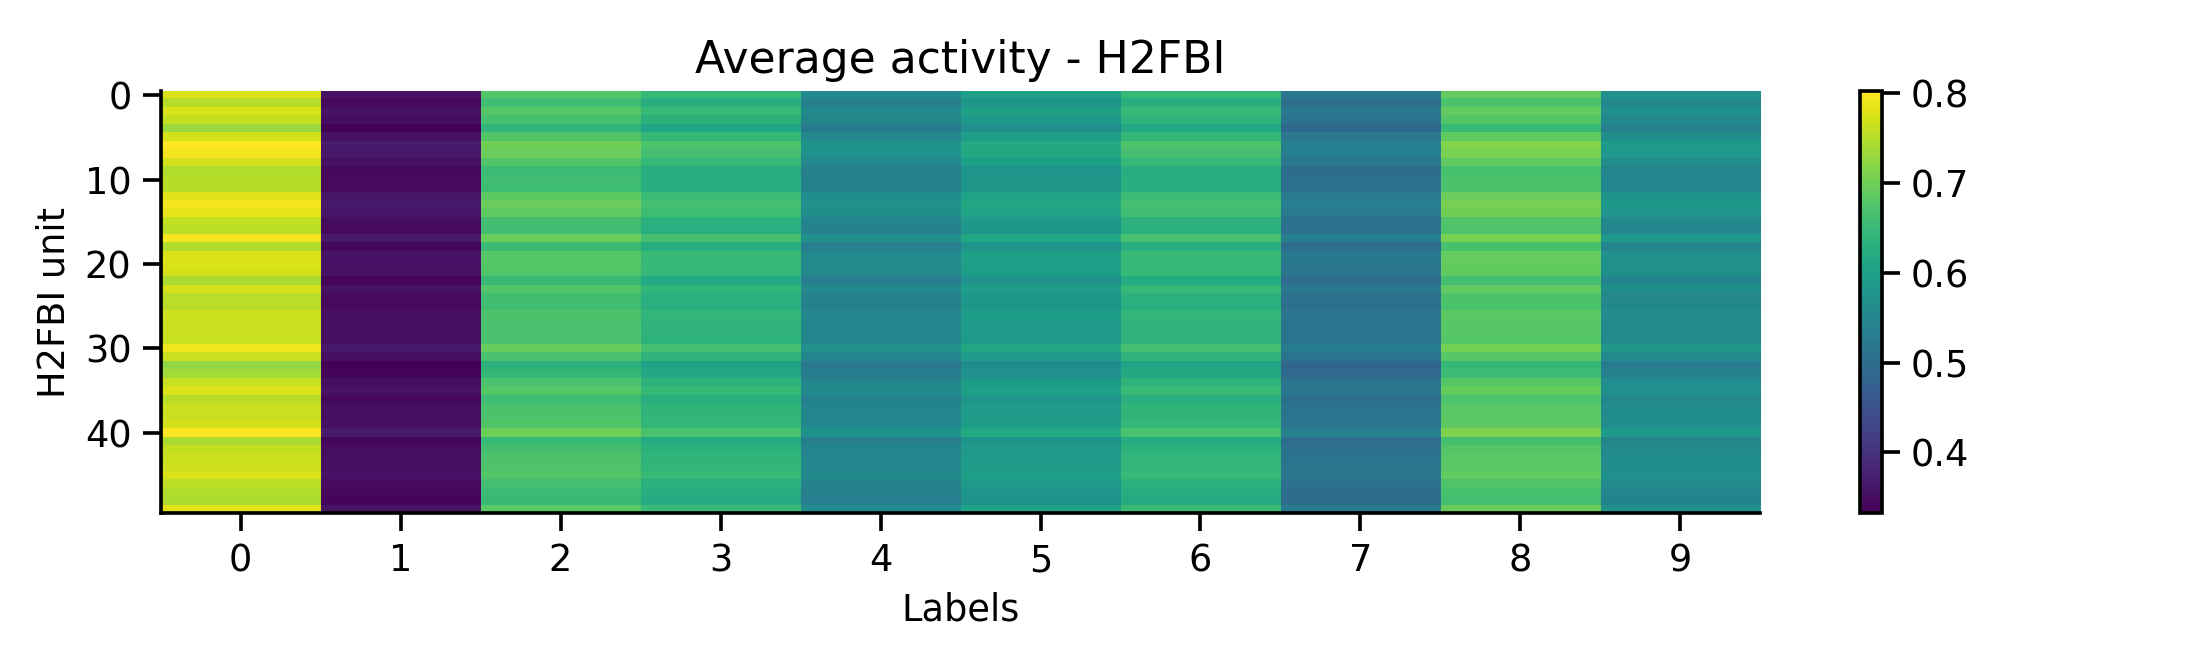

<IPython.core.display.Javascript object>


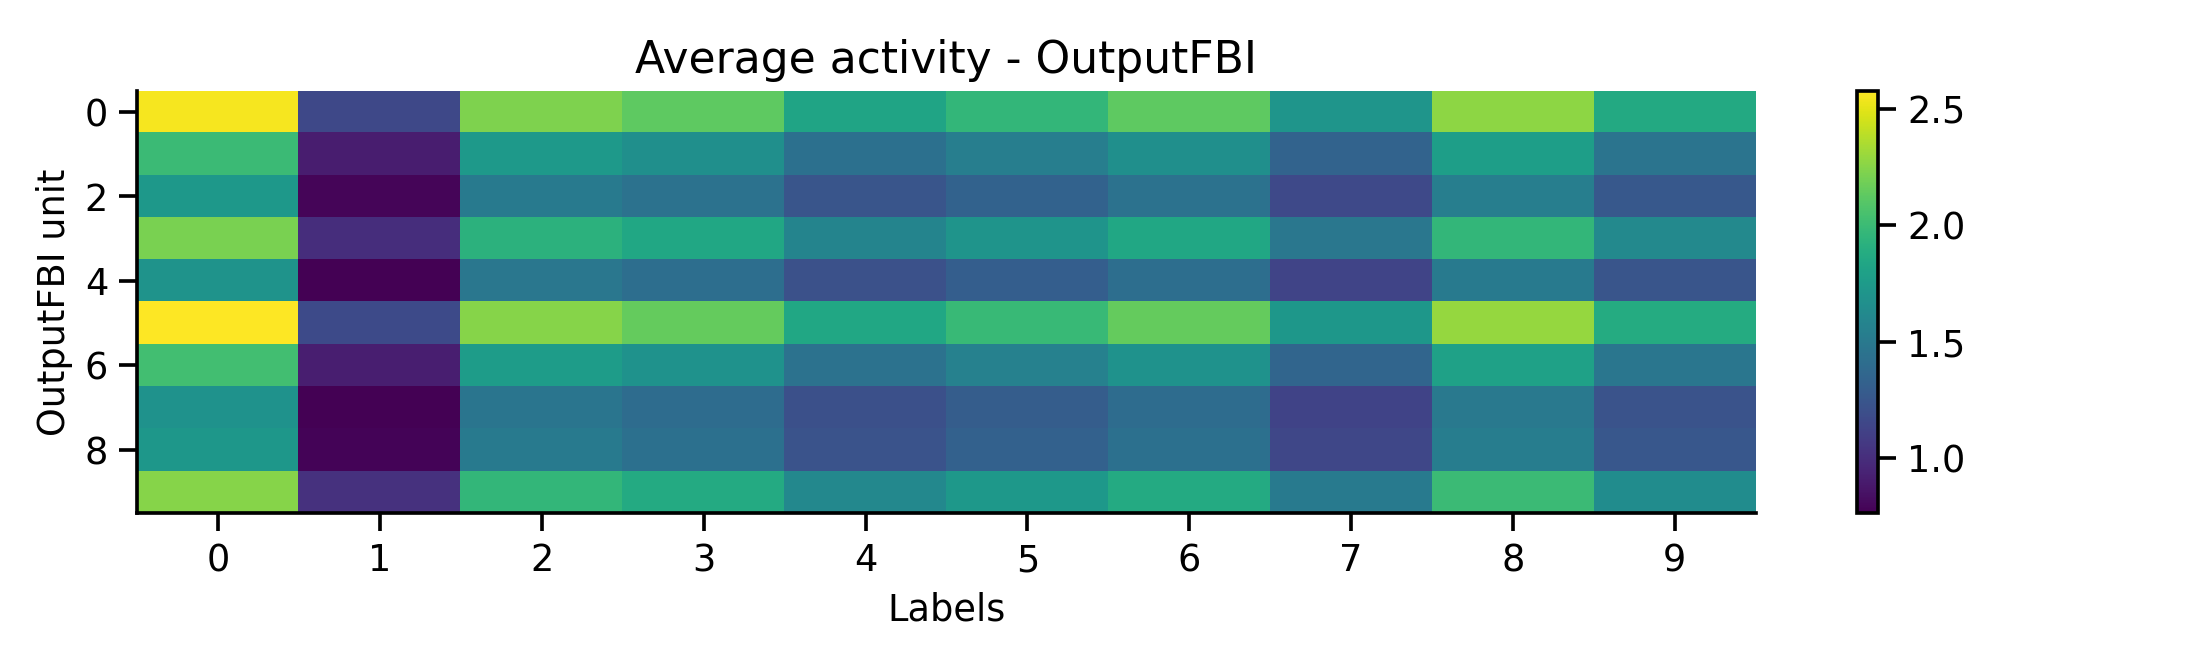

In [83]:
ep.plot_batch_accuracy(network, test_dataloader, population='all')

In [63]:
initial_weights_2_hidden = {}
for layer in network:
    for population in layer:
        for projection in population:
            initial_weights_2_hidden[projection.name] = projection.weight.data.detach().clone()

<IPython.core.display.Javascript object>


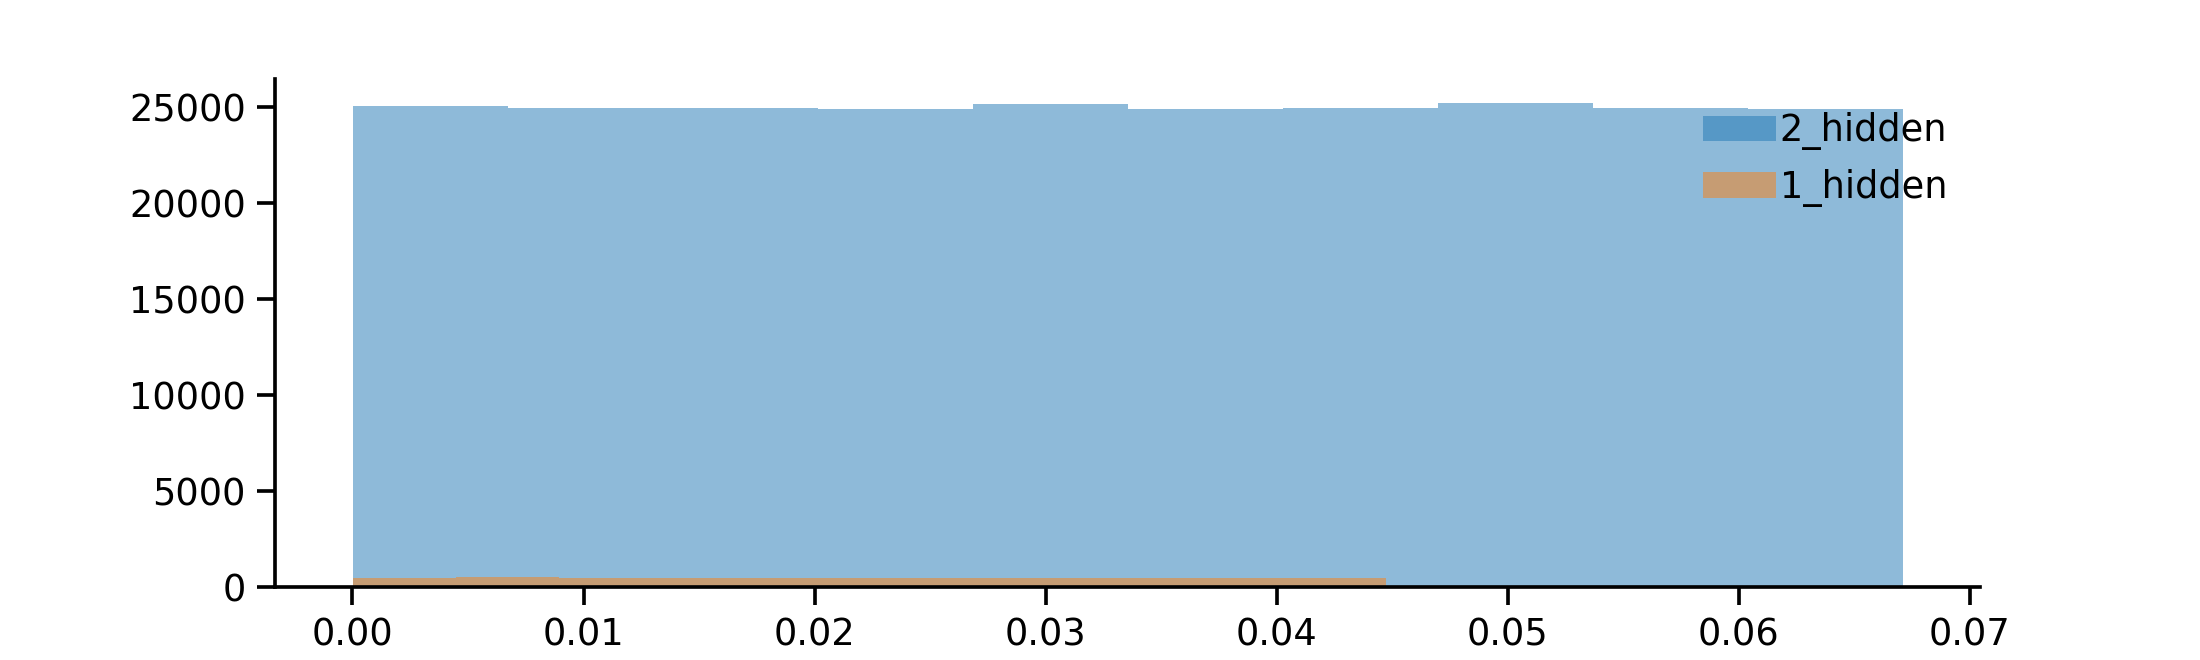

In [64]:
plt.figure()
plt.hist(initial_weights_2_hidden['H2E_H1E'].flatten(), alpha=0.5, label='2_hidden')
plt.hist(initial_weights_1_hidden['OutputE_H1E'].flatten(), alpha=0.5, label='1_hidden')
plt.legend(loc='best', frameon=False)
plt.show()

In [79]:
network.reset_history()
data_generator.manual_seed(data_seed)
network.train(train_sub_dataloader, 
              epochs=1, 
              store_history=True, 
              status_bar=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0063)

Batch accuracy = 34.36000061035156%


<IPython.core.display.Javascript object>


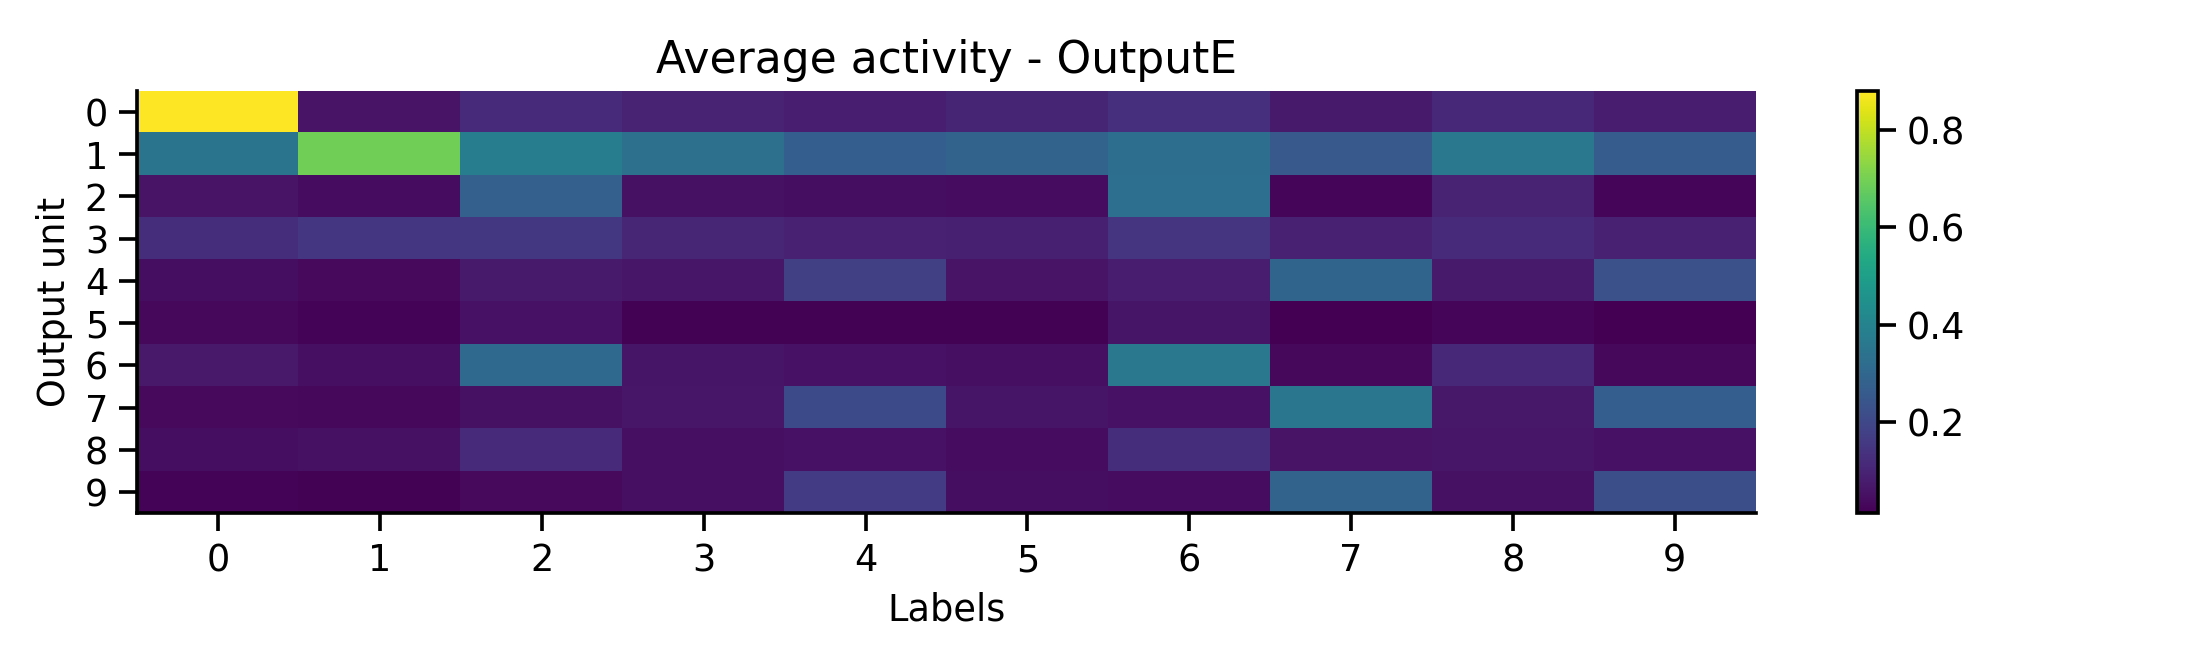

<IPython.core.display.Javascript object>


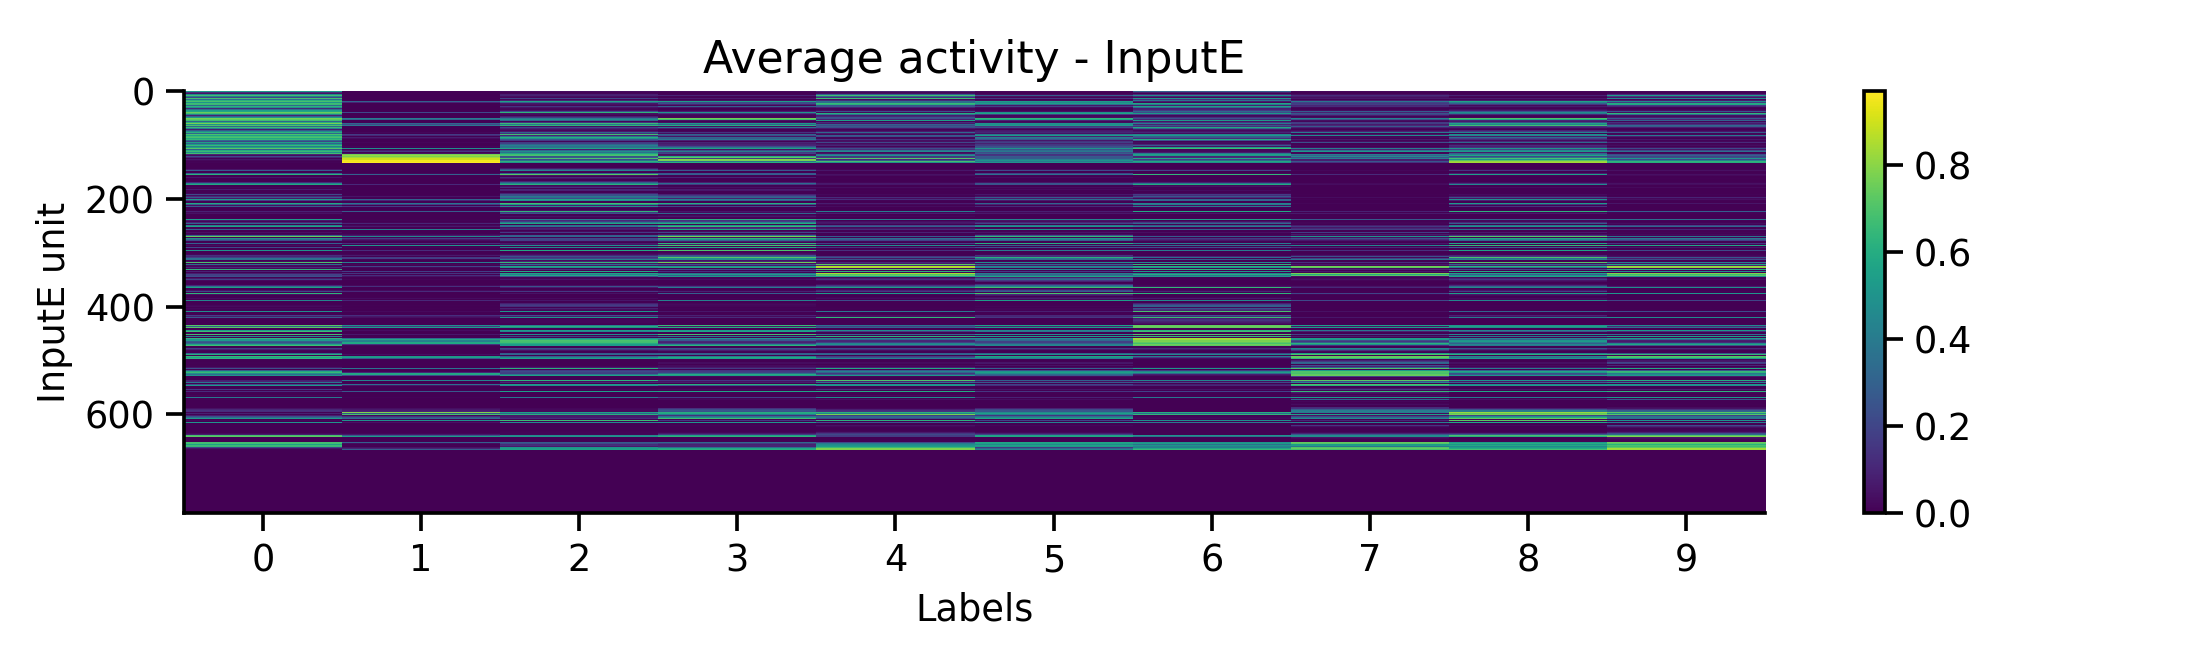

<IPython.core.display.Javascript object>


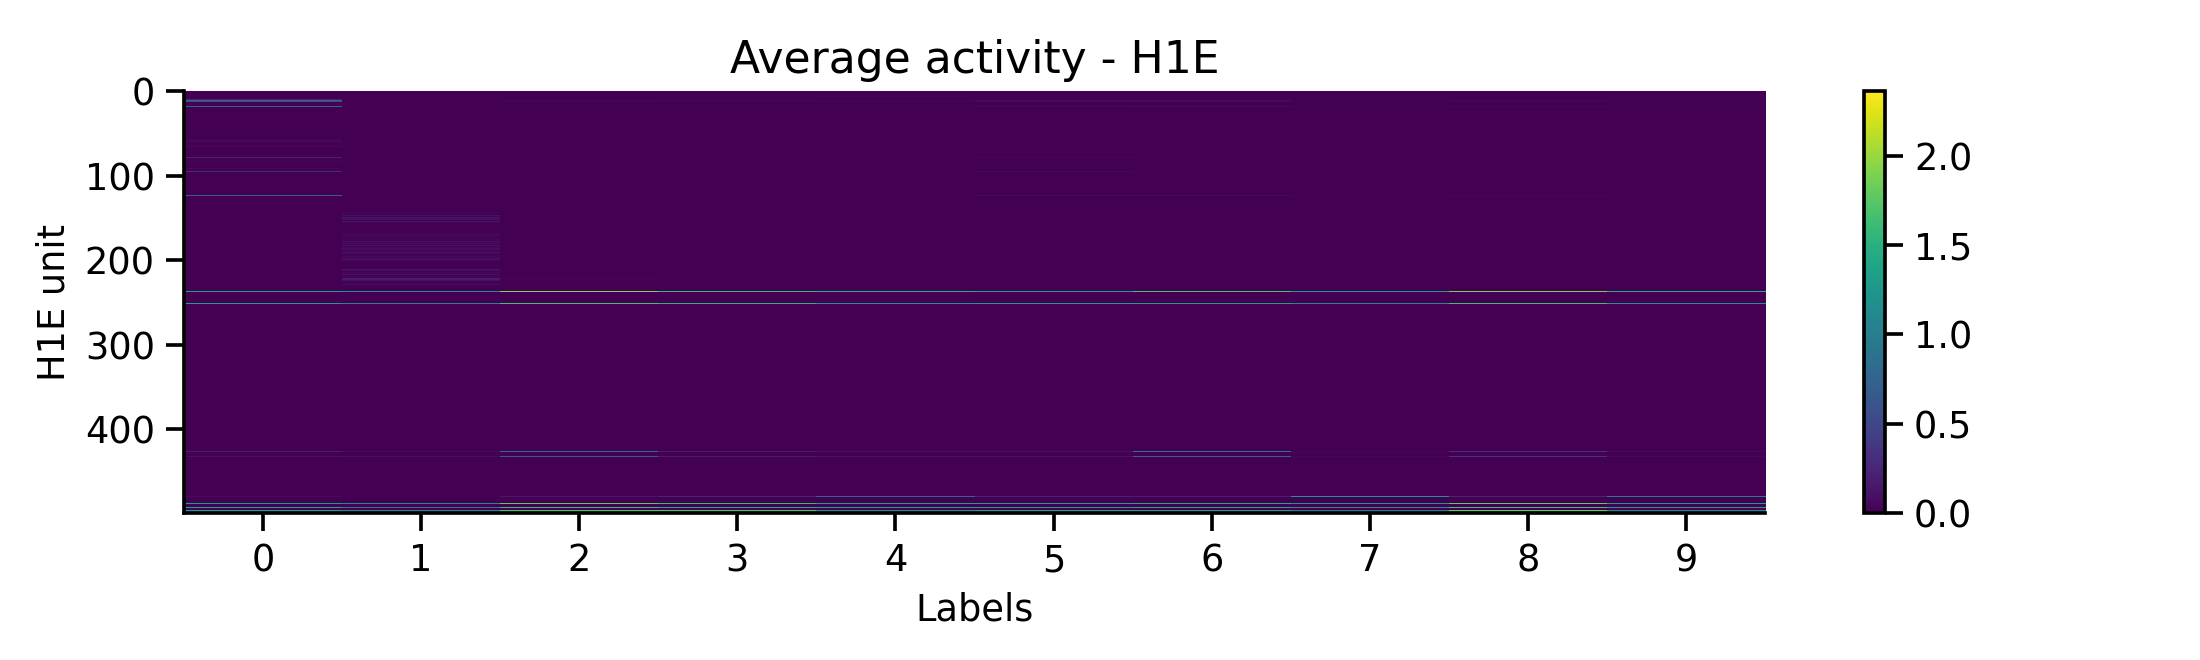

<IPython.core.display.Javascript object>


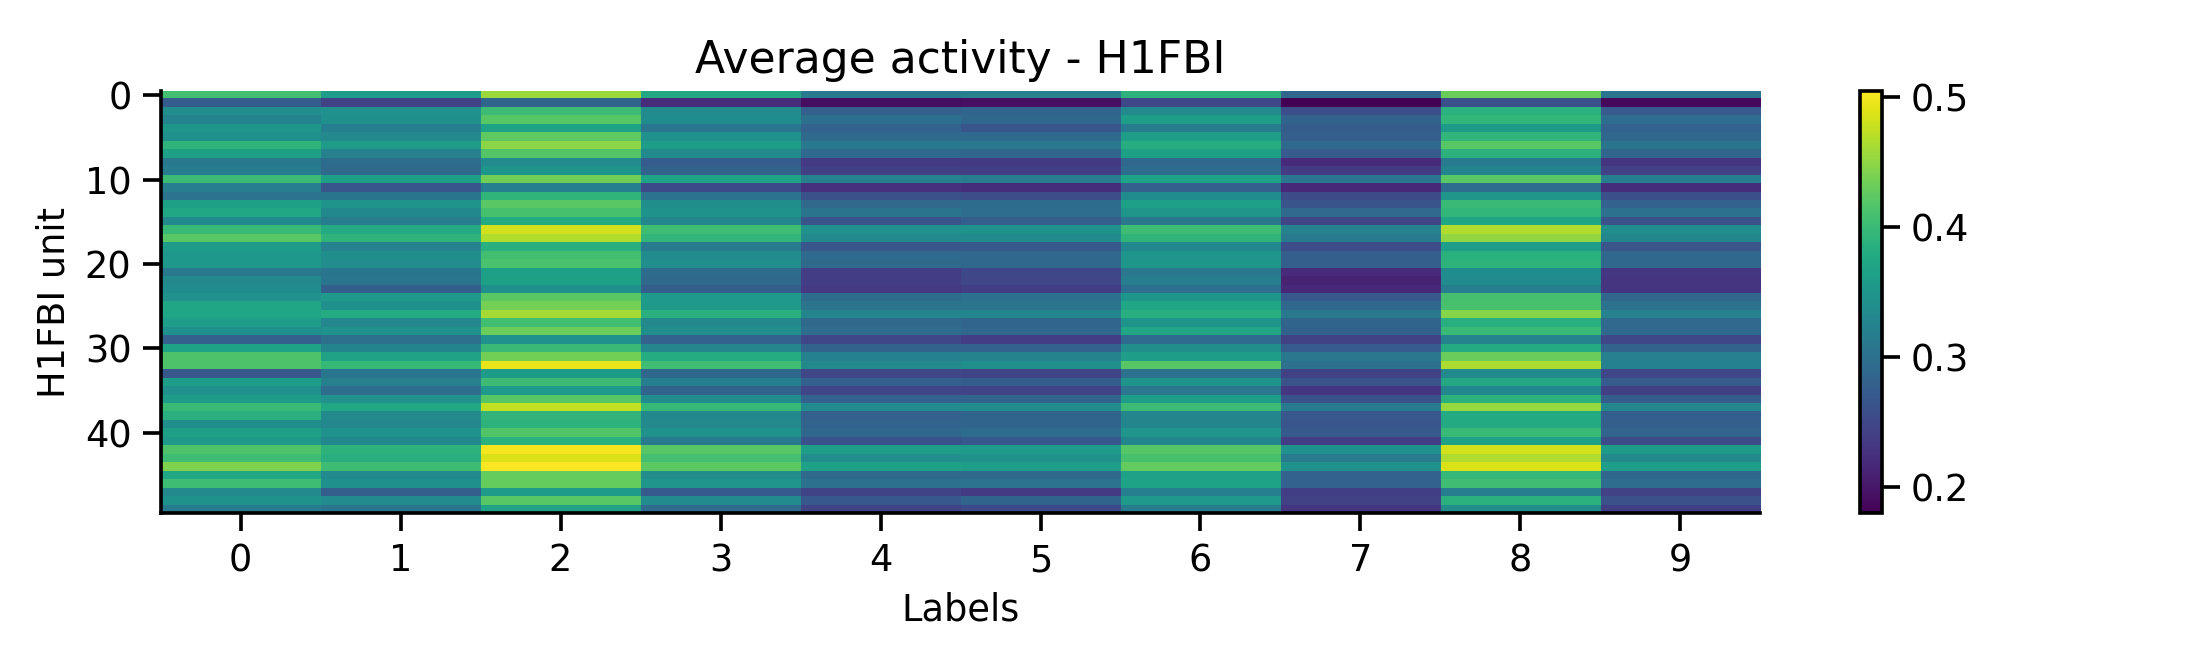

<IPython.core.display.Javascript object>


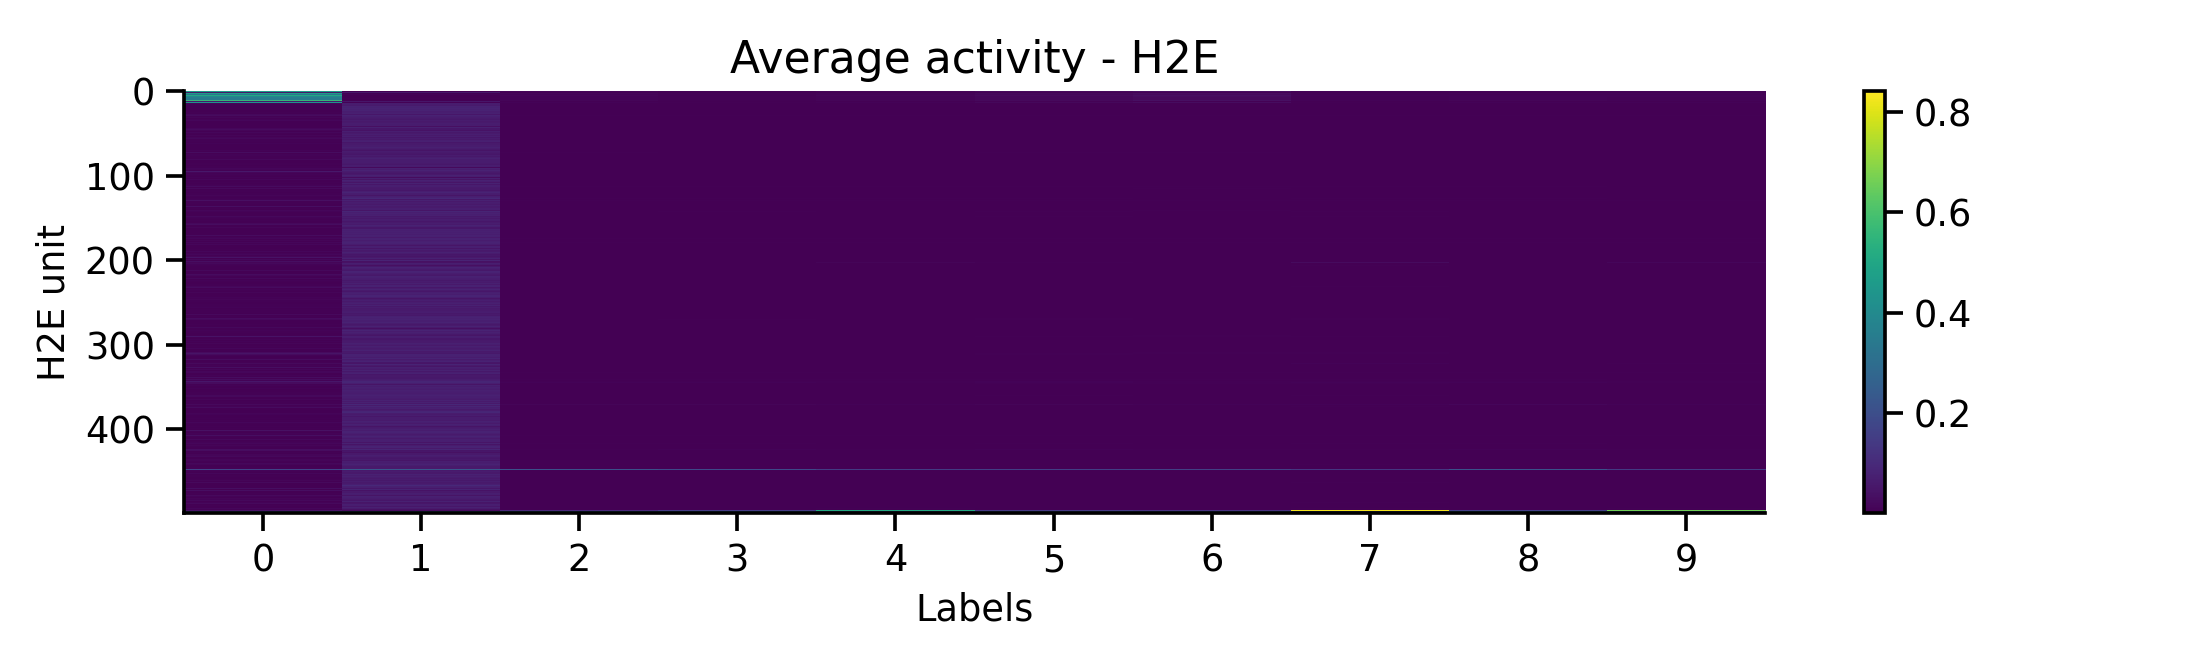

<IPython.core.display.Javascript object>


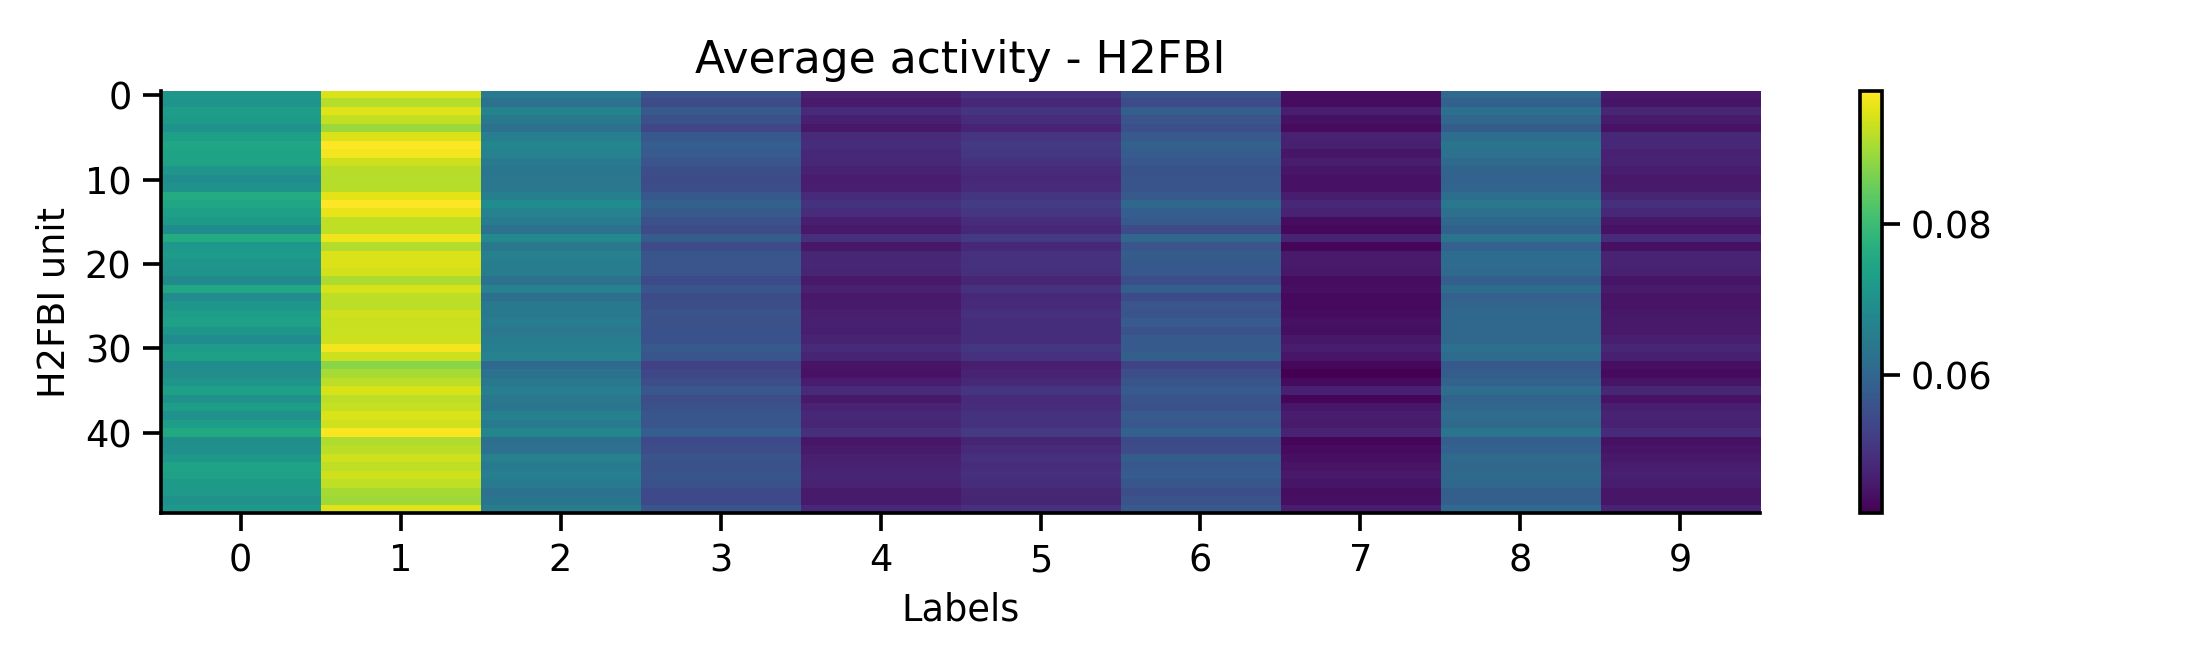

<IPython.core.display.Javascript object>


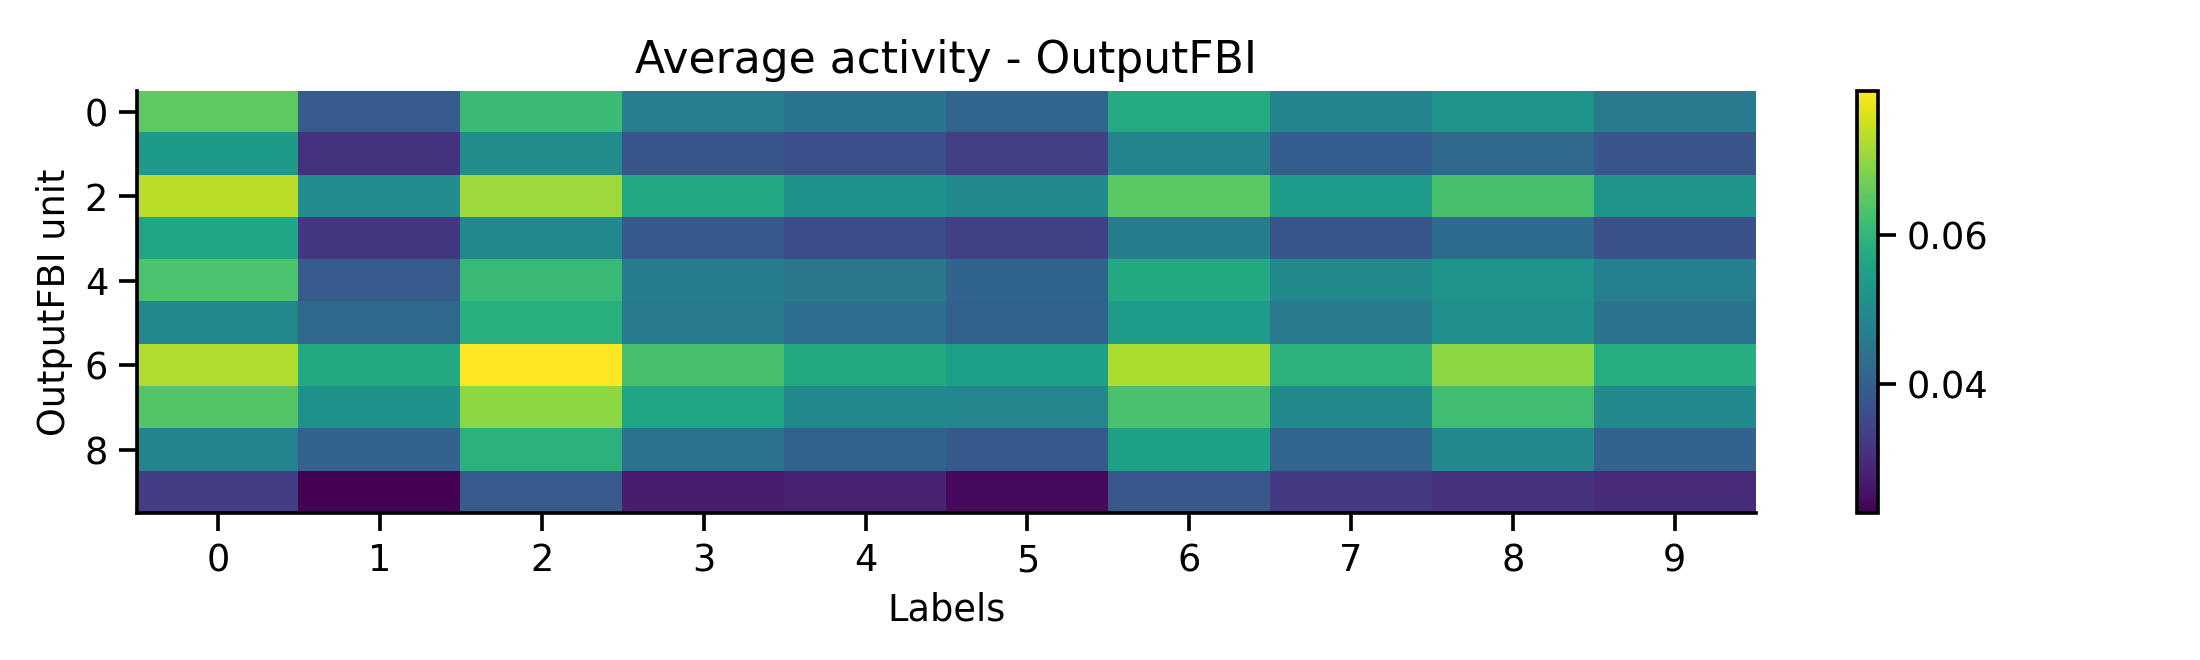

In [77]:
ep.plot_batch_accuracy(network, test_dataloader, population='all')

<IPython.core.display.Javascript object>


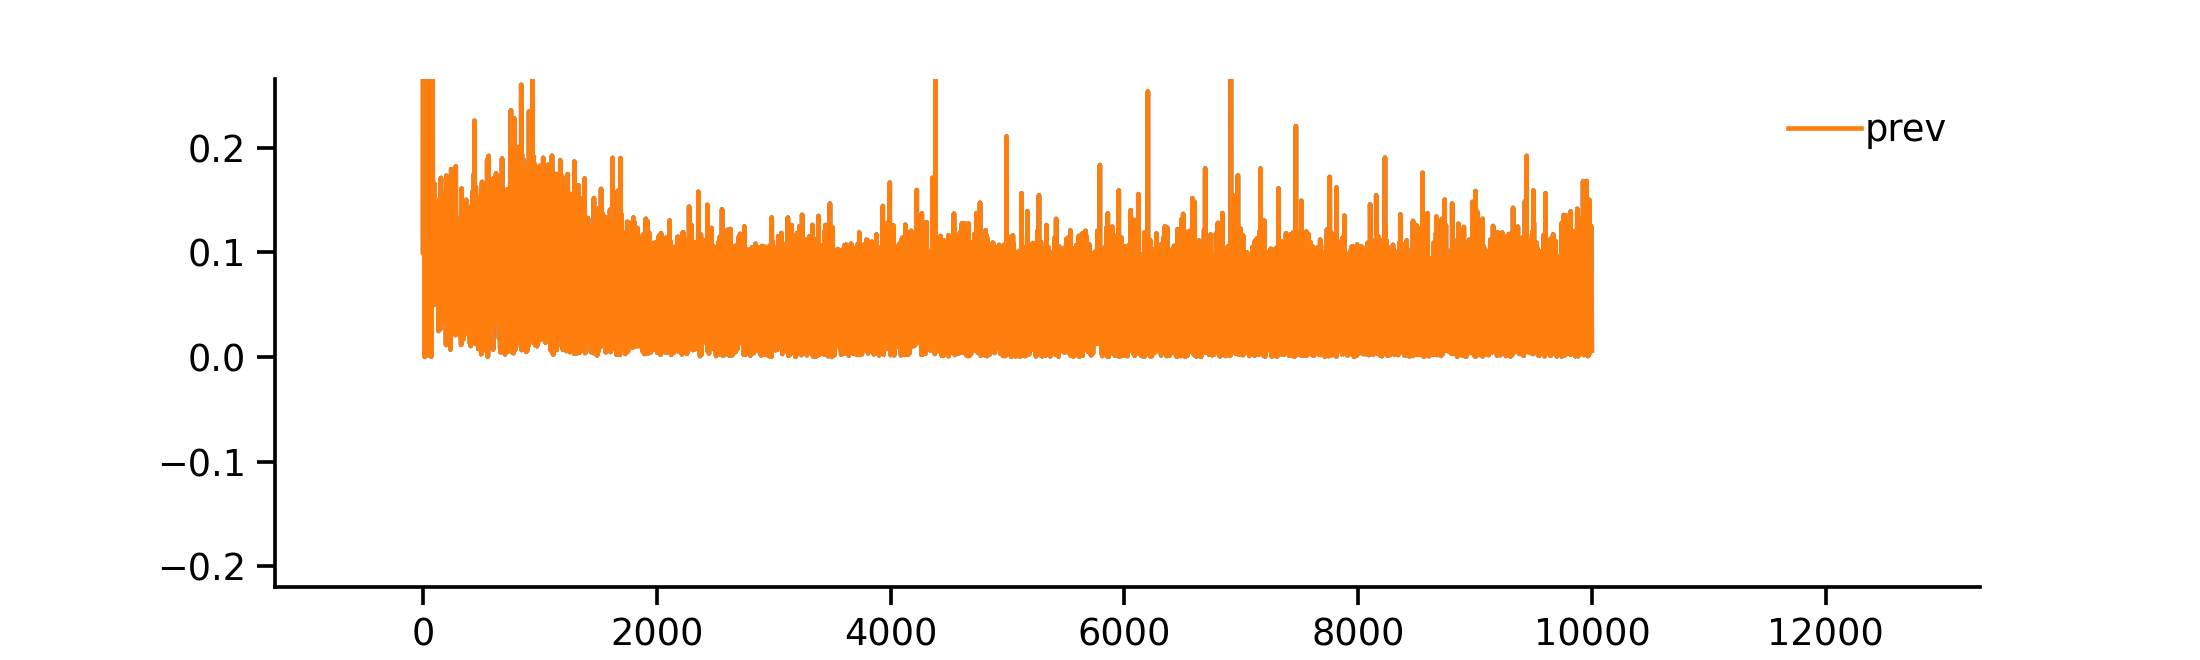

In [81]:
plt.figure()
plt.plot(network.loss_history)
plt.plot(prev_loss_history, label='prev')
plt.legend()

In [80]:
# prev_loss_history = network.loss_history.clone()

<IPython.core.display.Javascript object>


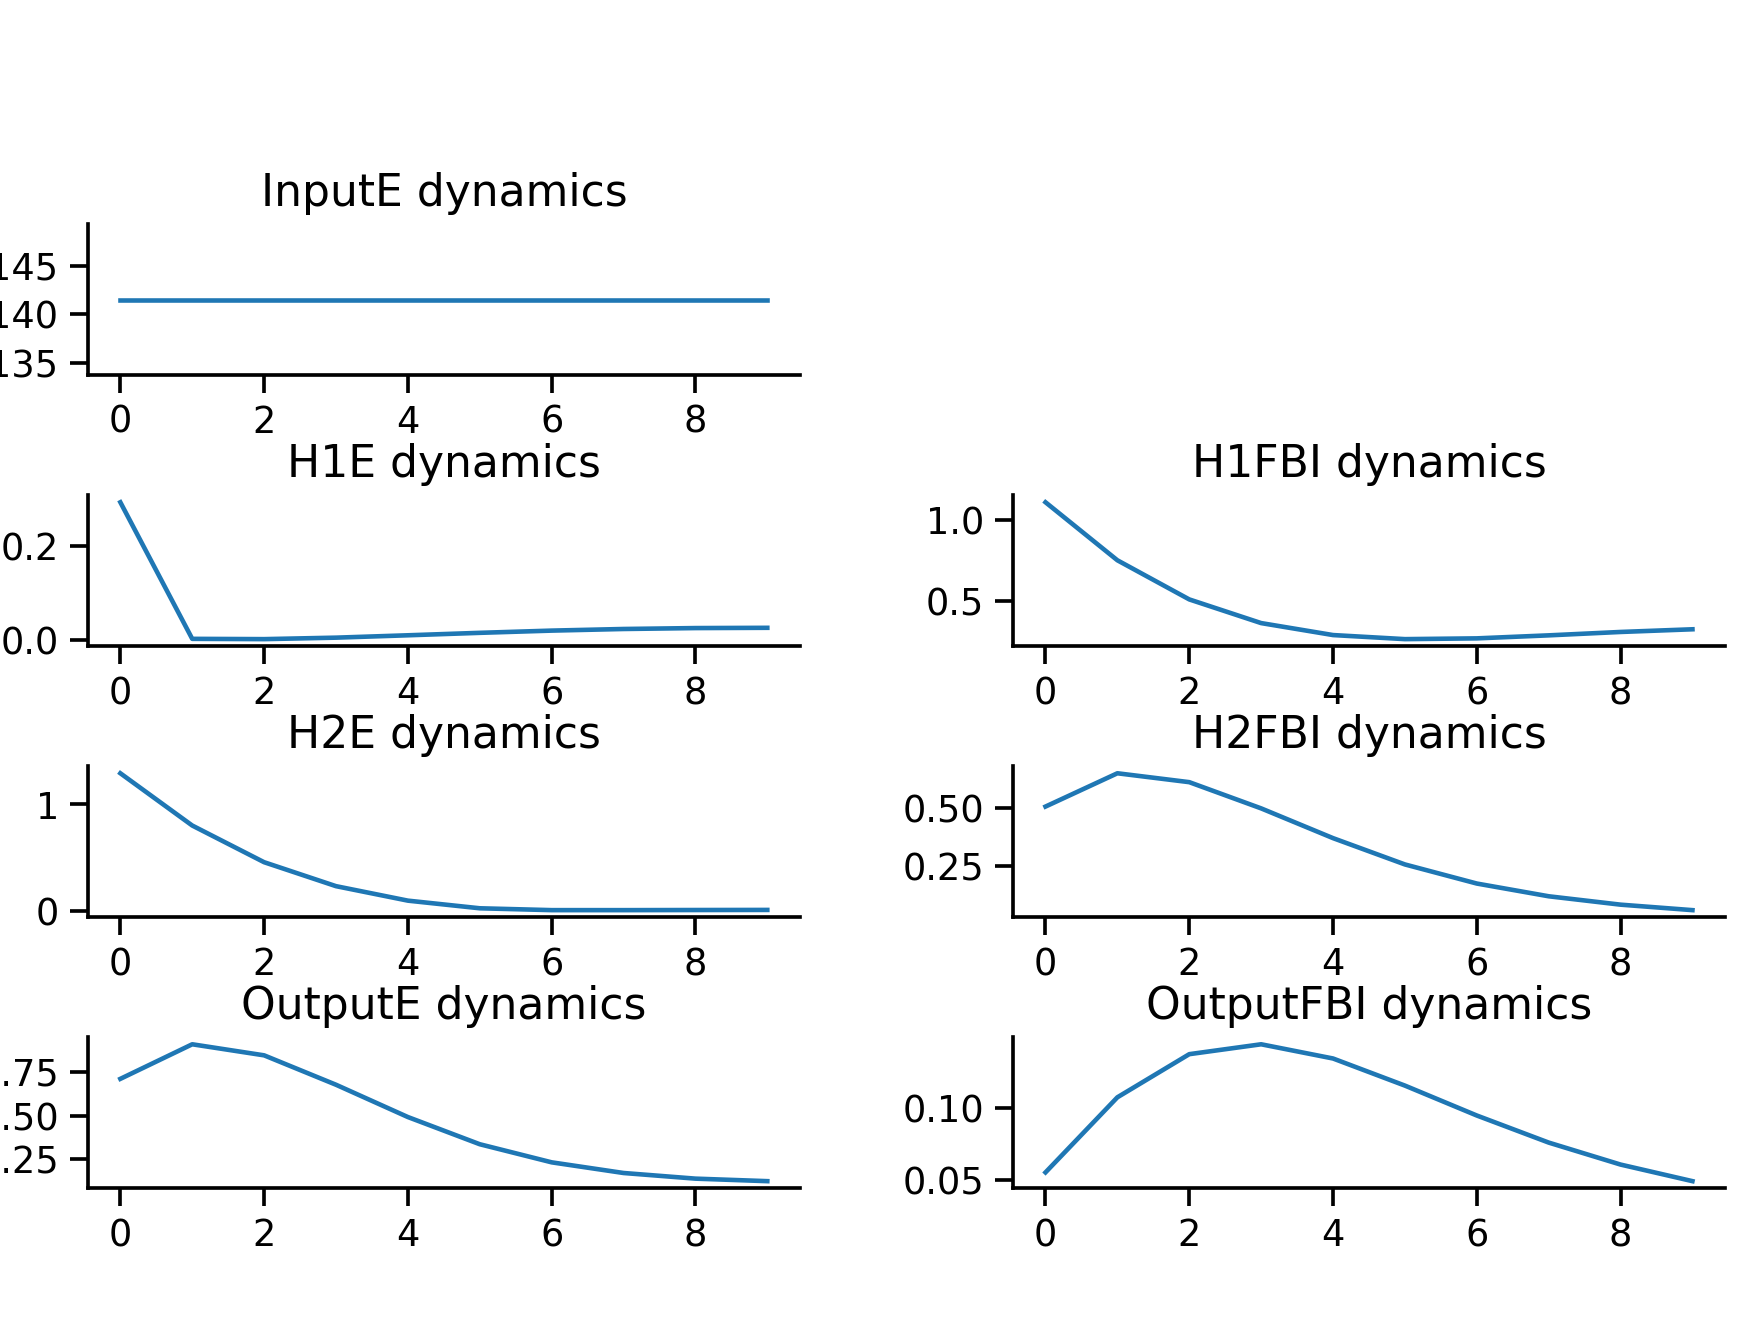

In [76]:
ep.plot_network_dynamics(network)

<IPython.core.display.Javascript object>


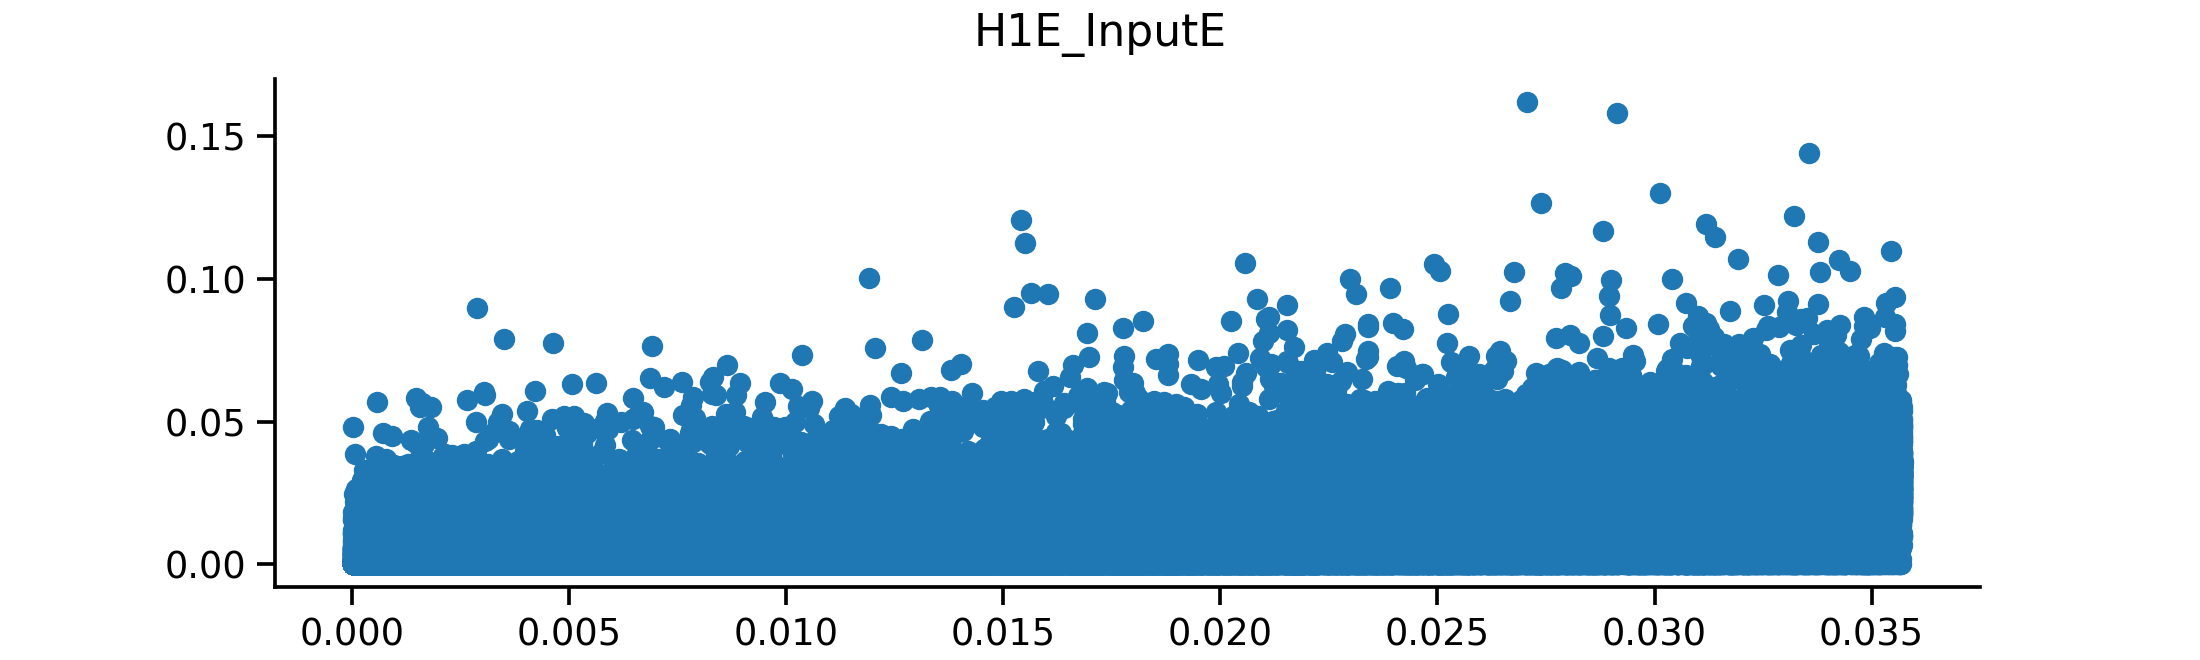

<IPython.core.display.Javascript object>


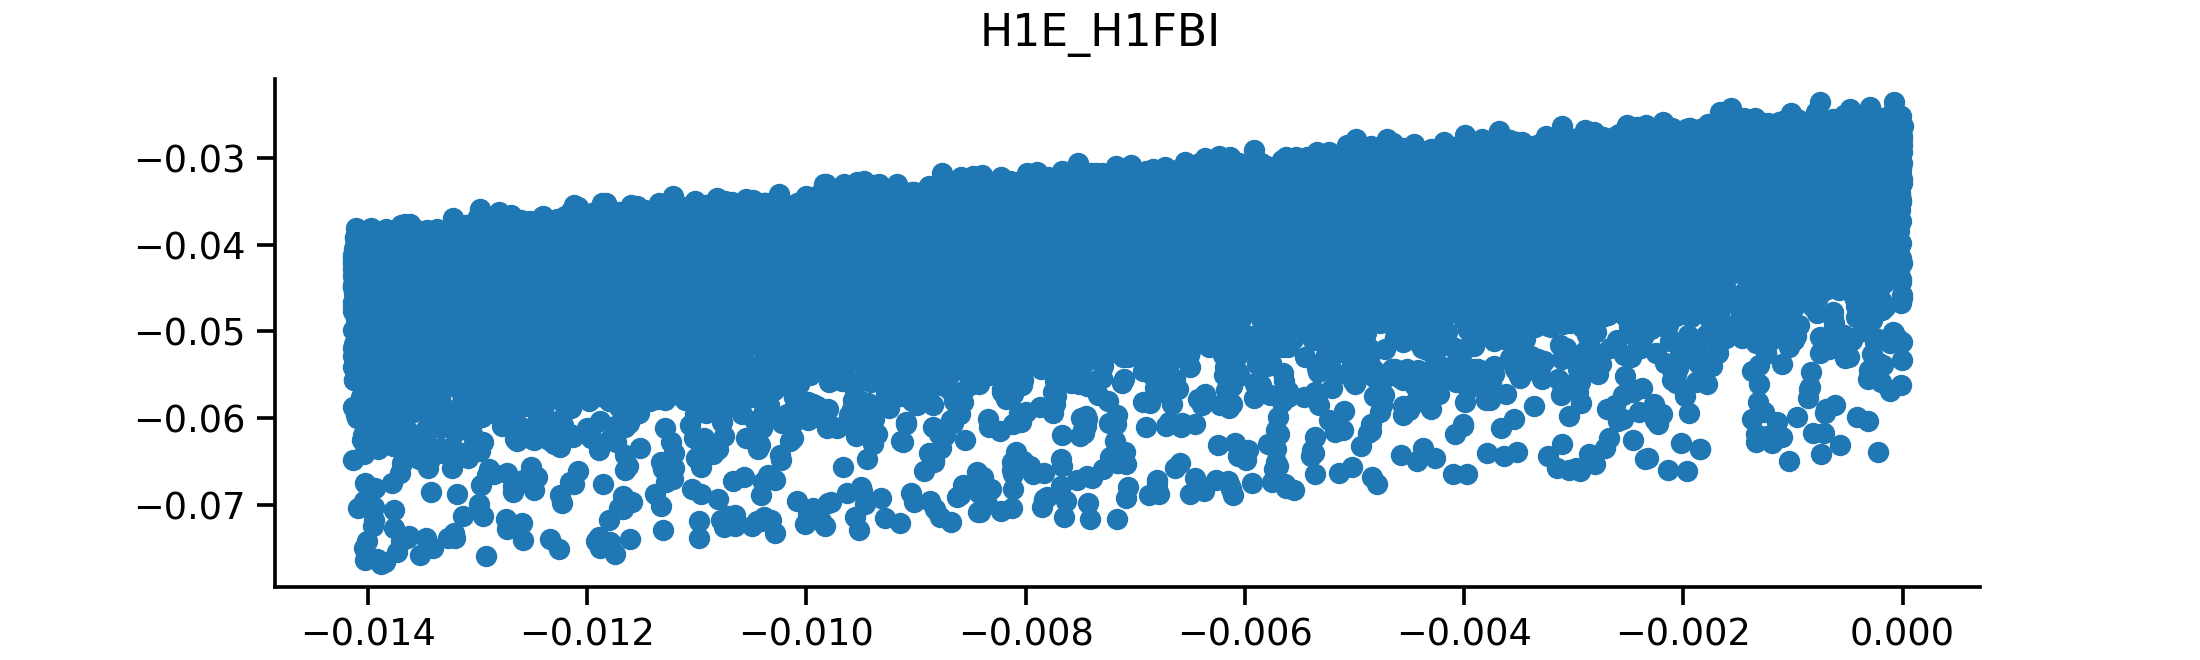

<IPython.core.display.Javascript object>


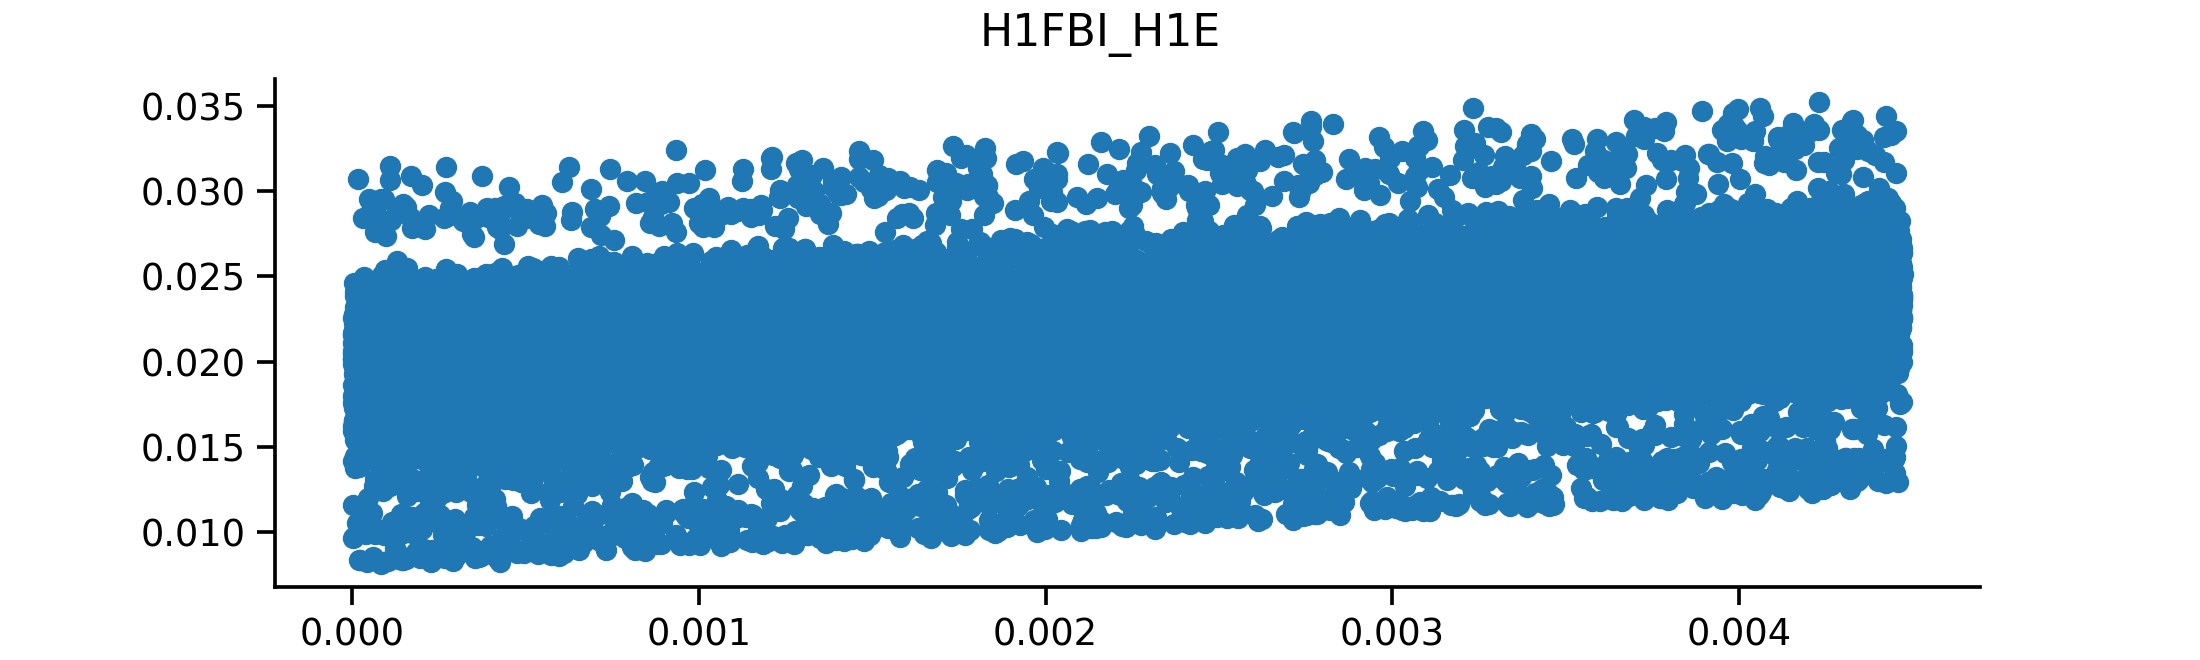

<IPython.core.display.Javascript object>


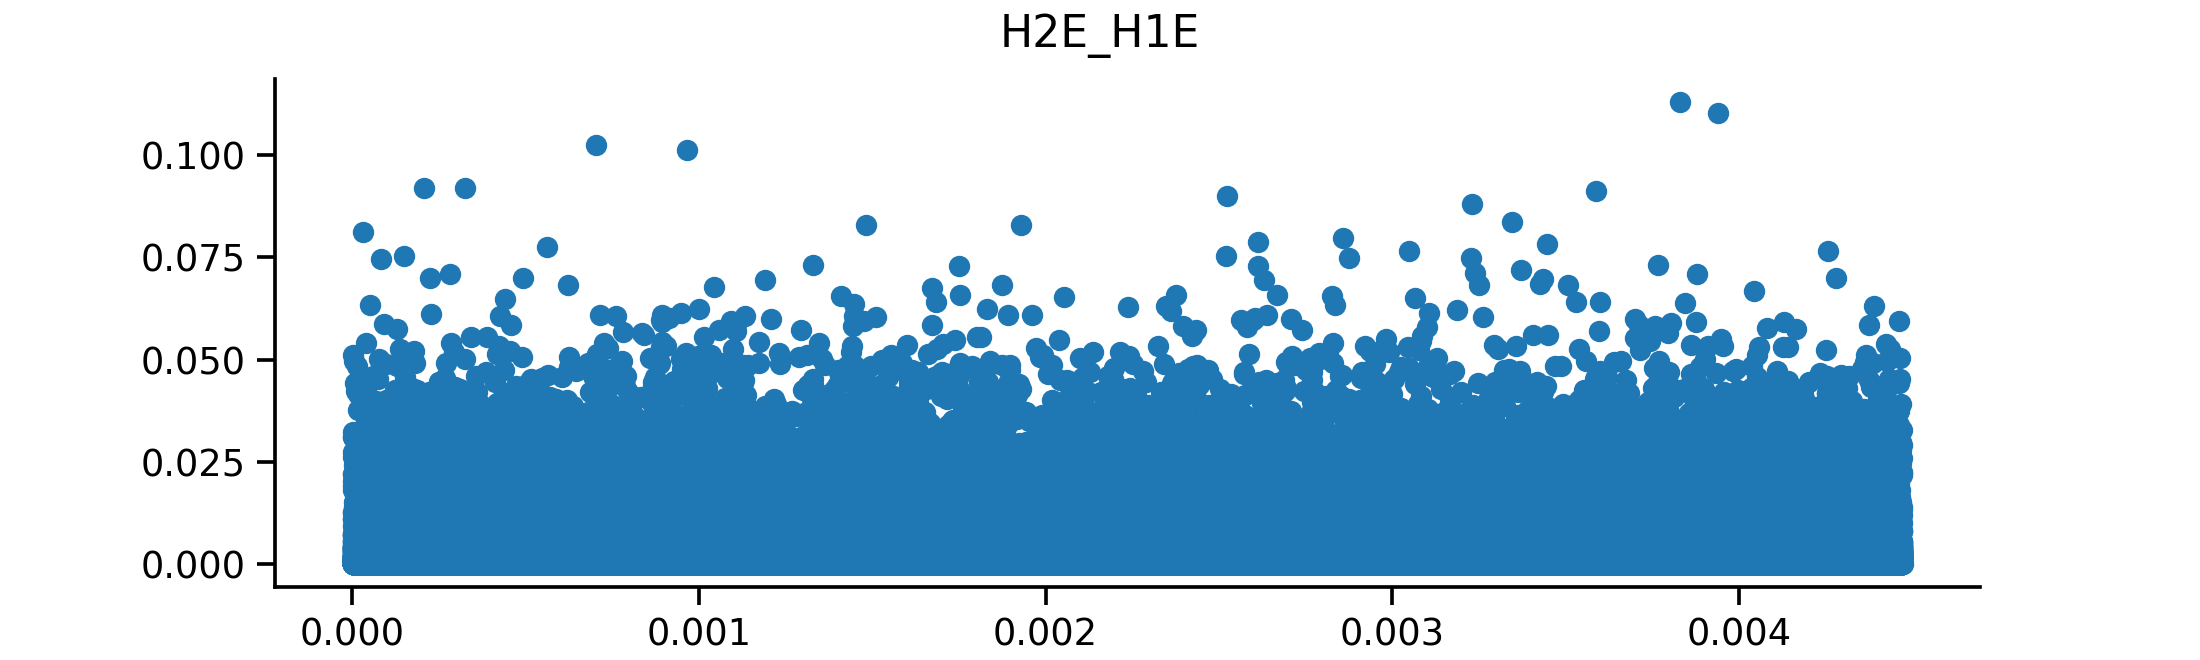

<IPython.core.display.Javascript object>


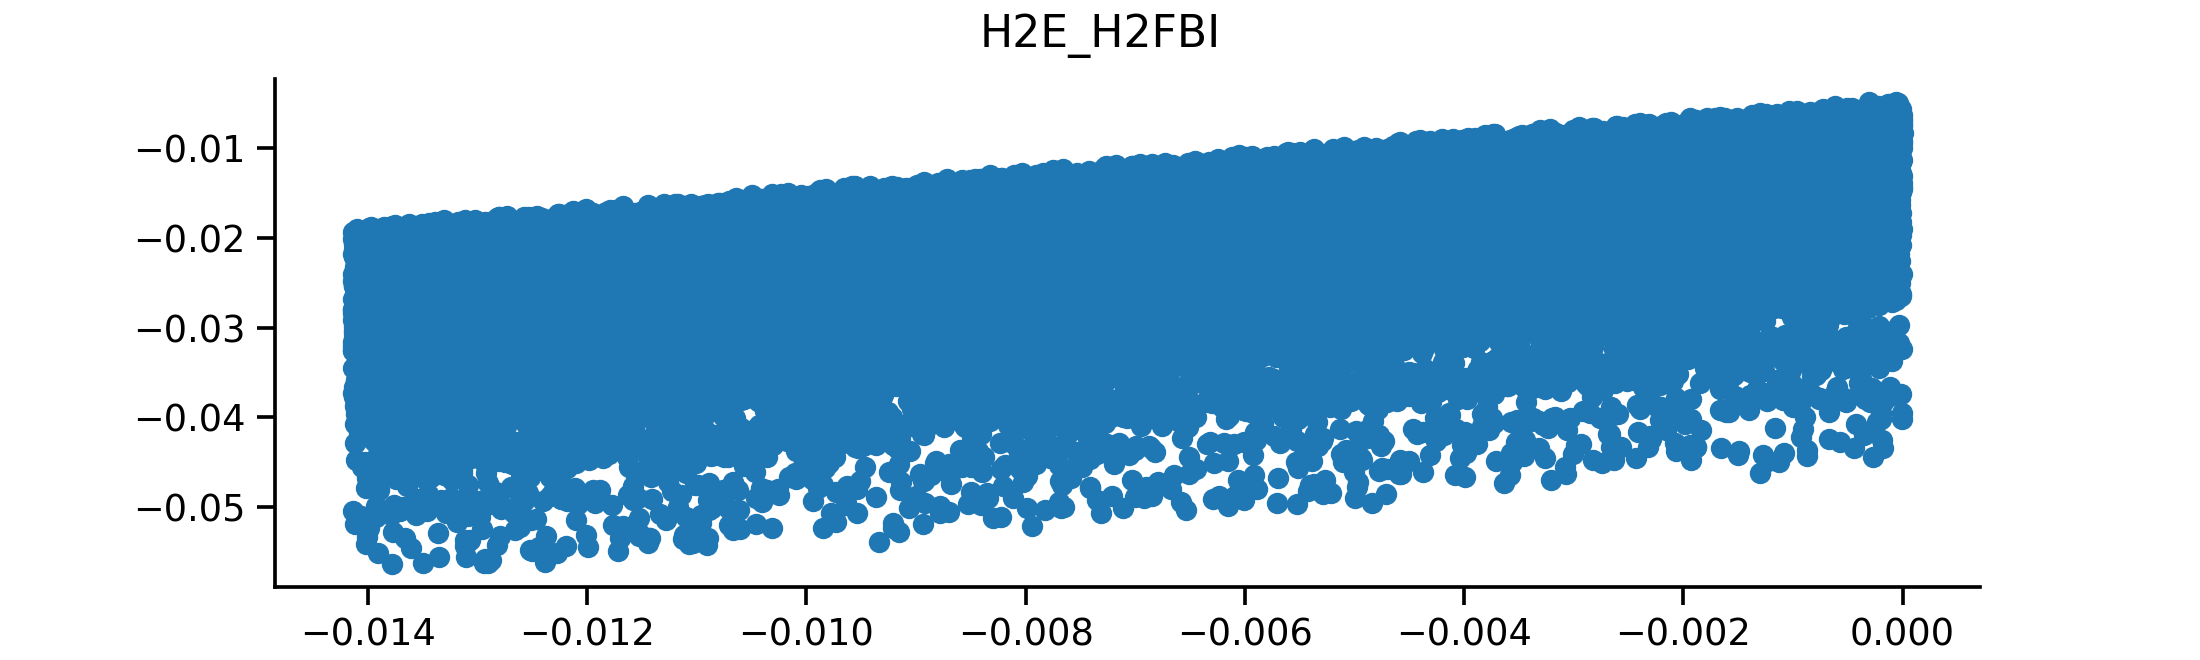

<IPython.core.display.Javascript object>


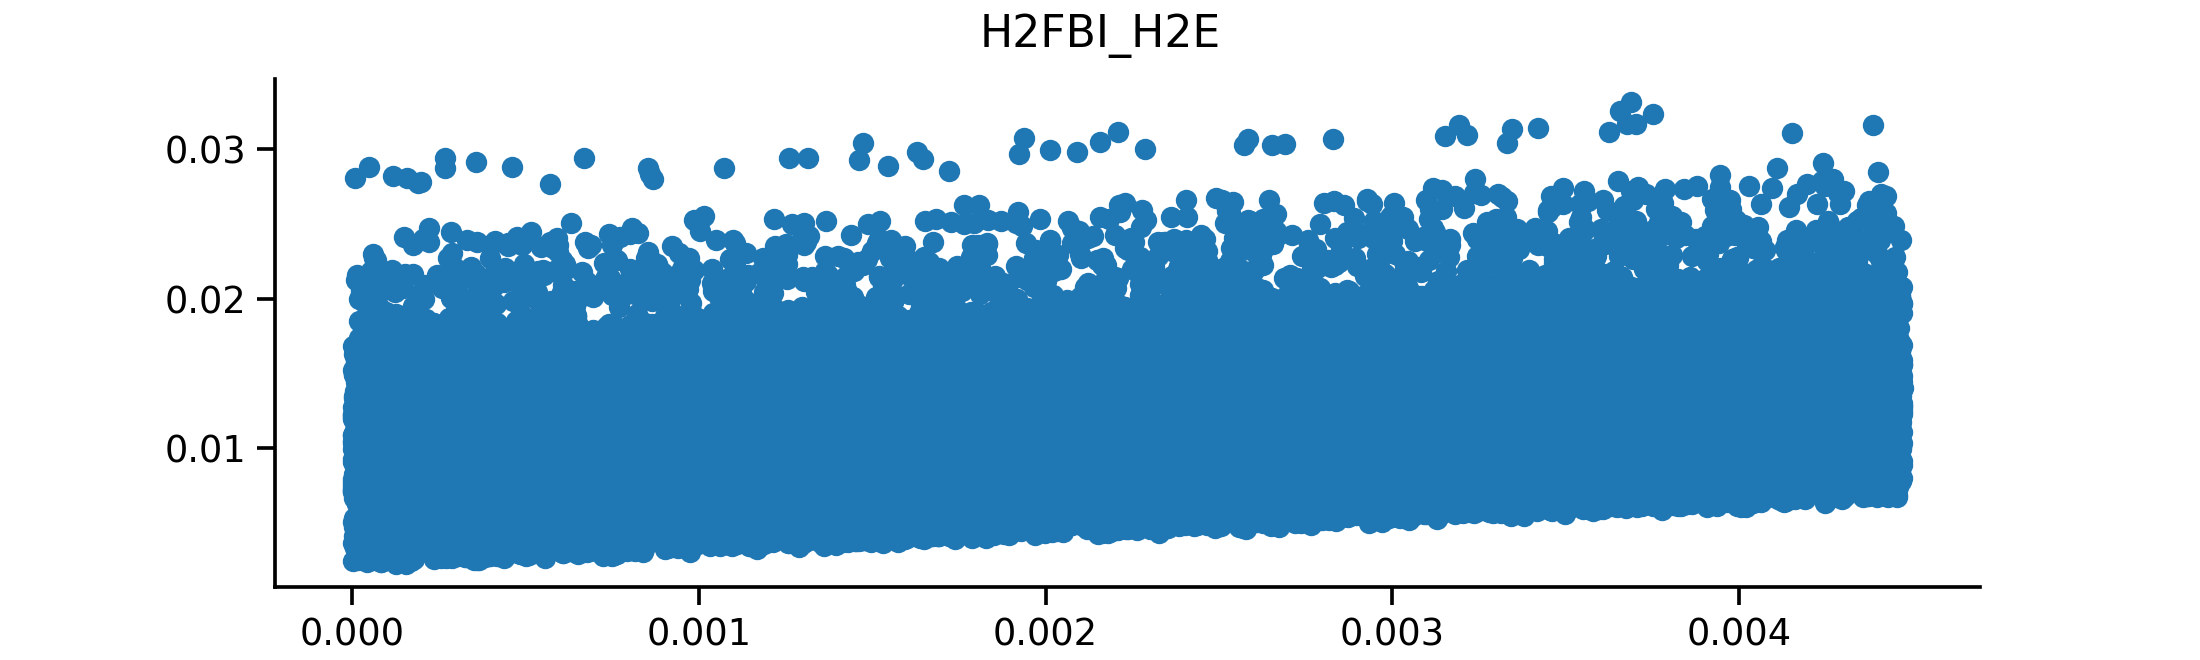

<IPython.core.display.Javascript object>


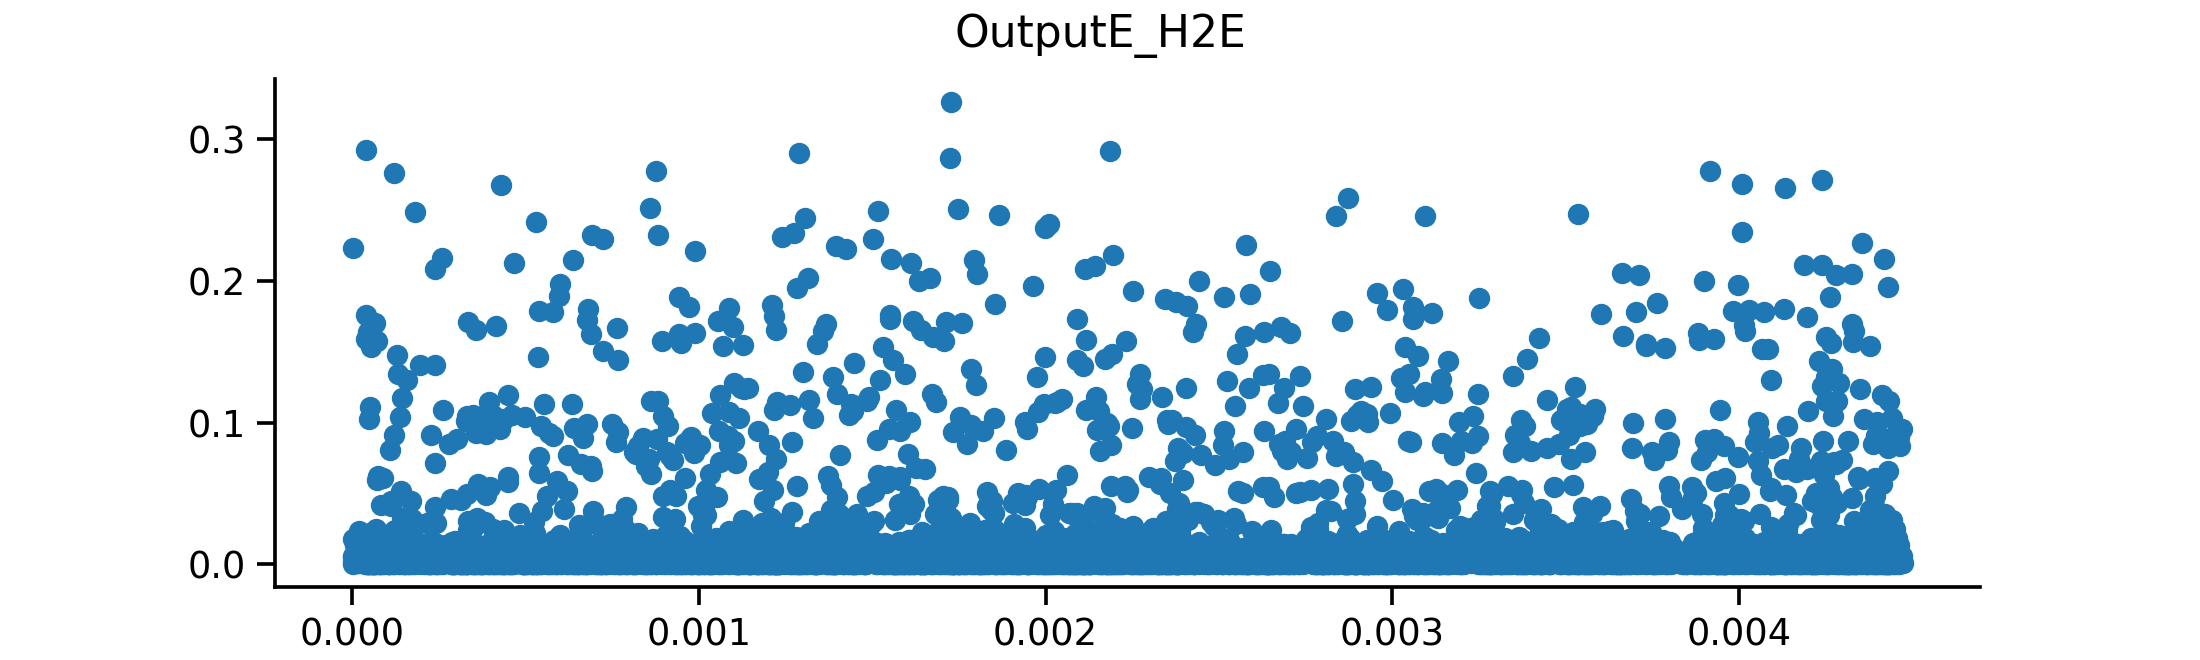

<IPython.core.display.Javascript object>


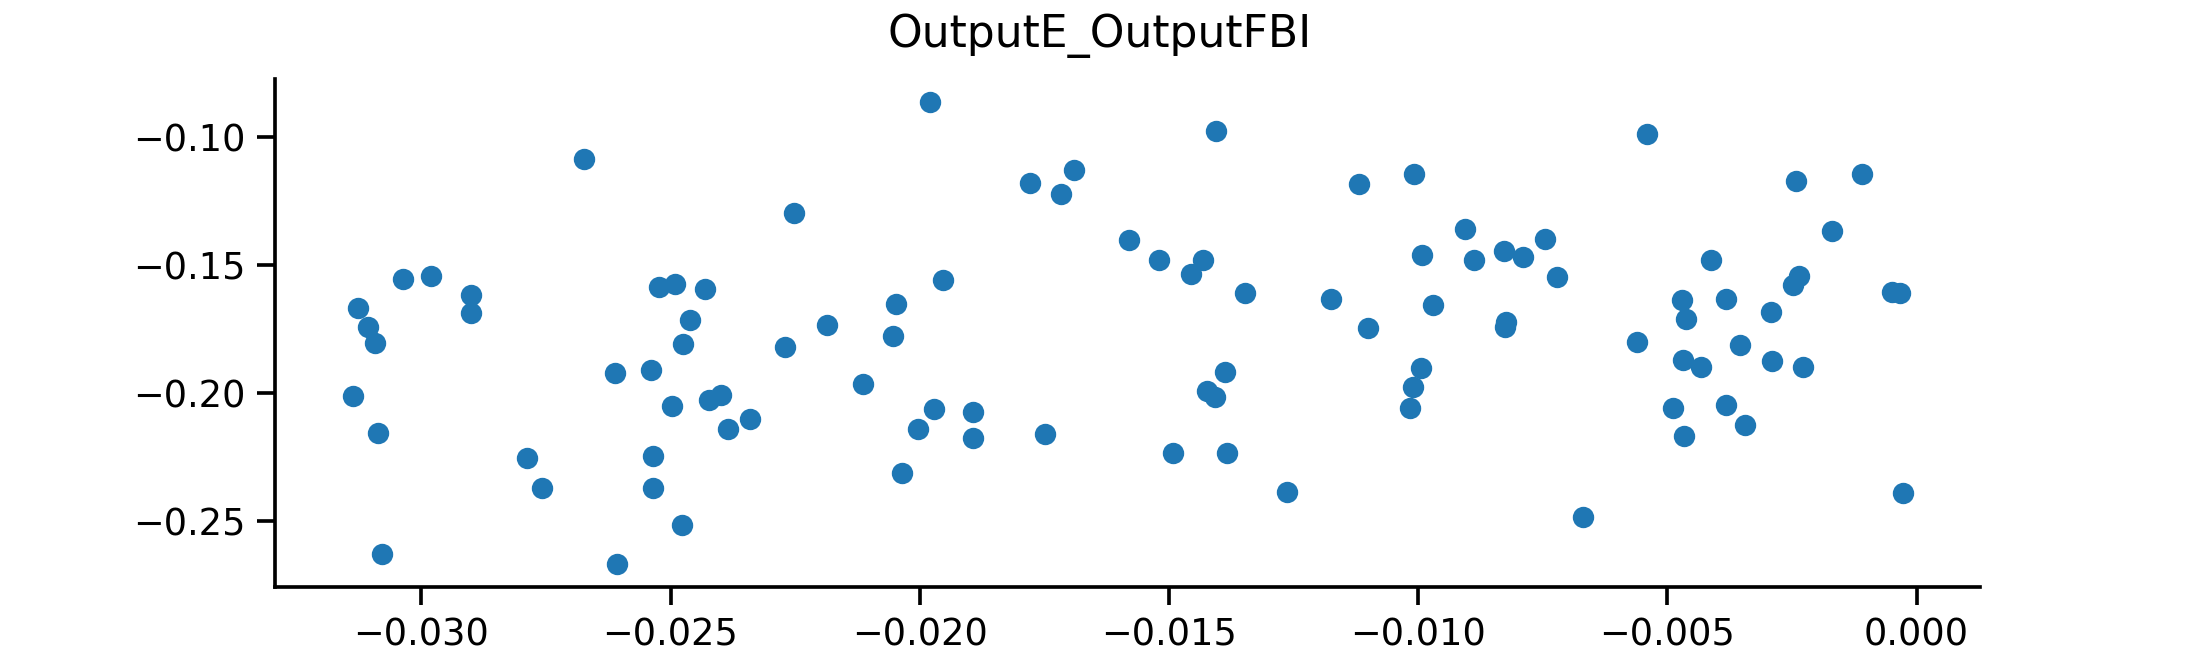

<IPython.core.display.Javascript object>


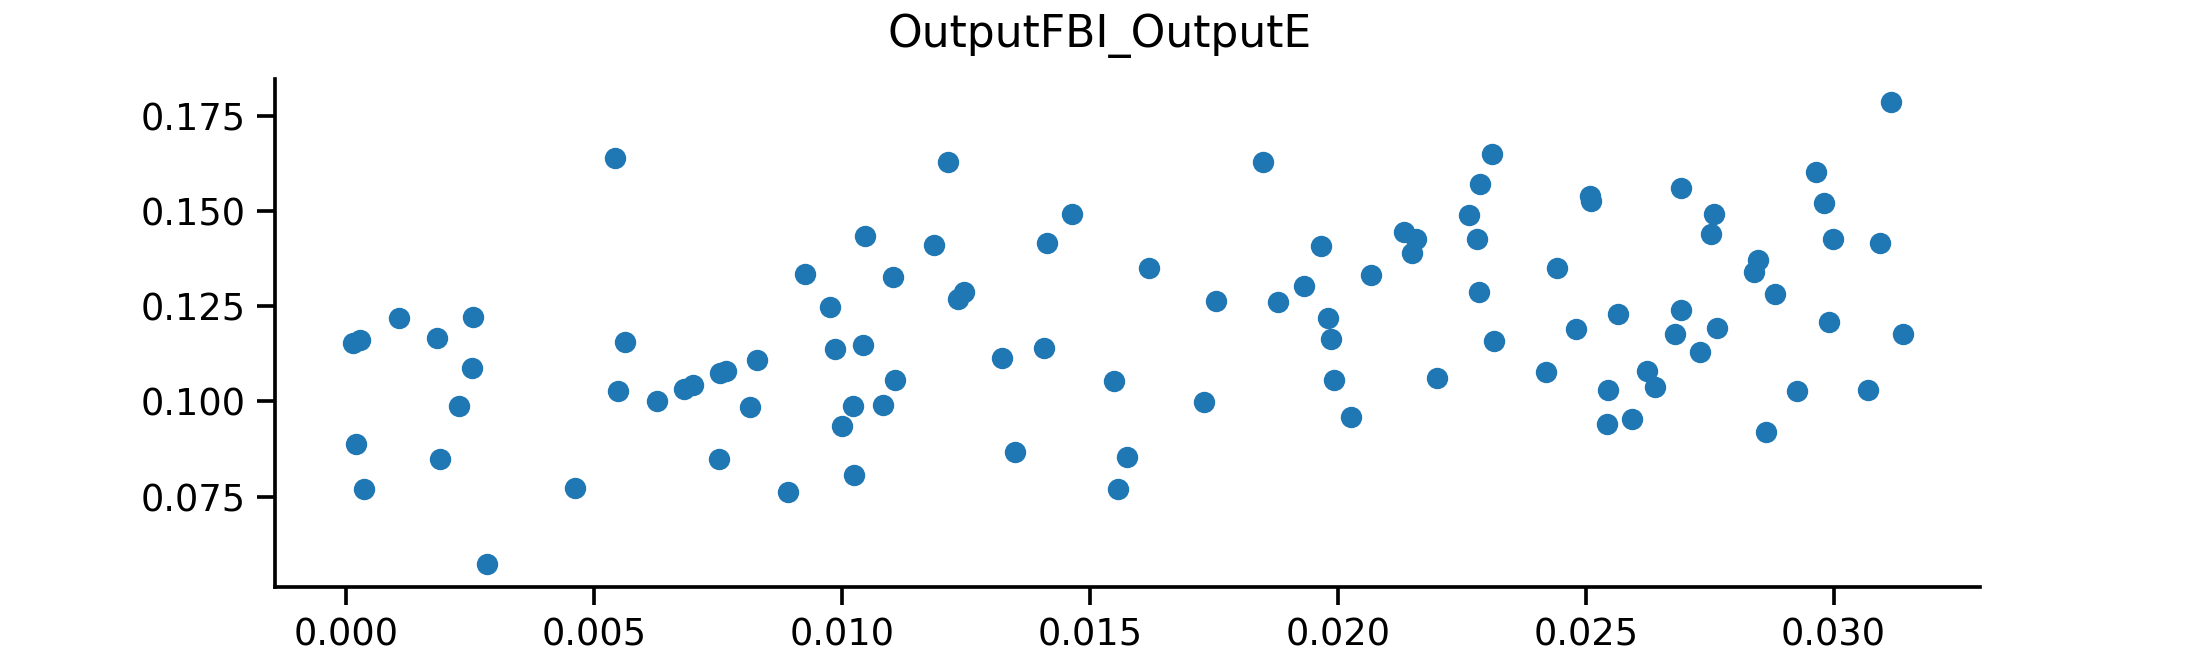

In [134]:
for layer in network:
    for population in layer:
        for projection in population:
            plt.figure()
            plt.scatter(initial_weights[projection.name].flatten(), projection.weight.data.detach().flatten())
            plt.suptitle(projection.name)

<IPython.core.display.Javascript object>


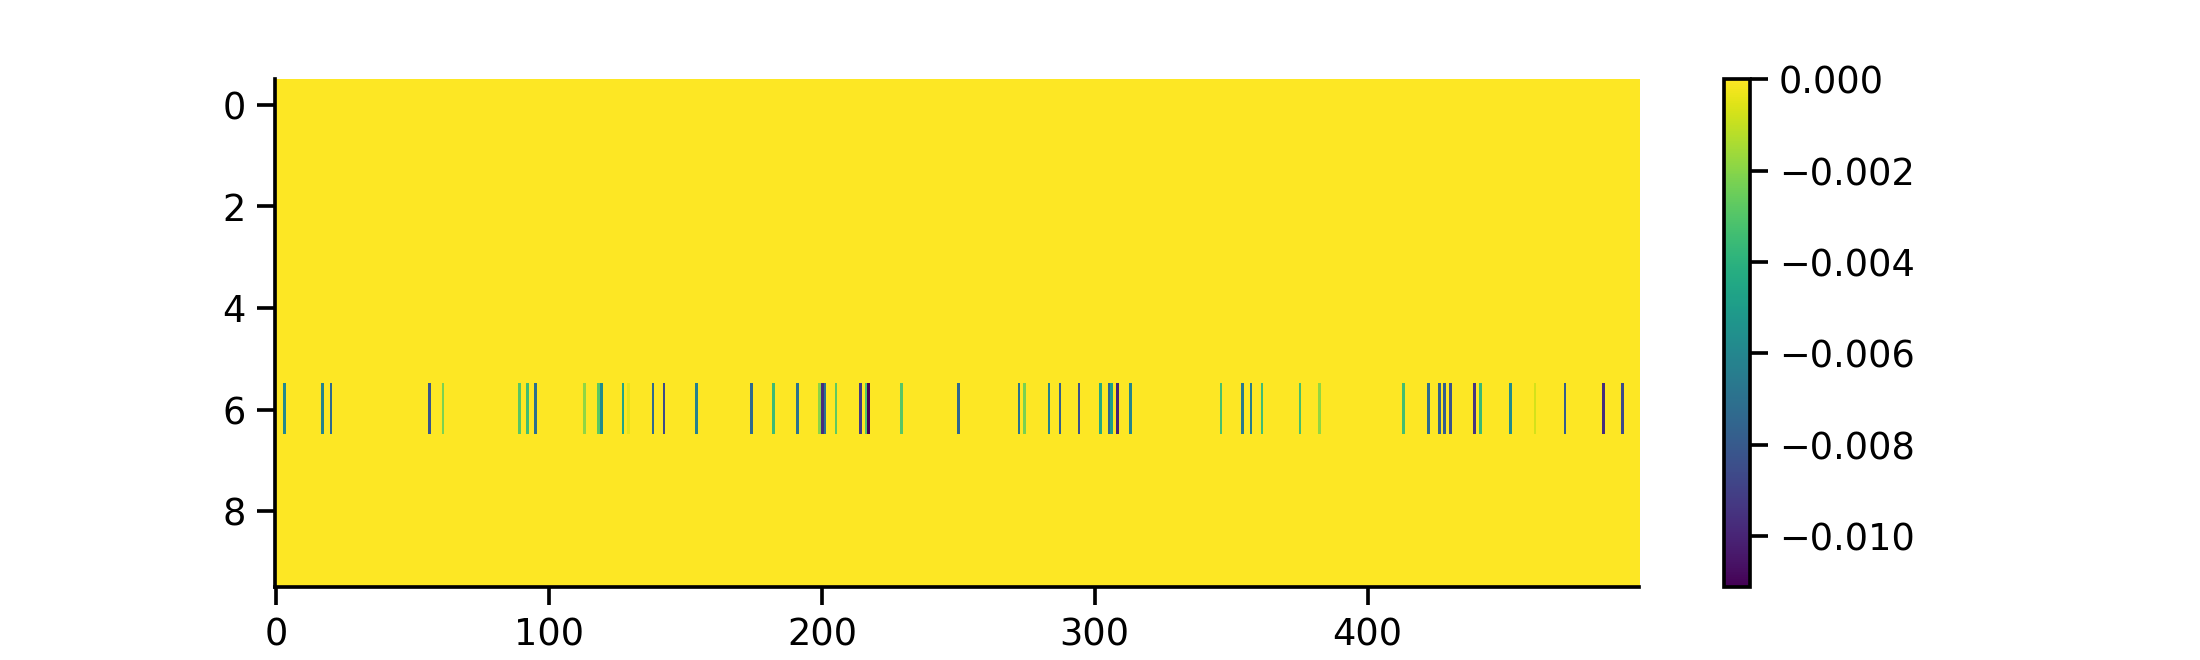

<IPython.core.display.Javascript object>


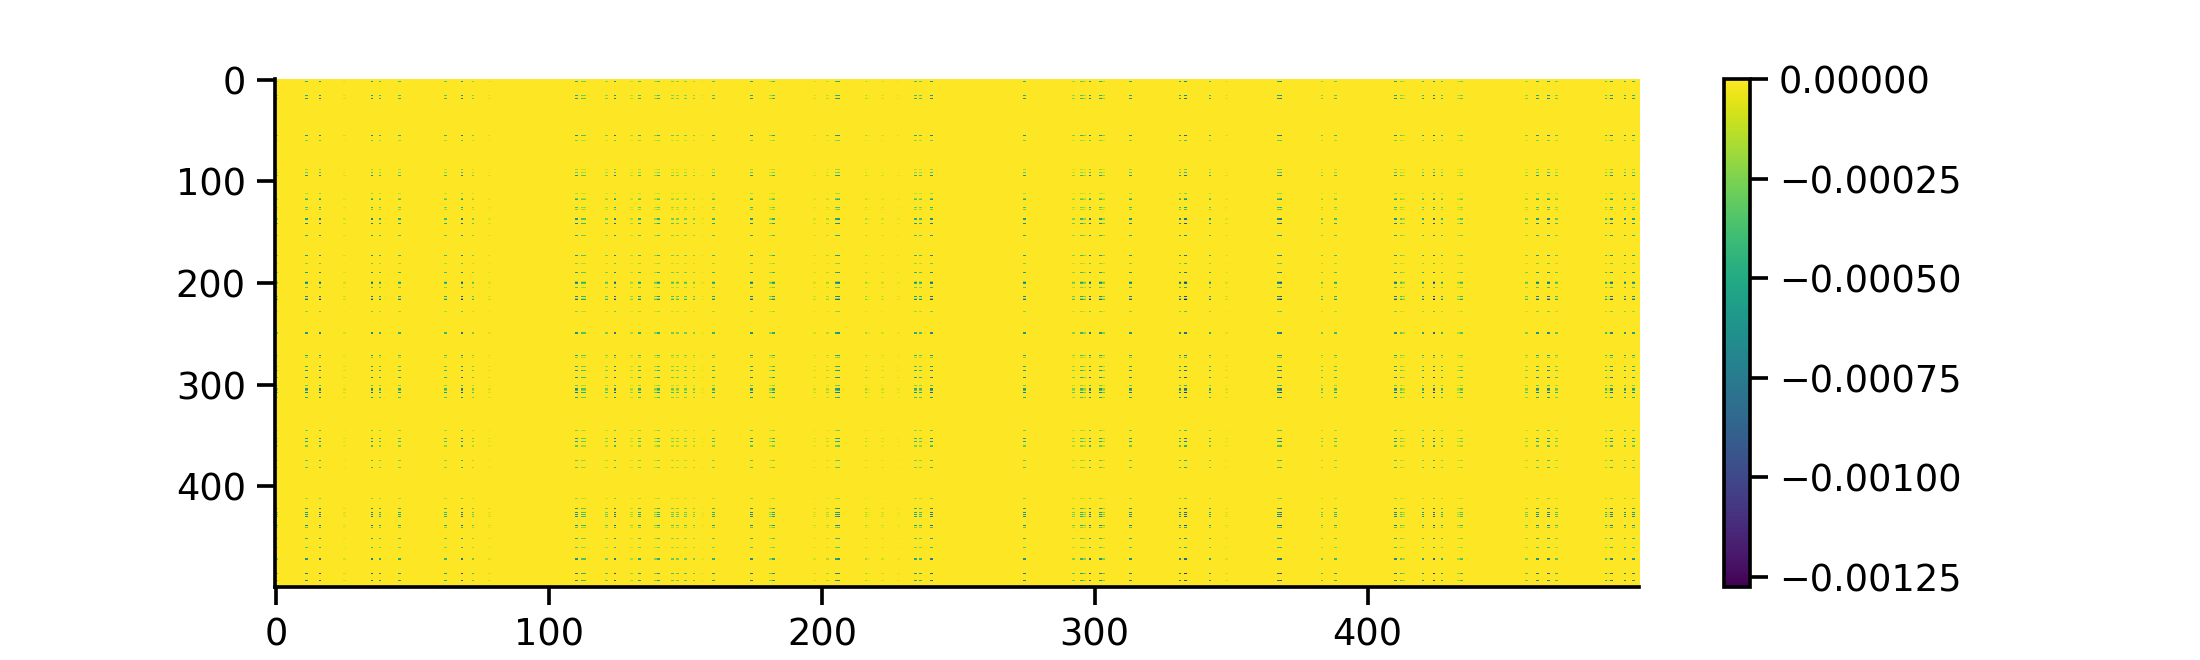

In [129]:
plt.figure()
plt.imshow(network.Output.E.H2.E.weight.grad.detach(), aspect='auto', interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(network.H2.E.H1.E.weight.grad.detach(), aspect='auto', interpolation='none')
plt.colorbar()